# Setup

In [127]:
# !pip install statsmodels
# !pip install pmdarima
# !pip install matplotlib
# !pip install seaborn
# !pip install "black[jupyter]"
# !pip3 install statsforecast
# !pip install prophet
# !pip install --upgrade plotly
# !pip install learntools


In [3]:
# basic
import sys
from datetime import date
import pandas as pd
import numpy as np
import time 
from datetime import datetime

# plotting
from matplotlib import pyplot, dates
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Smoothing & Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.tsa.ar_model import AR, ARResults, AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMAResults
from statsmodels.tsa.arima.model import  ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# prophet
import prophet

# forecast
from statsforecast import StatsForecast

# eval
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import mse, rmse, meanabs

# descriptive tests
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf


# warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/Users/axiao/Desktop/Projects/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/axiao/Desktop/Projects/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%cd /Users/axiao/Desktop/Projects/projects/store_sales/data

holidays_events = pd.read_csv('holidays_events.csv', index_col='date', parse_dates=True)
transactions = pd.read_csv('transactions.csv',index_col='date', parse_dates=True)
oil =  pd.read_csv('oil.csv',index_col='date', parse_dates=True)
stores = pd.read_csv('stores.csv')

train = pd.read_csv('train.csv', index_col='date', parse_dates=True)
train_engineered = pd.read_csv('train_engineered.csv', index_col='date', parse_dates=True)
test = pd.read_csv('test.csv', index_col='date', parse_dates=True)

/Users/axiao/Desktop/Projects/projects/store_sales/data


# Feature Engineering

## NA Handling

In [661]:
dfs = {
    'holidays_events':holidays_events,
    'transactions':transactions,
    'oil':oil,
    'stores':stores,
    'train':train,
    'test':test
}

for k,v in dfs.items():
  if v.isna().sum().any():
    print(f"NAs exist in {k}")

NAs exist in oil


### `oil`

In [662]:
oil['interpolated_price']= oil['dcoilwtico'].interpolate(method='linear')
oil[oil['interpolated_price'].isna()] # check for NAs again

dcoilwtico  interpolated_price
date                                      
2013-01-01         NaN                 NaN

In [663]:
oil['interpolated_price'] =oil['interpolated_price'].fillna(method='bfill')
oil[oil['interpolated_price'].isna()] # check for NAs again

Empty DataFrame
Columns: [dcoilwtico, interpolated_price]
Index: []

In addition, the `oil` table doesn't have a pirce available for every date in the range.
We also use linear regression to extrapolate dates where price isn't available.

In [664]:
# target list, ranging from min train date to max test date
dates_lst = [x for x in pd.date_range(train.index.min().date(), test.index.max().date(), freq='1D').date]
# list of dates in oil date index to scan
scanning_lst = [item.date() for item in oil.index.unique().tolist()]

# use two pointers to find the dates in oil that are missing in the date range of interest
left = 0
right = len(dates_lst)-1
res_lst = []

while left < right:
  if dates_lst[left] not in scanning_lst:
    res_lst.append(dates_lst[left])
  if dates_lst[right] not in scanning_lst:
    res_lst.append(dates_lst[right])
  left += 1
  right -= 1

# convert list into pd date time index
res_lst = pd.DatetimeIndex(res_lst)

add the missing dates back to `oil` index

In [665]:
# create a df for the missing rows
missing_rows = {
    'date': res_lst,
    'dcoilwtico': [np.nan] * len(res_lst),
    'interpolated_price': [np.nan] * len(res_lst)
}

missing_rows_df = pd.DataFrame(missing_rows).set_index('date')

# concat this df back to oil
oil = pd.concat([missing_rows_df, oil], axis=0)

# sort order
oil = oil.sort_index()
oil.head()

dcoilwtico  interpolated_price
date                                      
2013-01-01         NaN           93.140000
2013-01-02       93.14           93.140000
2013-01-03       92.97           92.970000
2013-01-04       93.12           93.120000
2013-01-05         NaN           93.146667

use linear interpolation again to interpolate the missing dataa

In [666]:
oil['interpolated_price']= oil['interpolated_price'].interpolate(method='linear')
oil[oil['interpolated_price'].isna()] # check for NAs again

Empty DataFrame
Columns: [dcoilwtico, interpolated_price]
Index: []

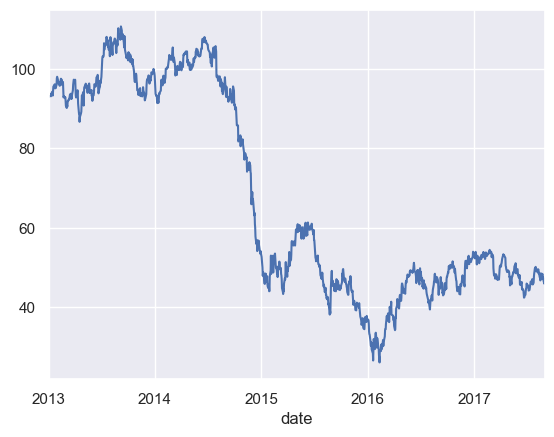

In [668]:
sns.set_theme()
oil['interpolated_price'].plot();

In [136]:
# oil.to_csv('/Users/axiao/Desktop/Projects/projects/store_sales/data/oil.csv')

## `holidays_events`

In [590]:
holidays_events2 = pd.read_csv('holidays_events.csv', index_col='date', parse_dates=True)

Check if each locale name only has 1 holiday

In [591]:
tmp = holidays_events2.groupby(['date', 'locale', 'locale_name']).count()
tmp=tmp[tmp.type>1]

holidays_events2[holidays_events2.index.isin(tmp.reset_index()['date'])].iloc[:,:4]

type    locale locale_name                      description
date                                                                         
2012-12-24      Bridge  National     Ecuador                   Puente Navidad
2012-12-24  Additional  National     Ecuador                        Navidad-1
2012-12-31      Bridge  National     Ecuador        Puente Primer dia del ano
2012-12-31  Additional  National     Ecuador             Primer dia del ano-1
2014-12-26      Bridge  National     Ecuador                   Puente Navidad
2014-12-26  Additional  National     Ecuador                        Navidad+1
2016-05-01     Holiday  National     Ecuador                  Dia del Trabajo
2016-05-01       Event  National     Ecuador              Terremoto Manabi+15
2016-05-07  Additional  National     Ecuador                Dia de la Madre-1
2016-05-07       Event  National     Ecuador              Terremoto Manabi+21
2016-05-08       Event  National     Ecuador              Terremoto Manabi+22
2016-05-08       Event  National     Ecuador                  Dia de la Madre
2016-07-24  Additional     Local   Guayaquil         Fundacion de Guayaquil-1
2016-07-24    Transfer     Local   Guayaquil  Traslado Fundacion de Guayaquil

omit `additional` holidays

In [592]:
tmp = holidays_events2.groupby(['date','locale_name']).count()
tmp=tmp[tmp.type>1]

holidays_events2 = holidays_events2[
    ~(
        (holidays_events2.index.isin(tmp.reset_index()['date']))
        & (holidays_events2.type == 'Additional')
    )
]

# # check again
tmp = holidays_events2.groupby(['date','locale_name']).count()
tmp=tmp[tmp.type>1]
holidays_events2[holidays_events2.index.isin(tmp.reset_index()['date'])].iloc[:,:4]

type    locale locale_name          description
date                                                          
2016-05-01  Holiday  National     Ecuador      Dia del Trabajo
2016-05-01    Event  National     Ecuador  Terremoto Manabi+15
2016-05-08    Event  National     Ecuador  Terremoto Manabi+22
2016-05-08    Event  National     Ecuador      Dia de la Madre

need to do more data engineering for earthquake related days

In [594]:
holidays_events2['terremoto_manabi'] = 0
holidays_events2['terremoto_manabi'] = np.where(
    holidays_events2.description.str.contains('Terremoto Manabi')==True,
    1,
    0
)

# get the days we need to work with
tmp = holidays_events2.groupby(['date','locale_name']).count()
tmp=tmp[tmp.type>1]

# drop
holidays_events2 = holidays_events2[
    ~(
        (holidays_events2.index.isin(tmp.reset_index()['date'])) 
        & (holidays_events2.description.str.contains('Terremoto Manabi'))
    )]


# check again
tmp = holidays_events2.groupby(['date','locale_name']).count()
tmp=tmp[tmp.type>1]
holidays_events2[holidays_events2.index.isin(tmp.reset_index()['date'])].iloc[:,:4]
# holidays_events2.shape


Empty DataFrame
Columns: [type, locale, locale_name, description]
Index: []

In [595]:
holidays_events2[holidays_events2.index=='2016-11-06']

type    locale                     locale_name  \
date                                                            
2016-11-06  Holiday  Regional  Santo Domingo de los Tsachilas   

                                   description  transferred  terremoto_manabi  
date                                                                           
2016-11-06  Provincializacion de Santo Domingo        False                 0

drop `transferred` days

In [596]:
holidays_events2 = holidays_events2[holidays_events2['transferred']==False]
holidays_events2.shape

(331, 6)

## Joining Tables

### `stores` & `oil_price`

In [537]:
# preserve the train index
train_index_lst = train.index.tolist()
train_index = {
    'date':train_index_lst
}
train_index_df = pd.DataFrame(train_index)

# join train and stores
tmp1 = train.merge(
    stores,
    how='left',
    left_on=['store_nbr'],
    right_on=['store_nbr']
)

# add timestamp back
tmp1 = pd.concat([tmp1, train_index_df], axis=1)

# set index
tmp1 = tmp1.set_index('date')

# join with oil
tmp2 = tmp1.merge(
    oil['interpolated_price'],
    how='left',
    right_index=True,
    left_index=True
).rename(
    columns={
        'interpolated_price':'oil_price',
        'type':'store_type',
        'cluster':'store_cluster'
    }
)
len(tmp2)

3000888

In [818]:
test = pd.read_csv('train.csv', index_col='date', parse_dates=True)
test.shape

(3000888, 5)

In [538]:
tmp2.head()

id  store_nbr      family  sales  onpromotion   city      state  \
date                                                                          
2013-01-01   0          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
2013-01-01   1          1   BABY CARE    0.0            0  Quito  Pichincha   
2013-01-01   2          1      BEAUTY    0.0            0  Quito  Pichincha   
2013-01-01   3          1   BEVERAGES    0.0            0  Quito  Pichincha   
2013-01-01   4          1       BOOKS    0.0            0  Quito  Pichincha   

           store_type  store_cluster  oil_price  
date                                             
2013-01-01          D             13      93.14  
2013-01-01          D             13      93.14  
2013-01-01          D             13      93.14  
2013-01-01          D             13      93.14  
2013-01-01          D             13      93.14

### `holidays_events`

in the last section, we made sure that on the locale_name-date level, now there's only one event/holiday for each day.

Now we take another two steps to join holidays events to the `train` table:
- join all rows with natioanl events
- then join regional/local ones on the city names

In [598]:
national_holidays = holidays_events2[holidays_events2['locale']=='National'][['locale_name', 'description']]
national_holidays.rename(
    columns={'description':'national_holidays'},
    inplace=True
)

local_regional_holidays = holidays_events2[holidays_events2['locale']!='National'][['locale_name', 'description']]
local_regional_holidays.rename(
    columns={'description':'regional_local_holidays'},
    inplace=True
)
# local_regional_holidays

In [588]:
holidays_events2[holidays_events2.index=='holidays_events2']

Empty DataFrame
Columns: [type, locale, locale_name, description, transferred, terremoto_manabi]
Index: []

In [599]:
# local_regional_holidays[local_regional_holidays.index=='2016-11-06']

locale_name             regional_local_holidays
date                                                                          
2016-11-06  Santo Domingo de los Tsachilas  Provincializacion de Santo Domingo

#### National Holidays

In [543]:
tmp2.shape

(3000888, 10)

In [600]:
tmp3 = tmp2.merge(
    national_holidays['national_holidays'],
    how='left',
    left_index=True,
    right_index=True
)
tmp3.shape

(3000888, 11)

#### Local/ regional holidays

In [655]:
tmp4 = tmp3.reset_index().merge(
    local_regional_holidays.reset_index(),
    how='left',
    left_on=['date', 'city'],
    right_on=['date','locale_name']
)
tmp4.shape

(3000888, 14)

drop the `locale_name` column cause it contains the same info as the `city` column in the `train` df

In [656]:
# tmp4.drop(columns=['locale_name'], inplace=True)

tmp4.set_index('date',inplace=True)

In [778]:
tmp4.shape

(3000888, 14)

sanity check if anything's missing

In [630]:
holidays_events2.shape[0] == national_holidays.shape[0] +local_regional_holidays.shape[0]

True

all 'in-region' local/regional holidays are added 

In [658]:
lst = tmp4[
    (tmp4.index.isin(local_regional_holidays.index))
    & (tmp4['regional_local_holidays'].isna())
    & (tmp4['city'] == tmp4['locale_name'])
].index.unique()

len(lst)

0

#### Out-of-region holidays

but there're local/regional holidays not captured cause there was no corresponding store in the city

In [730]:
tmp4[
    (tmp4.index.isin(local_regional_holidays.index))
    & (tmp4['regional_local_holidays'].isna())
    & (tmp4['city'] != tmp4['locale_name'])
].index.unique()

DatetimeIndex(['2013-03-02', '2013-04-01', '2013-04-12', '2013-04-14',
               '2013-04-21', '2013-05-12', '2013-06-23', '2013-06-25',
               '2013-07-03', '2013-07-23',
               ...
               '2017-04-21', '2017-05-12', '2017-06-23', '2017-06-25',
               '2017-07-03', '2017-07-23', '2017-07-24', '2017-07-25',
               '2017-08-05', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=117, freq=None)

In [732]:
holidays_events[holidays_events.index=='2013-03-02']

type locale locale_name         description  transferred  \
date                                                                      
2013-03-02  Holiday  Local       Manta  Fundacion de Manta        False   

            day_of_year  year  
date                           
2013-03-02           61  2013

add out of region holidays to the df too?

In [740]:
# tmp4['out_of_region'] = np.nan
# tmp4['out_of_region'] = np.where(
#     (tmp4.index.isin(local_regional_holidays.index))
#     & (tmp4['regional_local_holidays'].isna()),
#     # & (tmp4['city'] != tmp4['locale_name']),
#     1,
#     tmp4['out_of_region'] 
# )


In [749]:
# tmp4[tmp4['out_of_region']==1].shape

(196614, 14)

In [789]:
# tmp4.shape

(3000888, 14)

In [777]:
test = local_regional_holidays.merge(
    tmp4[['out_of_region']],
    how='left',
    left_index=True,
    right_index=True
)
test = test[test.out_of_region==1]
test.shape

(221364, 3)

In [775]:
out_of_region_holidays = local_regional_holidays[local_regional_holidays.index.isin(test.index)]

tmp = out_of_region_holidays.reset_index().groupby(['date']).count()
tmp = tmp[tmp['locale_name']>1]

out_of_region_holidays[out_of_region_holidays.index.isin(tmp.index)]['regional_local_holidays'].unique()

array(['Provincializacion de Imbabura', 'Fundacion de Machala',
       'Cantonizacion de Latacunga', 'Cantonizacion de El Carmen',
       'Fundacion de Santo Domingo'], dtype=object)

In [756]:
test = tmp4[tmp4['out_of_region']==1]

In [759]:
test.shape

(196614, 14)

In [762]:
test.merge(
    out_of_region_holidays,
    left_index=True,
    right_index=True
)

id  store_nbr                      family     sales  \
date                                                                   
2013-03-02   106920          1                  AUTOMOTIVE     1.000   
2013-03-02   106921          1                   BABY CARE     0.000   
2013-03-02   106922          1                      BEAUTY     0.000   
2013-03-02   106923          1                   BEVERAGES  1221.000   
2013-03-02   106924          1                       BOOKS     0.000   
...             ...        ...                         ...       ...   
2017-08-15  3000883          9                     POULTRY   438.133   
2017-08-15  3000884          9              PREPARED FOODS   154.553   
2017-08-15  3000885          9                     PRODUCE  2419.729   
2017-08-15  3000886          9  SCHOOL AND OFFICE SUPPLIES   121.000   
2017-08-15  3000887          9                     SEAFOOD    16.000   

            onpromotion   city      state store_type  store_cluster  \
date                                                                  
2013-03-02            0  Quito  Pichincha          D             13   
2013-03-02            0  Quito  Pichincha          D             13   
2013-03-02            0  Quito  Pichincha          D             13   
2013-03-02            0  Quito  Pichincha          D             13   
2013-03-02            0  Quito  Pichincha          D             13   
...                 ...    ...        ...        ...            ...   
2017-08-15            0  Quito  Pichincha          B              6   
2017-08-15            1  Quito  Pichincha          B              6   
2017-08-15          148  Quito  Pichincha          B              6   
2017-08-15            8  Quito  Pichincha          B              6   
2017-08-15            0  Quito  Pichincha          B              6   

            oil_price national_holidays locale_name_x  \
date                                                    
2013-03-02  90.516667               NaN           NaN   
2013-03-02  90.516667               NaN           NaN   
2013-03-02  90.516667               NaN           NaN   
2013-03-02  90.516667               NaN           NaN   
2013-03-02  90.516667               NaN           NaN   
...               ...               ...           ...   
2017-08-15  47.570000               NaN           NaN   
2017-08-15  47.570000               NaN           NaN   
2017-08-15  47.570000               NaN           NaN   
2017-08-15  47.570000               NaN           NaN   
2017-08-15  47.570000               NaN           NaN   

           regional_local_holidays_x  out_of_region locale_name_y  \
date                                                                
2013-03-02                       NaN            1.0         Manta   
2013-03-02                       NaN            1.0         Manta   
2013-03-02                       NaN            1.0         Manta   
2013-03-02                       NaN            1.0         Manta   
2013-03-02                       NaN            1.0         Manta   
...                              ...            ...           ...   
2017-08-15                       NaN            1.0      Riobamba   
2017-08-15                       NaN            1.0      Riobamba   
2017-08-15                       NaN            1.0      Riobamba   
2017-08-15                       NaN            1.0      Riobamba   
2017-08-15                       NaN            1.0      Riobamba   

           regional_local_holidays_y  
date                                  
2013-03-02        Fundacion de Manta  
2013-03-02        Fundacion de Manta  
2013-03-02        Fundacion de Manta  
2013-03-02        Fundacion de Manta  
2013-03-02        Fundacion de Manta  
...                              ...  
2017-08-15     Fundacion de Riobamba  
2017-08-15     Fundacion de Riobamba  
2017-08-15     Fundacion de Riobamba  
2017-08-15     Fundacion de Riobamba  
2017-08-15     Fundacion de Riobamba  

[221364 

save `train`

In [781]:
train_engineered = tmp4.copy()

In [ ]:
# train_engineered.to_csv('../data/train_engineered.csv')

## Time Related

In [207]:
# train_engineered = pd.read_csv('train_engineered.csv', index_col='date', parse_dates=True)

In [782]:
# # Time Related Features
def create_date_features(df):
    df['month'] = df.date.dt.month.astype("int8")
    df['day_of_month'] = df.date.dt.day.astype("int8")
    df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
    df['week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    # df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")
    df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df['year'] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.date.dt.quarter.astype("int8")
    df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    # df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
    # df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
    df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    # df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    # df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    # df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    return df



# Workday column
# train_engineered["workday"] = np.where(
#     (
#         train_engineered.holiday_national_binary == 1) | 
#         (train_engineered.holiday_local_binary==1) | 
#         (train_engineered.holiday_regional_binary==1) | 
#         (train_engineered['day_of_week'].isin([6,7])), 
#     0, 
#     1
# )
# train_engineered["workday"] = pd.Series(np.where(train_engineered.IsWorkDay.notnull(), 1, train_engineered["workday"])).astype("int8")
# train_engineered.drop("IsWorkDay", axis = 1, inplace = True)


# train_engineered = pd.read_csv('train_engineered.csv', index_col='date', parse_dates=True)
train_engineered.reset_index(inplace=True)
train_engineered = create_date_features(train_engineered)


# Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. 
# Supermarket sales could be affected by this.
train_engineered["wageday"] = pd.Series(np.where((train_engineered['is_month_end'] == 1) | (train_engineered["day_of_month"] == 15), 1, 0)).astype("int8")

# train_engineered.head(15)


In [674]:
# holidays_events = pd.read_csv('holidays_events.csv', index_col='date', parse_dates=True)
holidays_events['day_of_year'] = holidays_events.reset_index().date.dt.dayofyear.astype("int16").tolist()
holidays_events['year'] = holidays_events.reset_index().date.dt.year.astype("int32").tolist()

# holidays_events = pd.read_csv('holidays_events.csv', index_col='date', parse_dates=True)
transactions['day_of_year'] = transactions.reset_index().date.dt.dayofyear.astype("int16").tolist()
transactions['year'] = transactions.reset_index().date.dt.year.astype("int32").tolist()
transactions['month'] = transactions.reset_index().date.dt.month.astype("int8").tolist()

In [36]:
# train_engineered.to_csv('../data/train_engineered.csv')

## Dummify

dummify national and local/regional holiday column

In [783]:
national_dummy_df = pd.get_dummies(train_engineered['national_holidays'])
natioanl_dummy_lst = national_dummy_df.columns.tolist()   # save for later

regional_dummy_df = pd.get_dummies(train_engineered['regional_local_holidays'])
regional_dummy_lst = regional_dummy_df.columns.tolist()   # save for later

# put national & regional/local together
description_dummy_df = pd.concat([national_dummy_df, regional_dummy_df], axis=1)
description_dummy_lst = natioanl_dummy_lst.copy()
description_dummy_lst.extend(regional_dummy_lst)



In [784]:

# train_engineered['description'] = tmp['res3']
train_engineered = pd.concat([train_engineered, description_dummy_df], axis=1)

train_engineered[description_dummy_lst]=np.where(
    train_engineered[description_dummy_lst],
    1,
    0
)


# train_engineered['if_holiday']=np.where(
#     train_engineered['if_holiday'],
#     1,
#     0
# )

In [785]:
train_engineered.to_csv('../data/train_engineered.csv')

# EDA

[Kaggle Viz Example](https://www.kaggle.com/code/kashishrastogi/store-sales-analysis-time-serie?scriptVersionId=81112640)

## Holiday Events

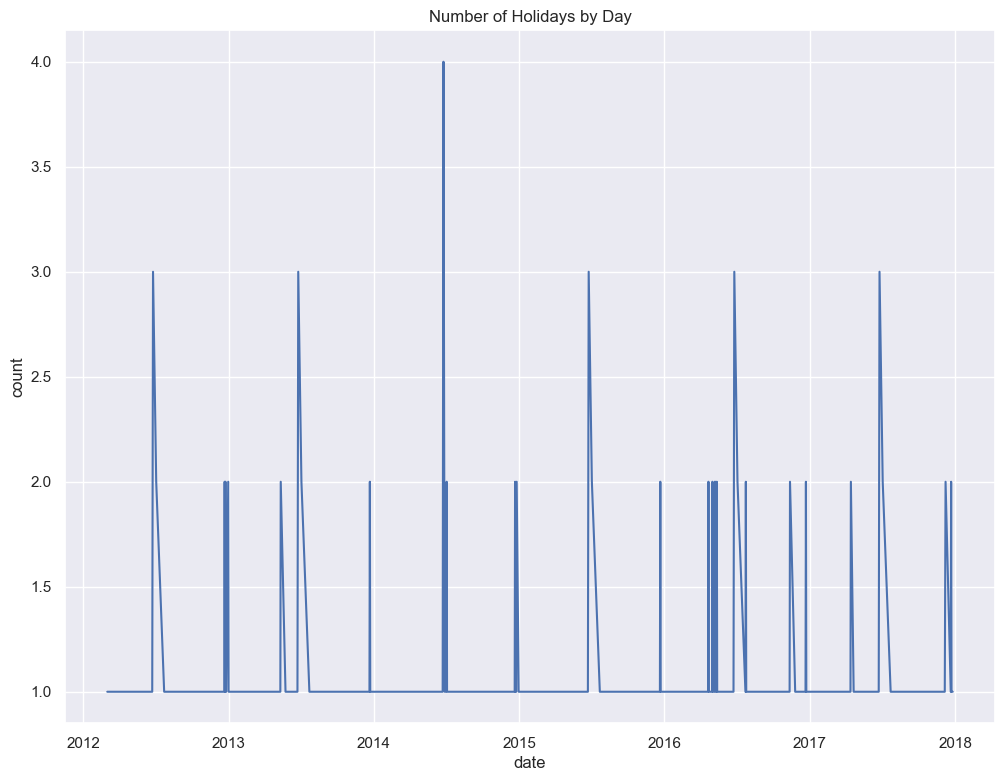

In [74]:
tmp = holidays_events.reset_index()[['date','description']].groupby('date').count().rename(columns={'description':'count'})

# plot
sns.set_theme()
sns.lineplot(
    x='date', y='count',
    data=tmp
).set(title='Number of Holidays by Day');

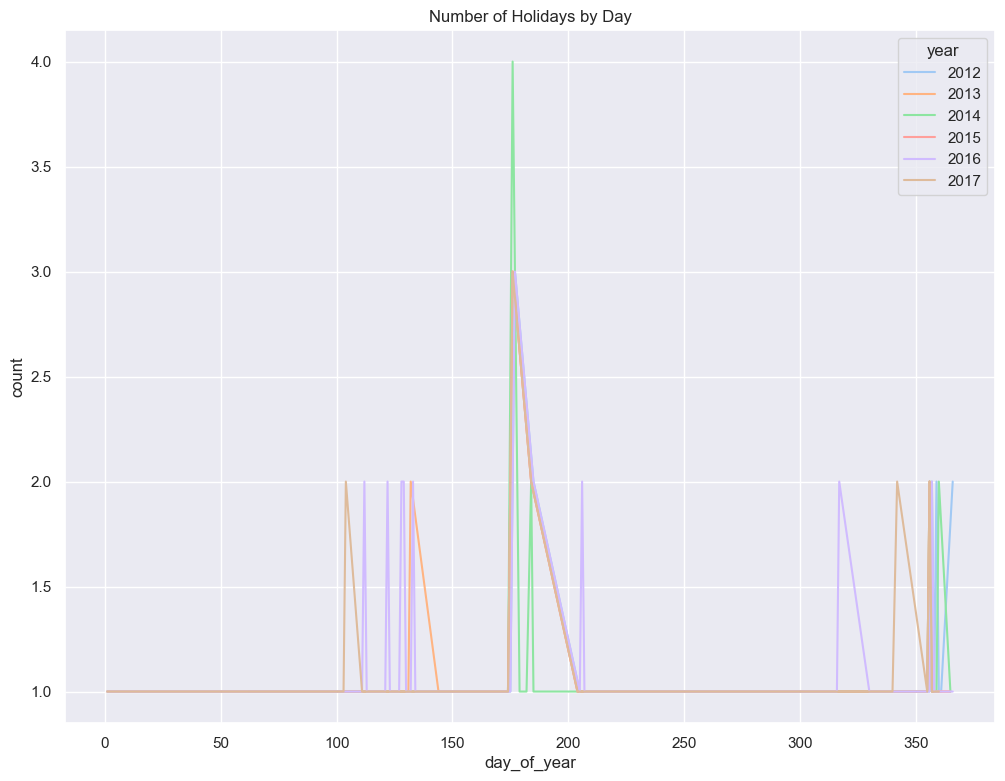

In [224]:
tmp = holidays_events.reset_index()[['day_of_year','year', 'description']].groupby(['day_of_year','year']).count().rename(columns={'description':'count'}).reset_index()

sns.set(rc={'figure.figsize':(12,9)})

sns.lineplot(
    x='day_of_year', 
    y='count',
    hue='year',
    data=tmp,
    palette='pastel'
).set(title='Number of Holidays by Day');

# pyplot.xticks(range(0,len(tmp),25));


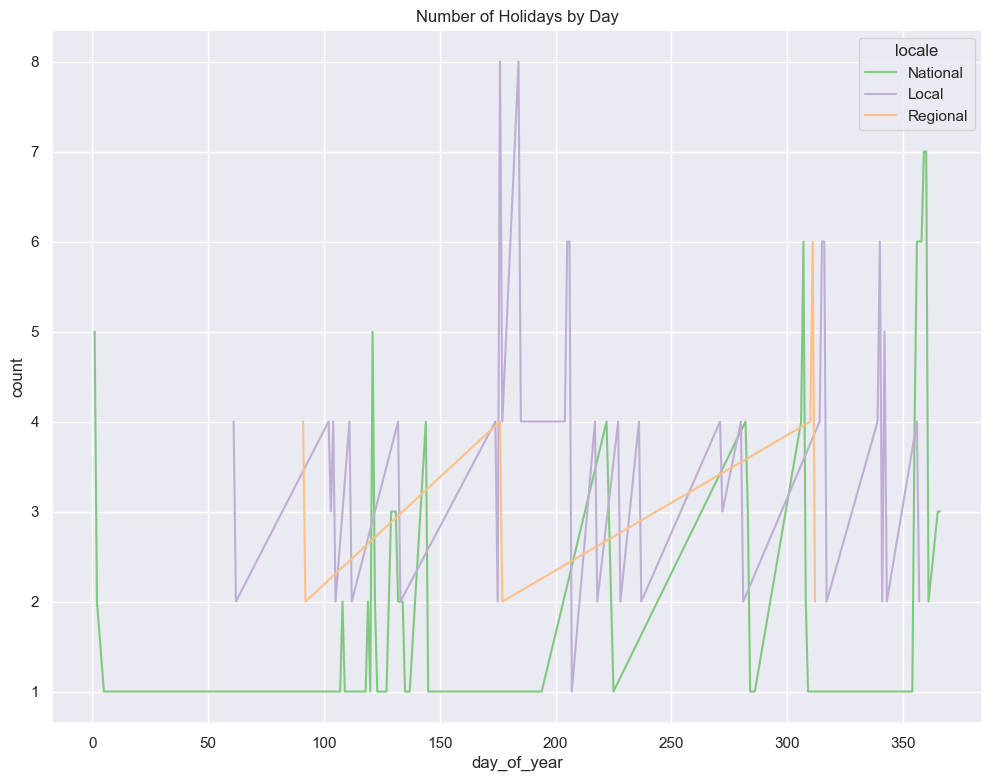

In [228]:
tmp = holidays_events.reset_index()[['day_of_year','locale', 'description']].groupby(['day_of_year','locale']).count().rename(columns={'description':'count'}).reset_index()

sns.set(rc={'figure.figsize':(12,9)})

sns.lineplot(
    x='day_of_year', 
    y='count',
    hue='locale',
    data=tmp,
    palette='Accent'
).set(title='Number of Holidays by Day');

# pyplot.xticks(range(0,len(tmp),25));


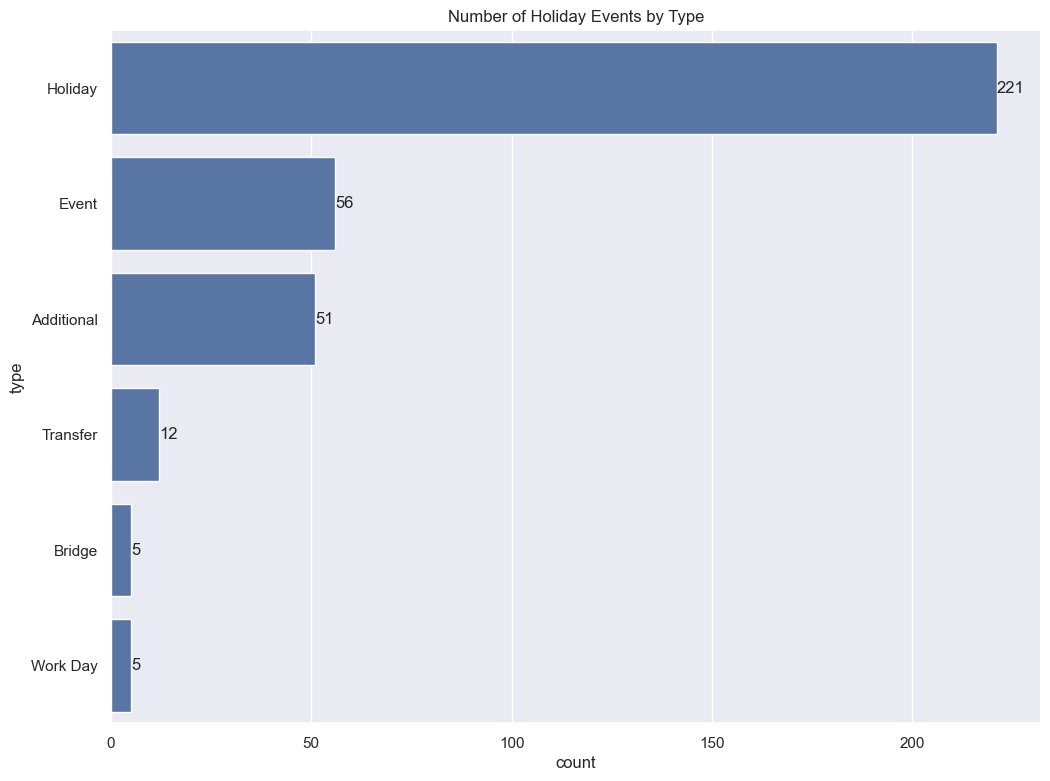

In [252]:
sns.set_theme()
ax = sns.countplot(
    y='type',
    data=holidays_events,
    order=holidays_events['type'].value_counts().index
)
ax.set(title='Number of Holiday Events by Type')
ax.bar_label(ax.containers[0]);

[Text(0, 0, '174'), Text(0, 0, '152'), Text(0, 0, '24')]

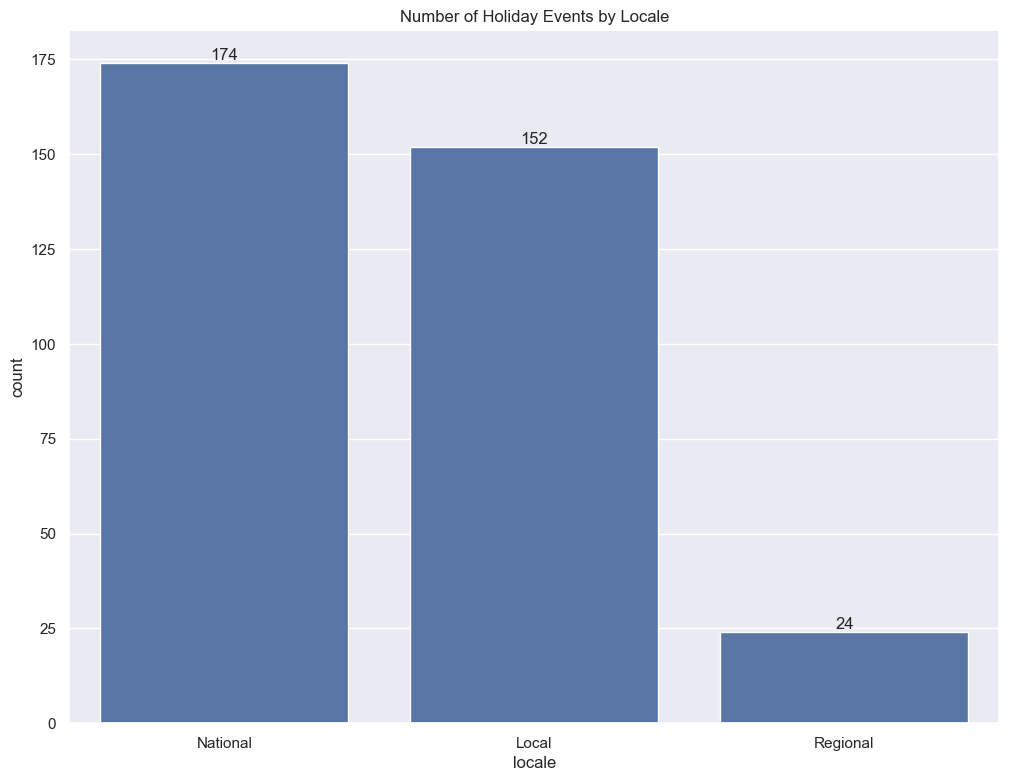

In [253]:
sns.set_theme()
ax = sns.countplot(
    x='locale',
    data=holidays_events,
    order=holidays_events['locale'].value_counts().index
)
ax.set(title='Number of Holiday Events by Locale')
ax.bar_label(ax.containers[0])

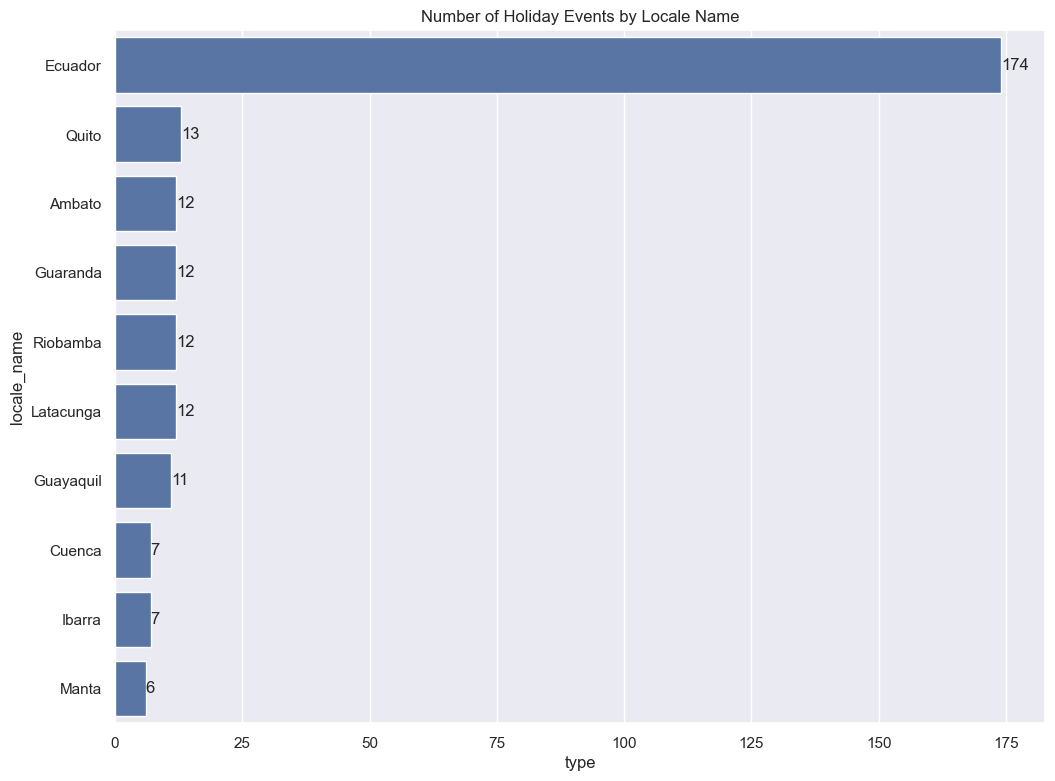

In [254]:
sns.set_theme()
top10_locale_names = holidays_events[['locale_name','type']].groupby(['locale_name']).count().sort_values(by=['type'], ascending=[False]).reset_index()[:10]

ax = sns.barplot(
    top10_locale_names, 
    x='type', 
    y='locale_name')
ax.set(title='Number of Holiday Events by Locale Name')
ax.bar_label(ax.containers[0]);

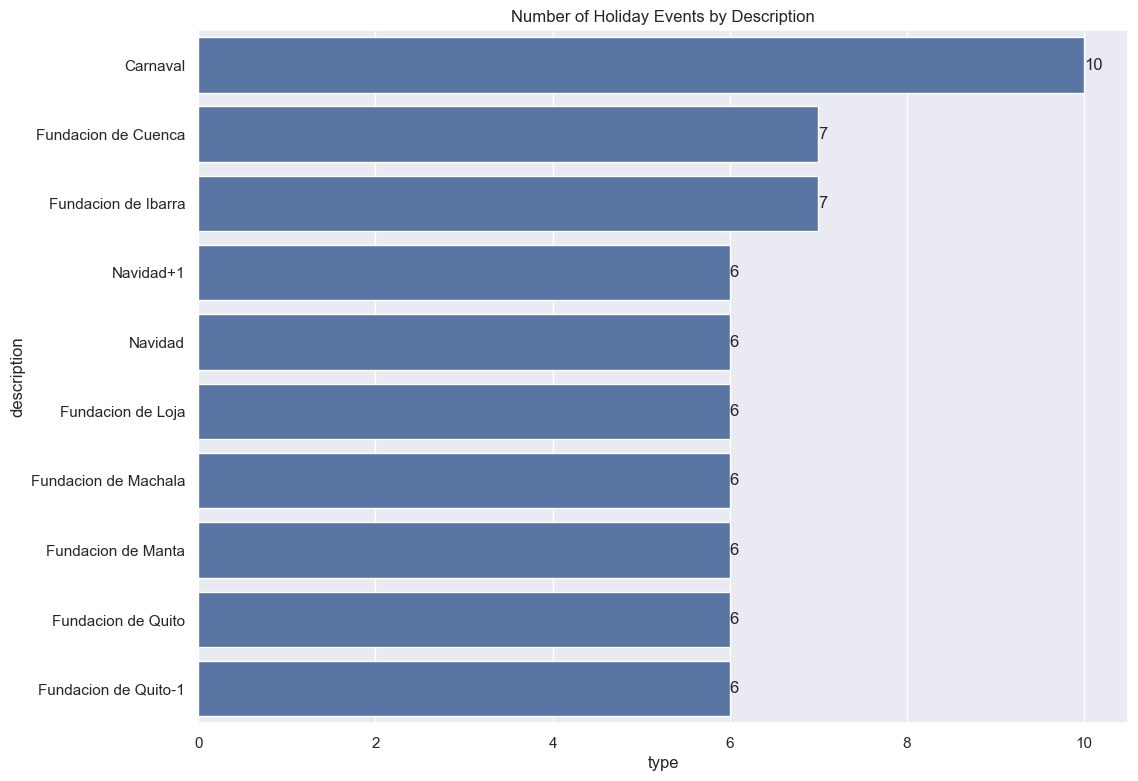

In [255]:
sns.set_theme()
top10_descriptions_names = holidays_events[['description','type']].groupby(['description']).count().sort_values(by=['type'], ascending=[False]).reset_index()[:10]

ax = sns.barplot(top10_descriptions_names, x='type', y='description')
ax.set(title='Number of Holiday Events by Description')
ax.bar_label(ax.containers[0]);

## Transactions

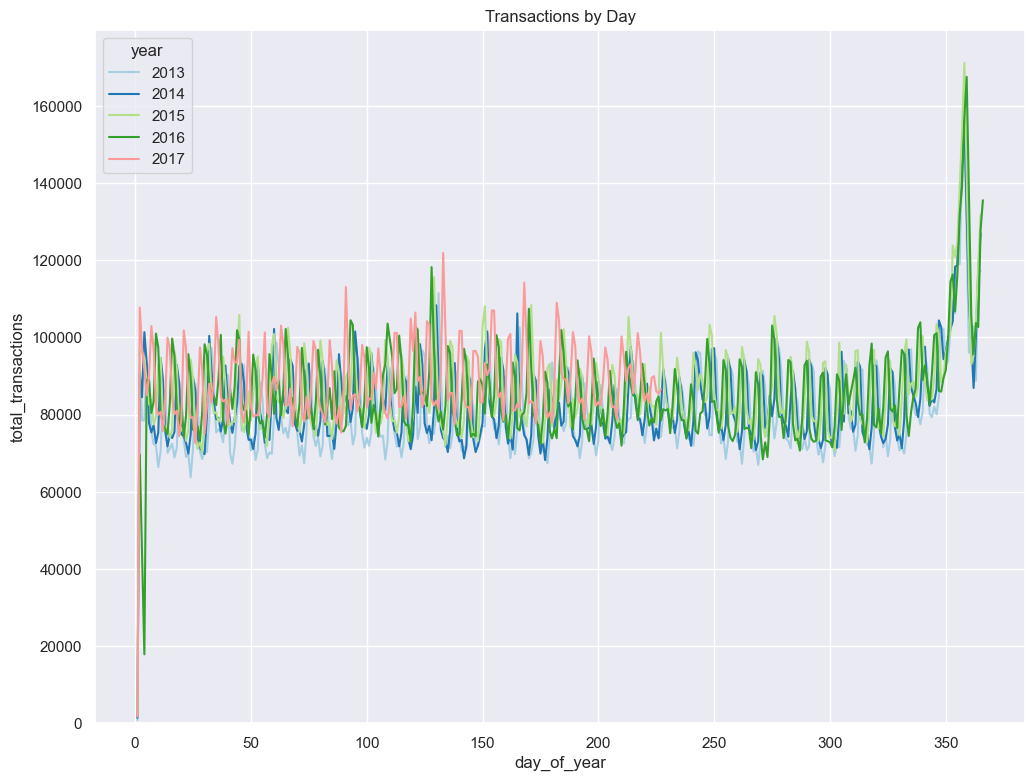

In [353]:
tmp = transactions.reset_index()[['day_of_year','year', 'transactions']].groupby(['day_of_year','year']).sum().rename(columns={'transactions':'total_transactions'}).reset_index()

sns.set(rc={'figure.figsize':(12,9)})
ax = sns.lineplot(
    x='day_of_year', 
    y='total_transactions',
    hue='year',
    data=tmp,
    palette='Paired',
    # alpha=.5
)
ax.set(title='Transactions by Day')
ax.set(ylim=(0, None));

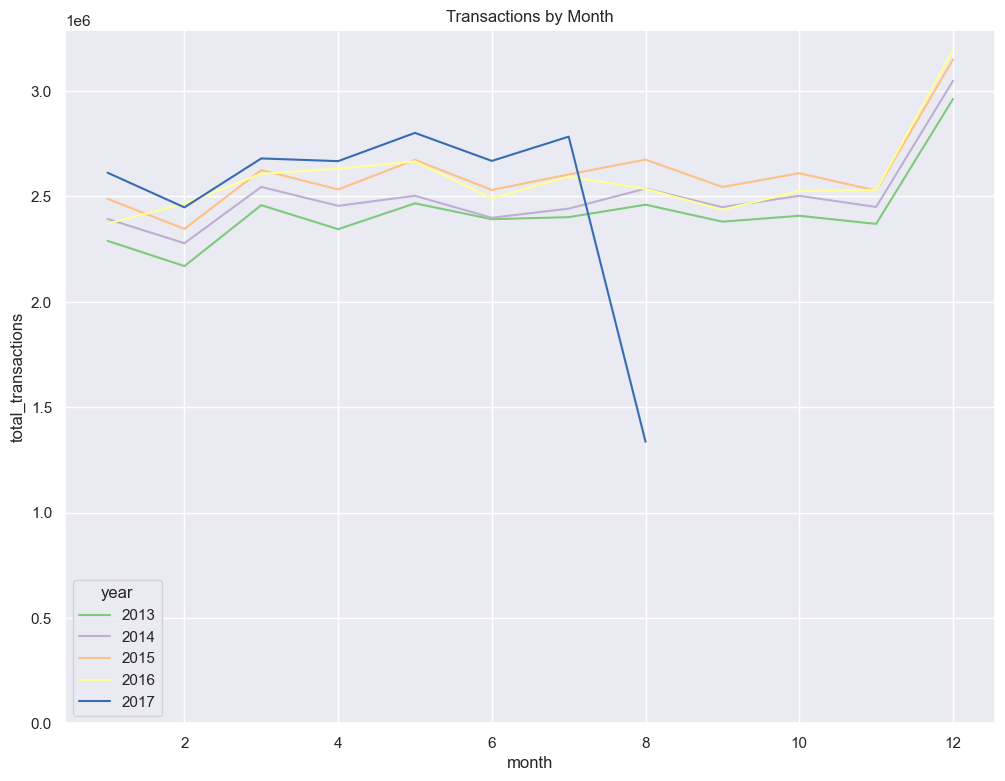

In [278]:
tmp = transactions.reset_index()[['month','year', 'transactions']].groupby(['month','year']).sum().rename(columns={'transactions':'total_transactions'}).reset_index()

sns.set(rc={'figure.figsize':(12,9)})
ax = sns.lineplot(
    x='month', 
    y='total_transactions',
    hue='year',
    data=tmp,
    palette='Accent',
    # alpha=.5
)
ax.set(title='Transactions by Month')
ax.set(ylim=(0, None));

[Text(0.5, 1.0, 'Total Transactions by Store Number')]

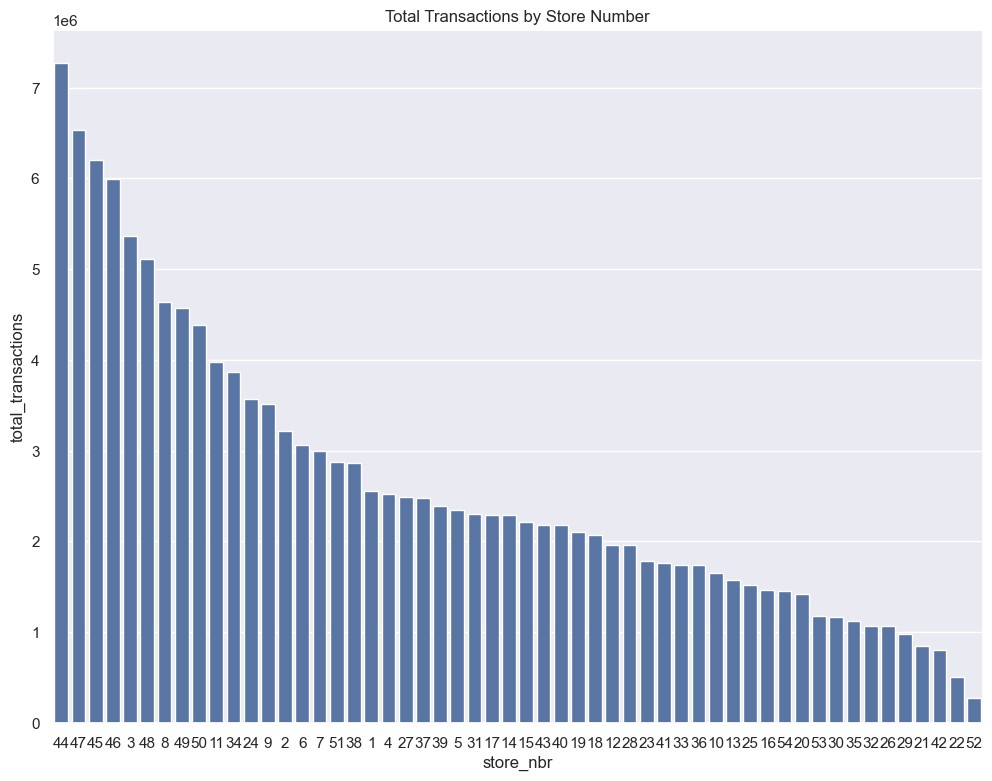

In [331]:
tmp = transactions.reset_index()\
    [['store_nbr', 'transactions']].\
        groupby(['store_nbr']).sum().\
            rename(columns={'transactions':'total_transactions'}).\
                sort_values(by=['total_transactions'], ascending=[False]).\
                    reset_index()
tmp.sort_values(by=['total_transactions'],ascending=[False])[:10]


# sns.set(rc={'figure.figsize':(12,9)})
# ax = sns.barplot(top10_descriptions_names, x='store', y='description')


ax = sns.barplot(
    data=tmp,
    x='store_nbr',
    y='total_transactions', 
    order=tmp['store_nbr'],
    # palette='Accent',
    # alpha=.5
)
# ax.bar_label(ax.containers[0])
ax.set(title='Total Transactions by Store Number')
# ax.set(ylim=(0, None));

## Oil

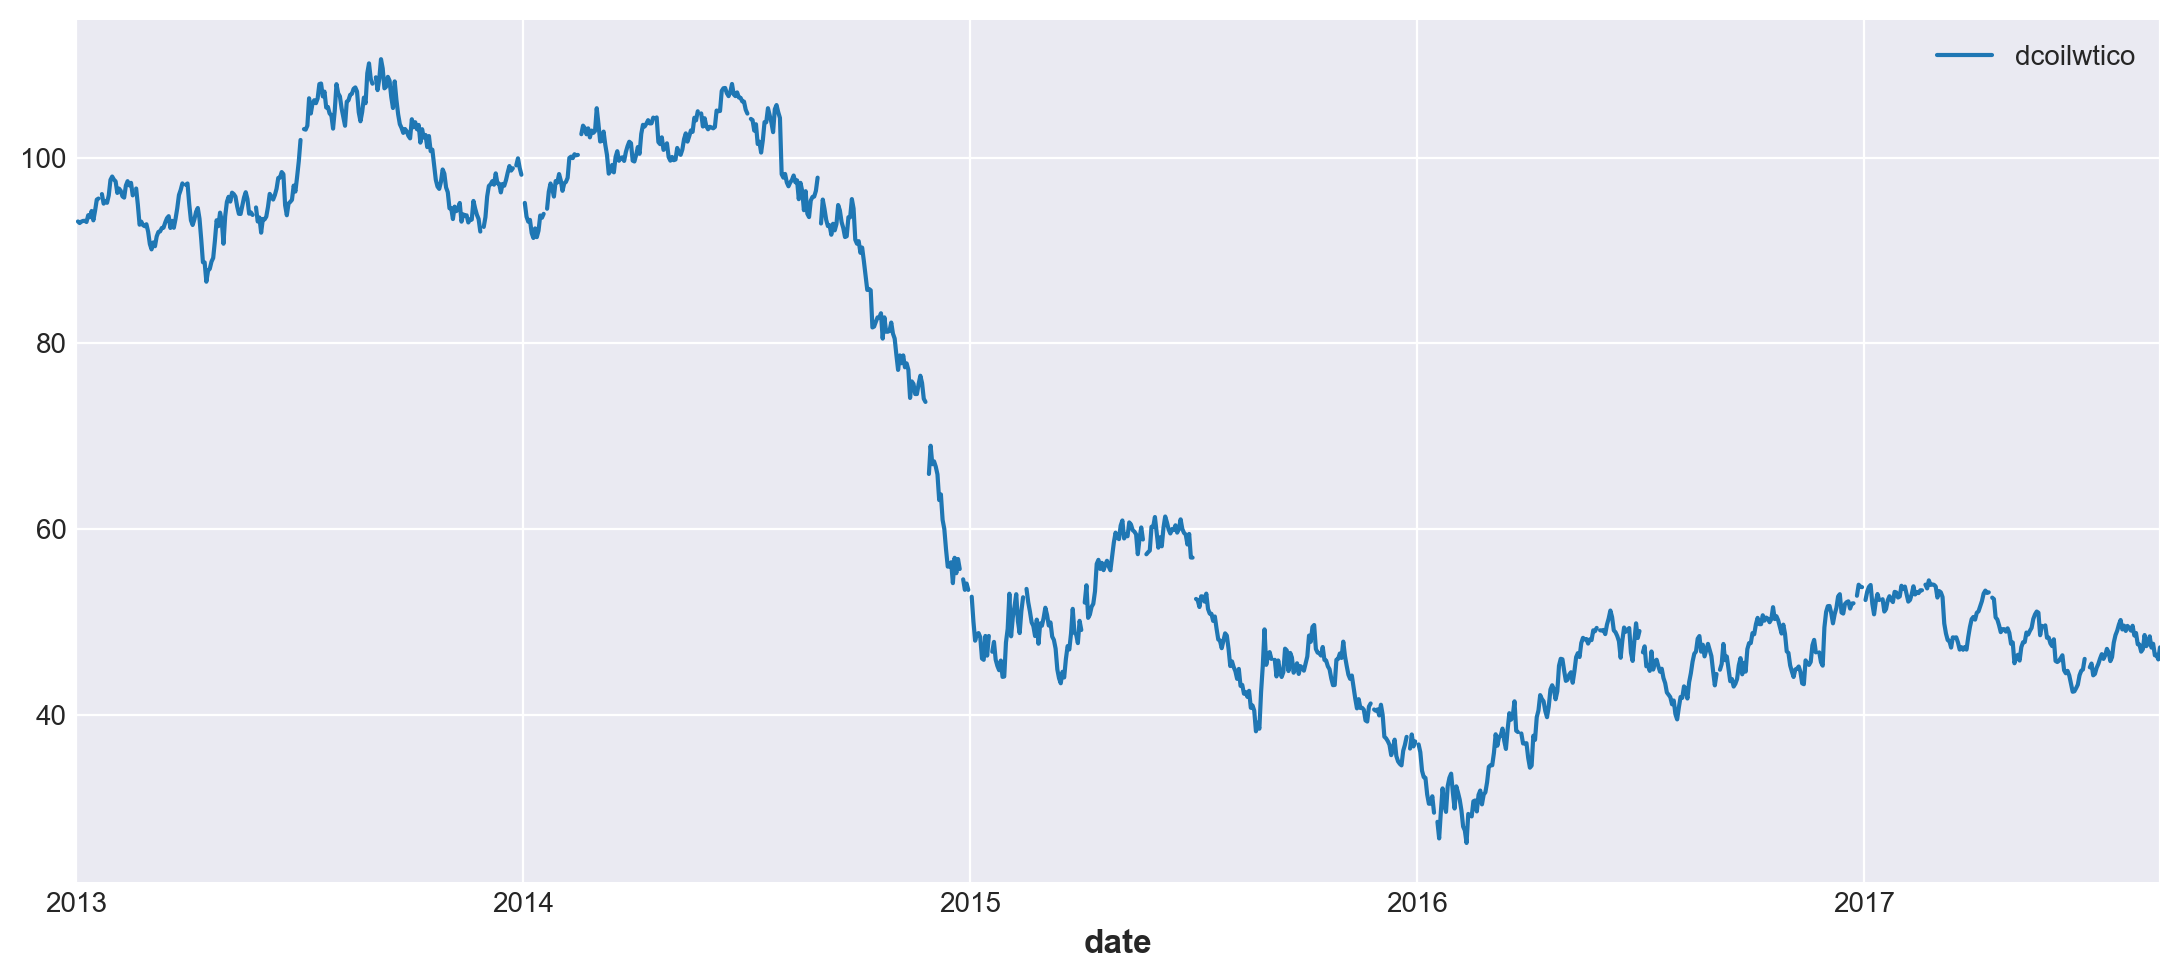

In [250]:
oil.plot();

[Text(0.5, 1.0, 'Oil Price (Interpolated) Over Time')]

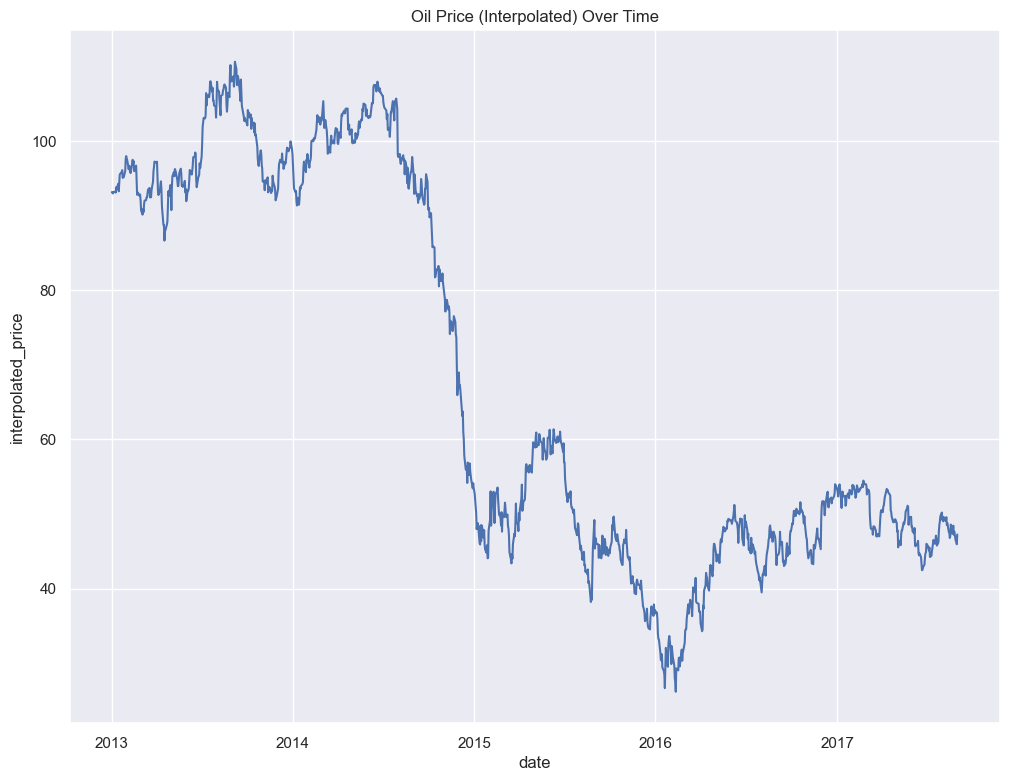

In [37]:
sns.set_theme()
sns.lineplot(
    x='date', y='interpolated_price',
    data=oil.reset_index()
).set(title='Oil Price (Interpolated) Over Time')

explore relationship between daily total sales and oil price

[Text(0.5, 1.0, 'Regression Plot\nDaily Oil Price & Total Sales')]

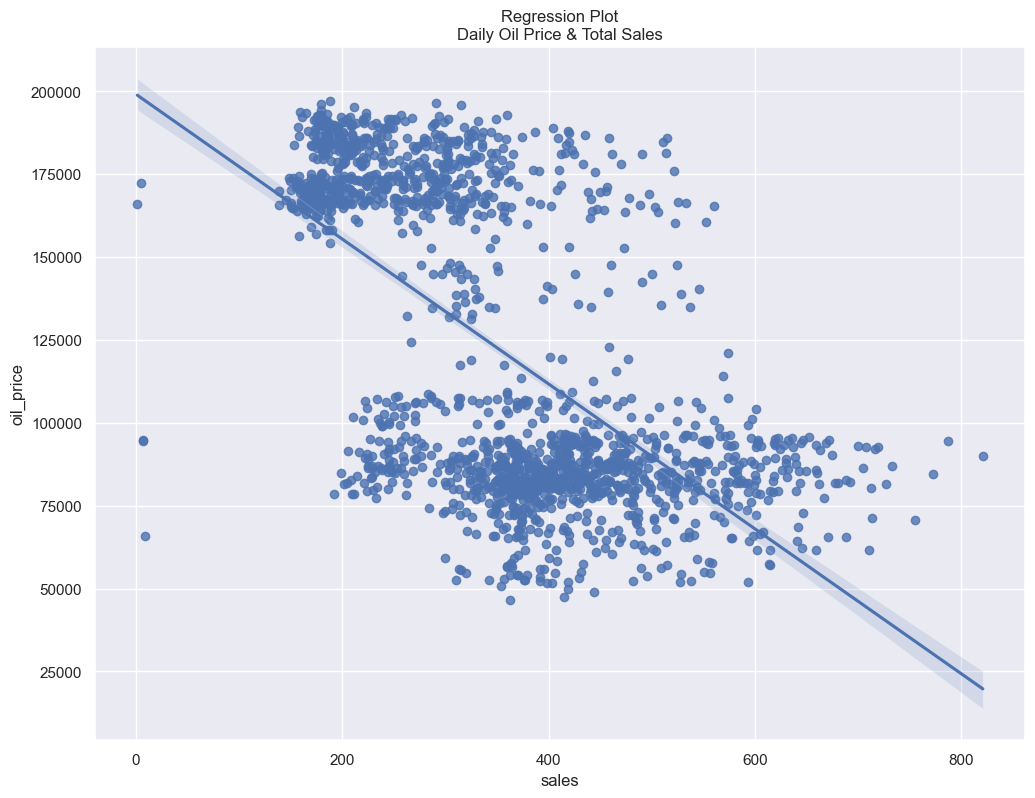

In [60]:
tmp = train_engineered.reset_index()[['date', 'sales', 'oil_price']]
tmp1 = tmp.groupby(['date']).agg({'sales': 'mean', 'oil_price': 'sum'})
tmp1['year'] = tmp1.reset_index().date.dt.year.astype("int32").tolist()

# log
# tmp1['sales'] = np.log10(tmp1['sales'])
# tmp1['oil_price'] = np.log10(tmp1['oil_price'])

sns.set_theme()
sns.regplot(
    data=tmp1,
    x='sales',
    y='oil_price',
    # hue='year',
    # palette='GnBu'
).set(title=f'Regression Plot\nDaily Oil Price & Total Sales')

[Text(0.5, 1.0, 'Scatter Plot\nDaily Oil Price & Total Sales')]

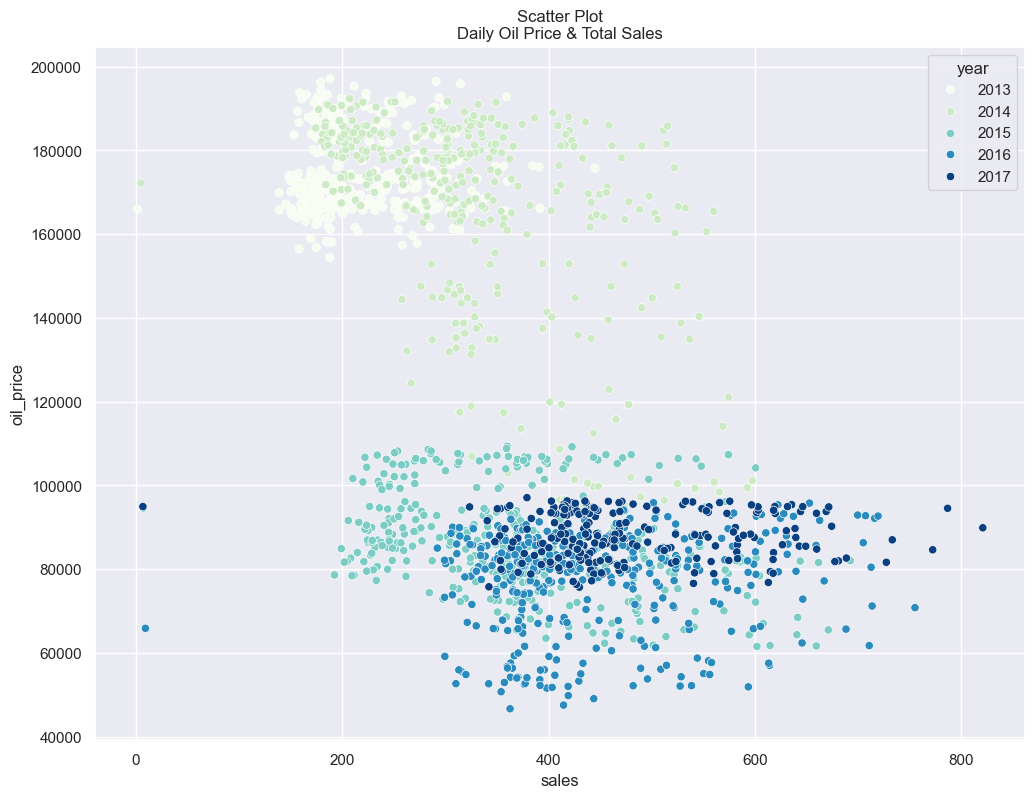

In [61]:
tmp = train_engineered.reset_index()[['date', 'sales', 'oil_price']]
tmp1 = tmp.groupby(['date']).agg({'sales': 'mean', 'oil_price': 'sum'})
tmp1['year'] = tmp1.reset_index().date.dt.year.astype("int32").tolist()

# log
# tmp1['sales'] = np.log10(tmp1['sales'])
# tmp1['oil_price'] = np.log10(tmp1['oil_price'])

sns.set_theme()
sns.scatterplot(
    data=tmp1,
    x='sales',
    y='oil_price',
    hue='year',
    palette='GnBu'
).set(title=f'Scatter Plot\nDaily Oil Price & Total Sales')

## Train

best-selling product families

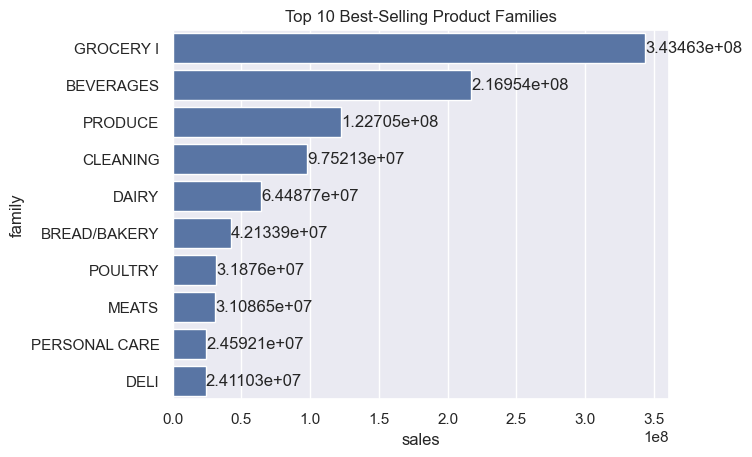

In [65]:
tmp = train_engineered.reset_index()[['family','sales']].groupby(['family']).sum('sales').reset_index().sort_values(by=['sales'], ascending=False)
best_selling_fam = tmp[:10]['family']

ax = sns.barplot(tmp[:10], y='family', x='sales')
ax.set_title('Top 10 Best-Selling Product Families')
ax.bar_label(ax.containers[0]);

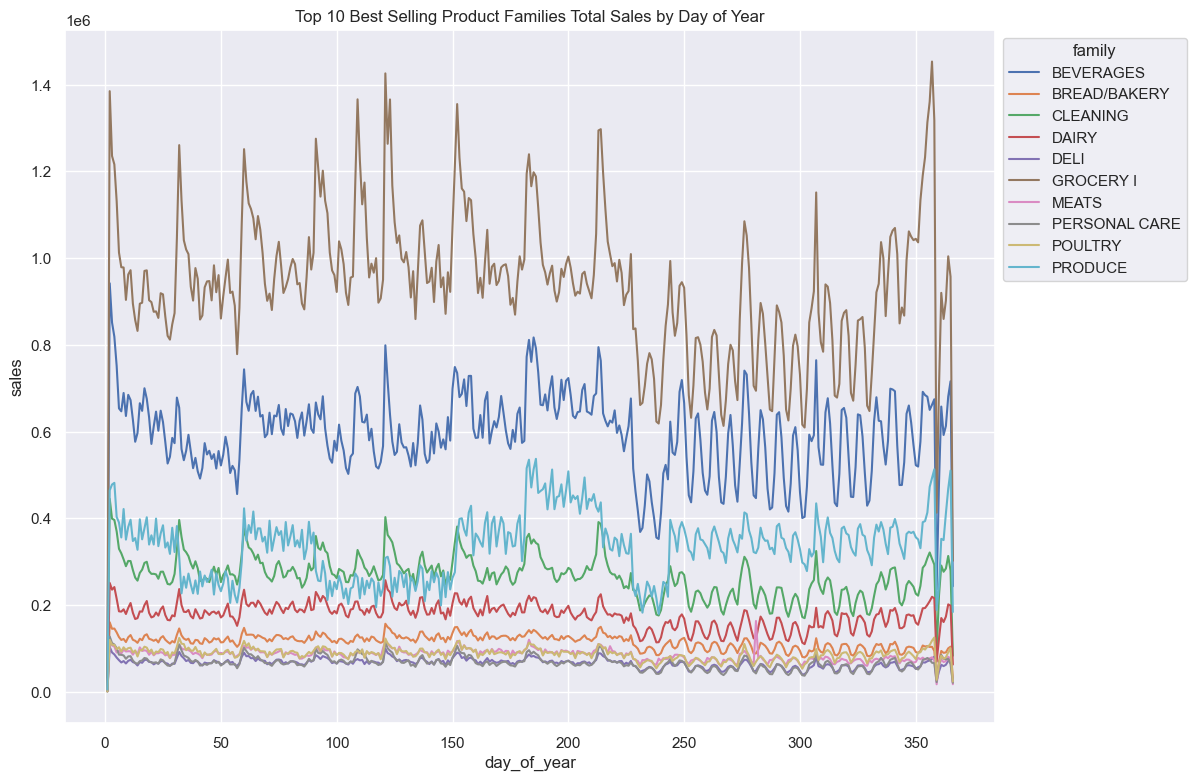

In [358]:
tmp = train_engineered.reset_index()[['family','sales']].groupby(['family']).sum('sales').reset_index().sort_values(by=['sales'], ascending=False)
best_selling_fam = tmp[:10]['family']

tmp2 = train_engineered.reset_index()[['day_of_year','family','sales']].groupby(['day_of_year', 'family']).sum('sales').reset_index()
tmp2 = tmp2[tmp2['family'].isin(best_selling_fam)]

ax=sns.lineplot(tmp2, x='day_of_year', y='sales', hue='family')
ax.set_title('Top 10 Best Selling Product Families Total Sales by Day of Year')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

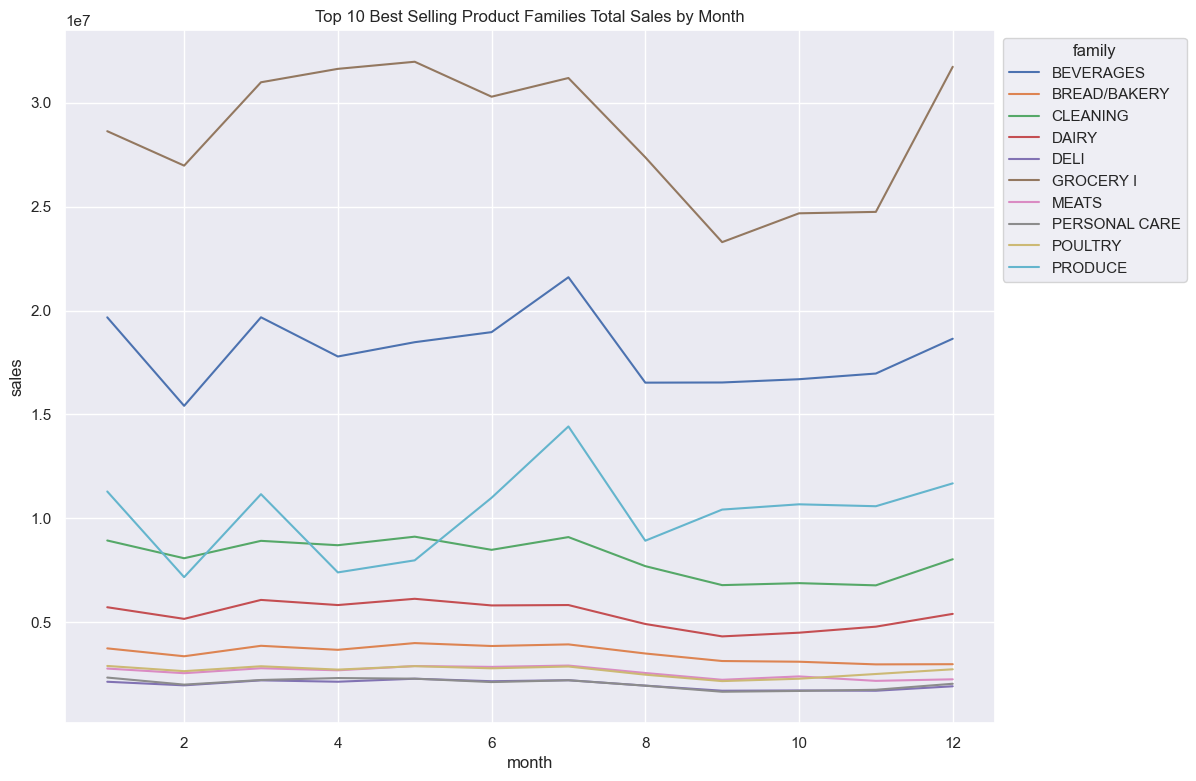

In [359]:
tmp = train_engineered.reset_index()[['family','sales']].groupby(['family']).sum('sales').reset_index().sort_values(by=['sales'], ascending=False)
best_selling_fam = tmp[:10]['family']

tmp2 = train_engineered.reset_index()[['month','family','sales']].groupby(['month', 'family']).sum('sales').reset_index()
tmp2 = tmp2[tmp2['family'].isin(best_selling_fam)]

ax=sns.lineplot(tmp2, x='month', y='sales', hue='family')
ax.set_title('Top 10 Best Selling Product Families Total Sales by Month')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

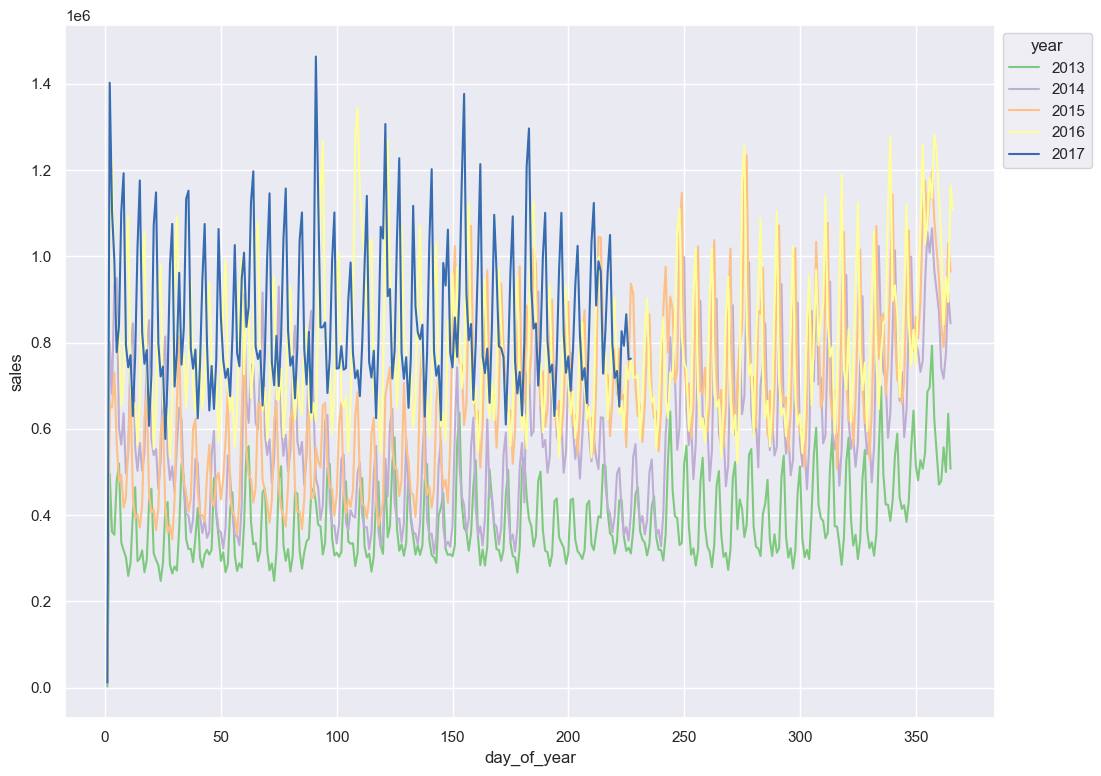

In [357]:
tmp3 = train_engineered.reset_index()[['day_of_year','sales', 'year']].groupby(['day_of_year', 'year']).sum('sales').reset_index()


ax=sns.lineplot(tmp3, x='day_of_year', y='sales', hue='year', palette='Accent')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

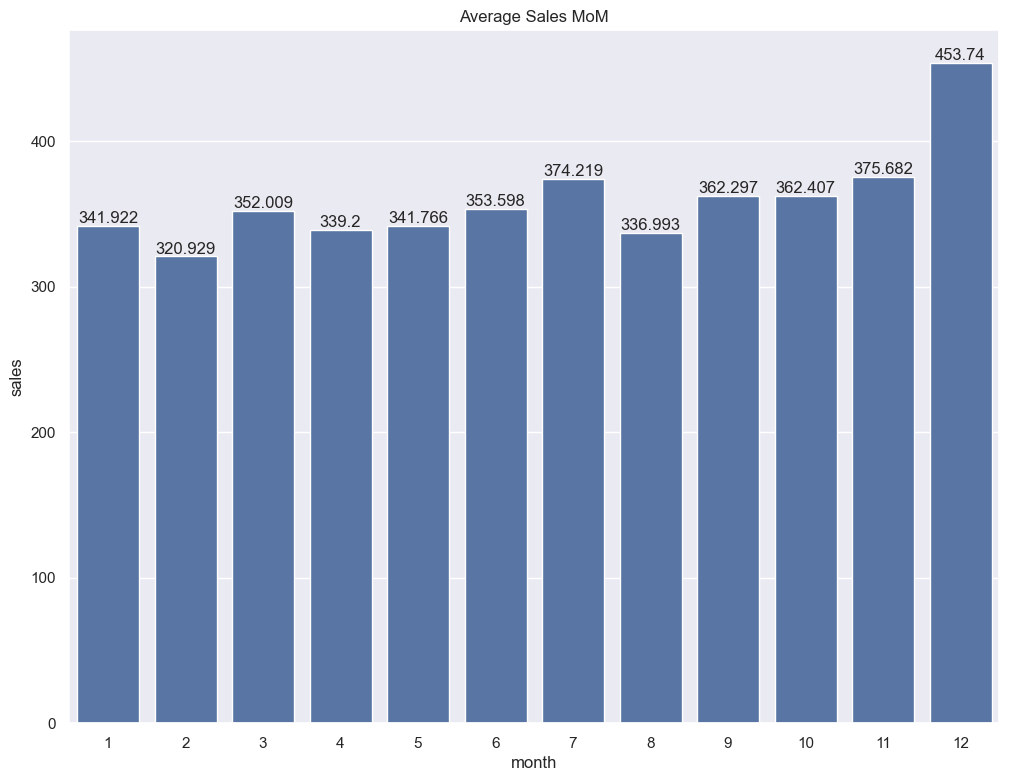

In [140]:
tmp =train_engineered[['sales', 'month']].groupby('month').mean().reset_index()


ax = sns.barplot(tmp, x='month', y='sales', )
# ax.set(ylabel=None)
ax.set_title('Average Sales MoM')
ax.bar_label(ax.containers[0]);

Text(0.5, 1.0, 'Average Sales MoM (2013-2017)')

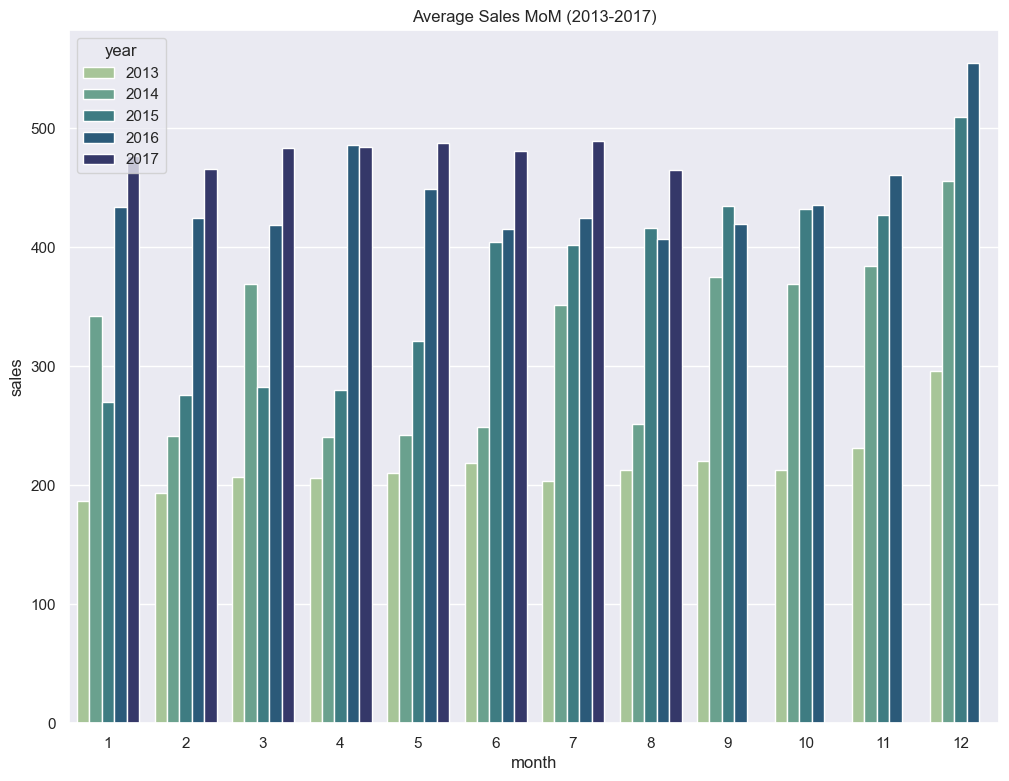

In [138]:
tmp =train_engineered[['sales', 'month','year']].groupby(['year', 'month']).mean().reset_index()

sns.set_theme()
ax = sns.barplot(data=tmp, x='month', y='sales', hue='year', palette='crest')
# ax = tmp.plot.bar(x='month', y='sales', color=cm.get_cmap('Spectral') )
# ax.set(ylabel=None)
ax.set_title('Average Sales MoM (2013-2017)')
# ax.bar_label(ax.containers[0]);

Text(0.5, 1.0, 'Average Sales MoM (2013-2017)')

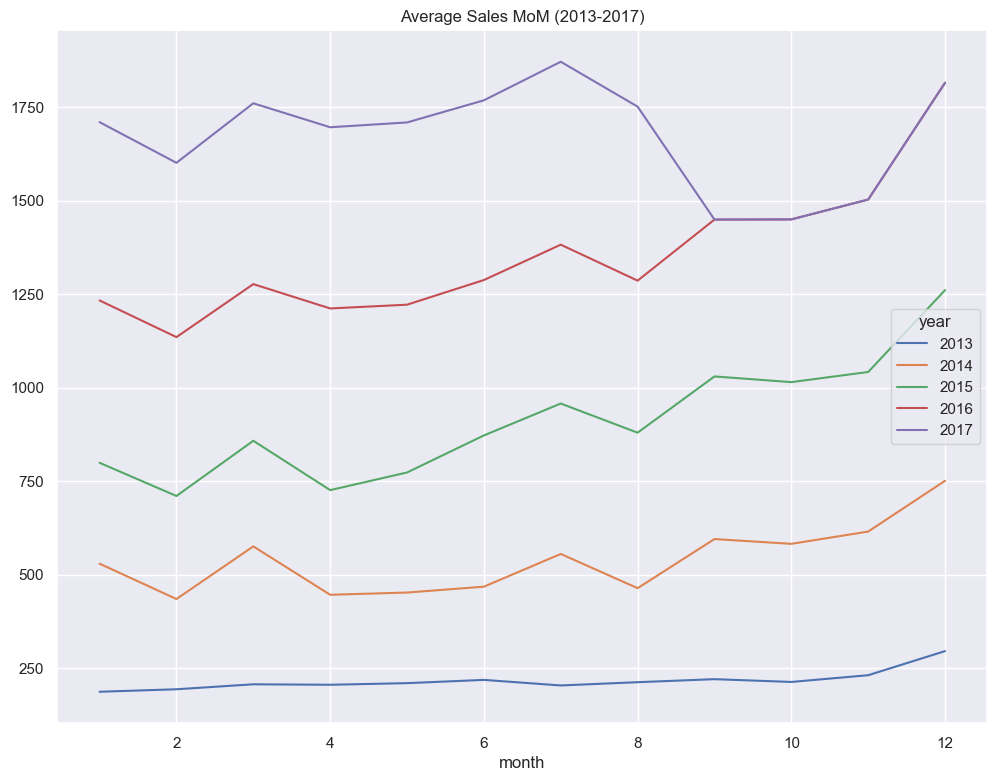

In [110]:
tmp = train_engineered[['sales', 'year', 'month']].groupby(['month','year']).mean().reset_index()
tmp = tmp.pivot(index='month', columns='year', values='sales')
# tmp['year'] = tmp['year'].astype('int')

sns.set_theme()
# tmp.T.plot(kind='bar', stacked=True,)
ax = tmp.plot(stacked=True)
ax.set_title('Average Sales MoM (2013-2017)')

## Stores

In [362]:
stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

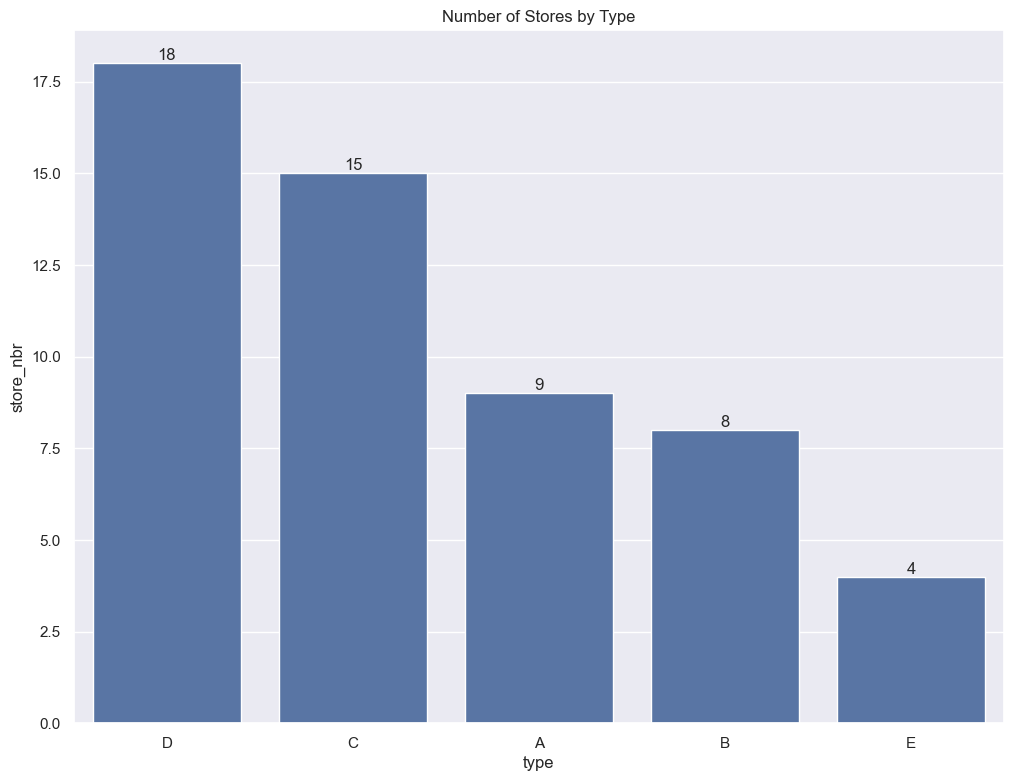

In [18]:
tmp = stores[['type', 'store_nbr']].groupby(['type']).count().reset_index().sort_values(by=['store_nbr'], ascending=[False])
ax= sns.barplot(
    x='type',
    y='store_nbr',
    order=tmp['type'],
    data=tmp
)
ax.bar_label(ax.containers[0])
ax.set(title='Number of Stores by Type');
# ax.set(ylim=(0, None));

In [8]:
tmp = stores[['city', 'store_nbr']].groupby(['city']).count().reset_index().sort_values(by=['store_nbr'], ascending=[False])

city  store_nbr
18          Quito         18
8       Guayaquil          8
21  Santo Domingo          3
3          Cuenca          3
14          Manta          2
13        Machala          2
10      Latacunga          2
0          Ambato          2
7        Guaranda          1
9          Ibarra          1

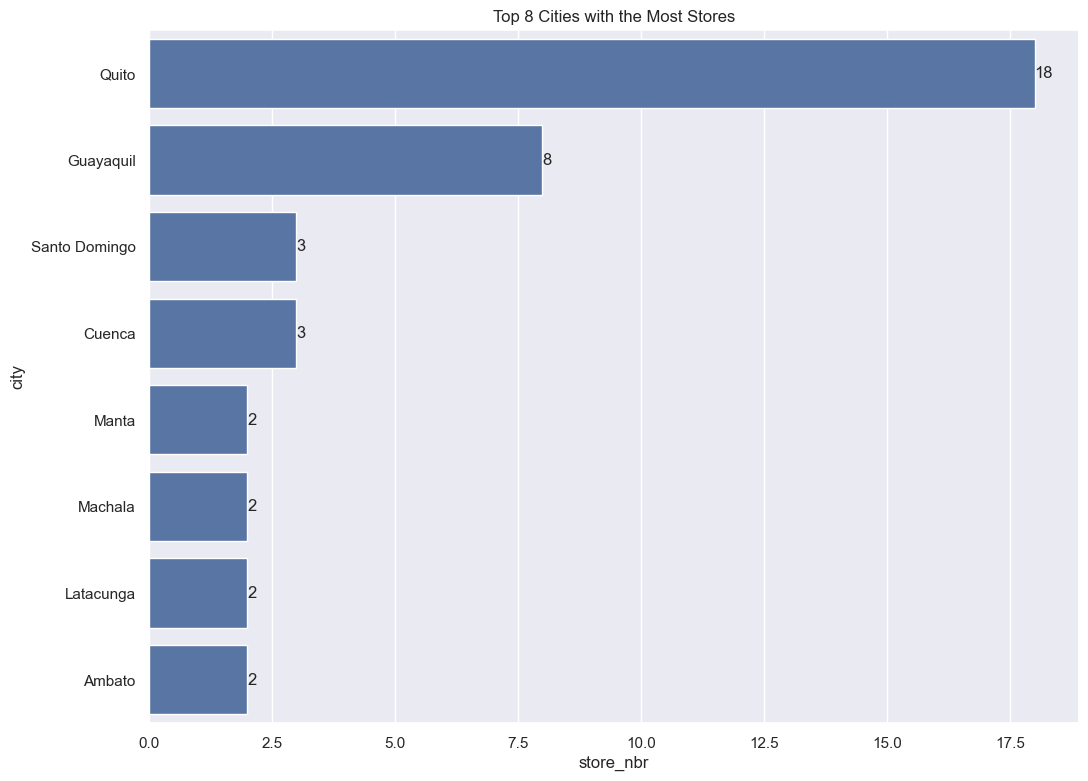

In [19]:
tmp = stores[['city', 'store_nbr']].groupby(['city']).count().reset_index().sort_values(by=['store_nbr'], ascending=[False])
tmp = tmp[:8]

sns.set_theme()
sns.set(rc={'figure.figsize':(12,9)})

ax= sns.barplot(
    y='city',
    x='store_nbr',
    order=tmp['city'],
    data=tmp
)
ax.bar_label(ax.containers[0])
ax.set(title='Top 8 Cities with the Most Stores');
# ax.set(ylim=(0, None));

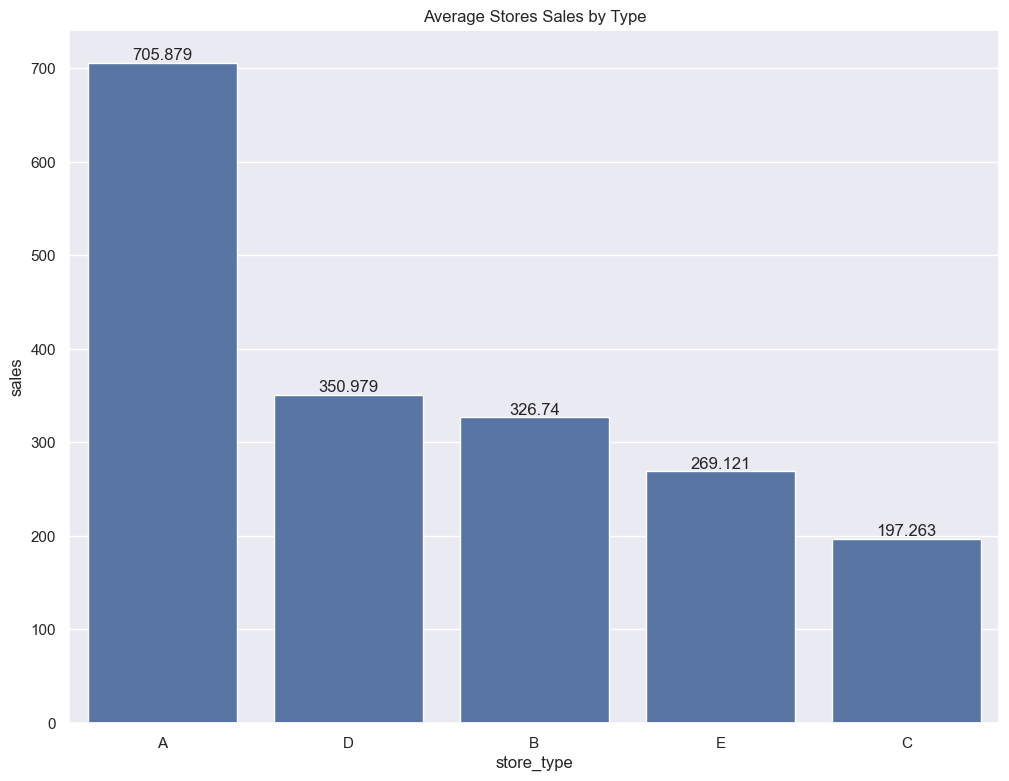

In [29]:
tmp = train_engineered.reset_index()[['sales','store_nbr','city', 'state','store_type', 'store_cluster']]
tmp1 = tmp[['sales', 'store_type']].groupby(['store_type']).mean().reset_index().sort_values(by=['sales'], ascending=False)

ax= sns.barplot(
    x='store_type',
    y='sales',
    order=tmp1['store_type'],
    data=tmp1
)
ax.bar_label(ax.containers[0])
ax.set(title='Average Stores Sales by Type');
# ax.set(ylim=(0, None));

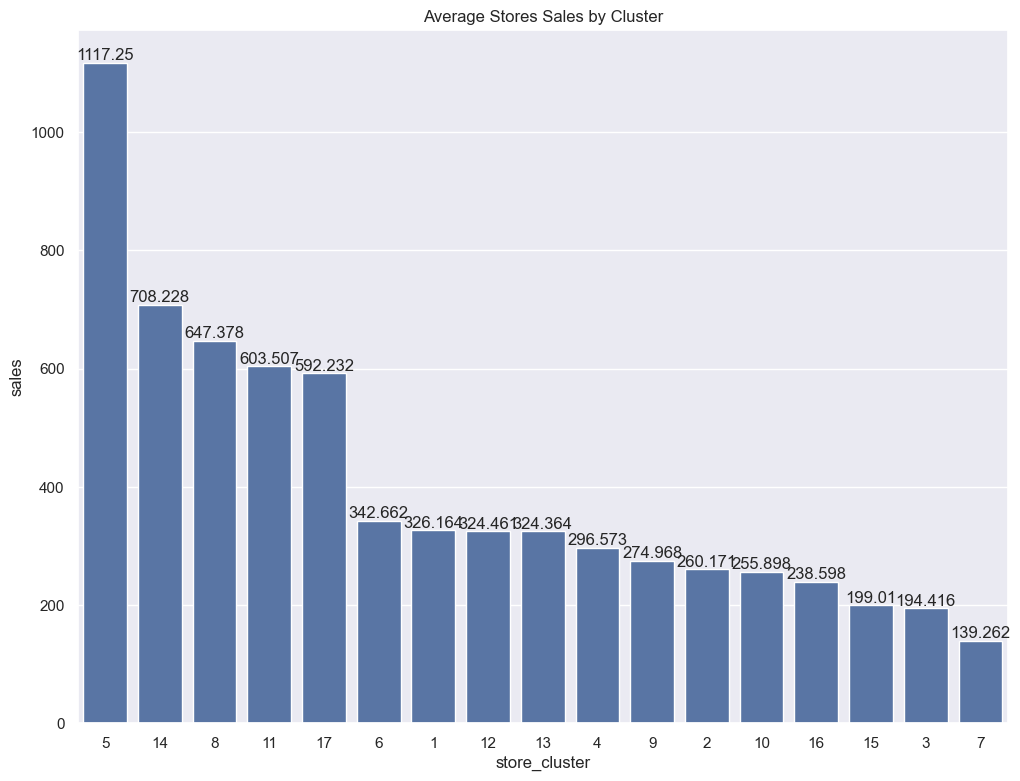

In [30]:
tmp = train_engineered.reset_index()[['sales','store_nbr','city', 'state','store_type', 'store_cluster']]
tmp1 = tmp[['sales', 'store_cluster']].groupby(['store_cluster']).mean().reset_index().sort_values(by=['sales'], ascending=False)

ax= sns.barplot(
    x='store_cluster',
    y='sales',
    order=tmp1['store_cluster'],
    data=tmp1
)
ax.bar_label(ax.containers[0])
ax.set(title='Average Stores Sales by Cluster');
# ax.set(ylim=(0, None));

## Spearman Correlation

In [58]:
train_engineered.columns[10:30]

Index(['store_type', 'store_cluster', 'oil_price', 'type', 'holiday_locale',
       'description', 'transferred', 'if_holiday', 'month', 'day_of_month',
       'day_of_year', 'week_of_month', 'day_of_week', 'year', 'is_wknd',
       'quarter', 'is_month_start', 'is_month_end', 'is_year_start',
       'is_year_end'],
      dtype='object')

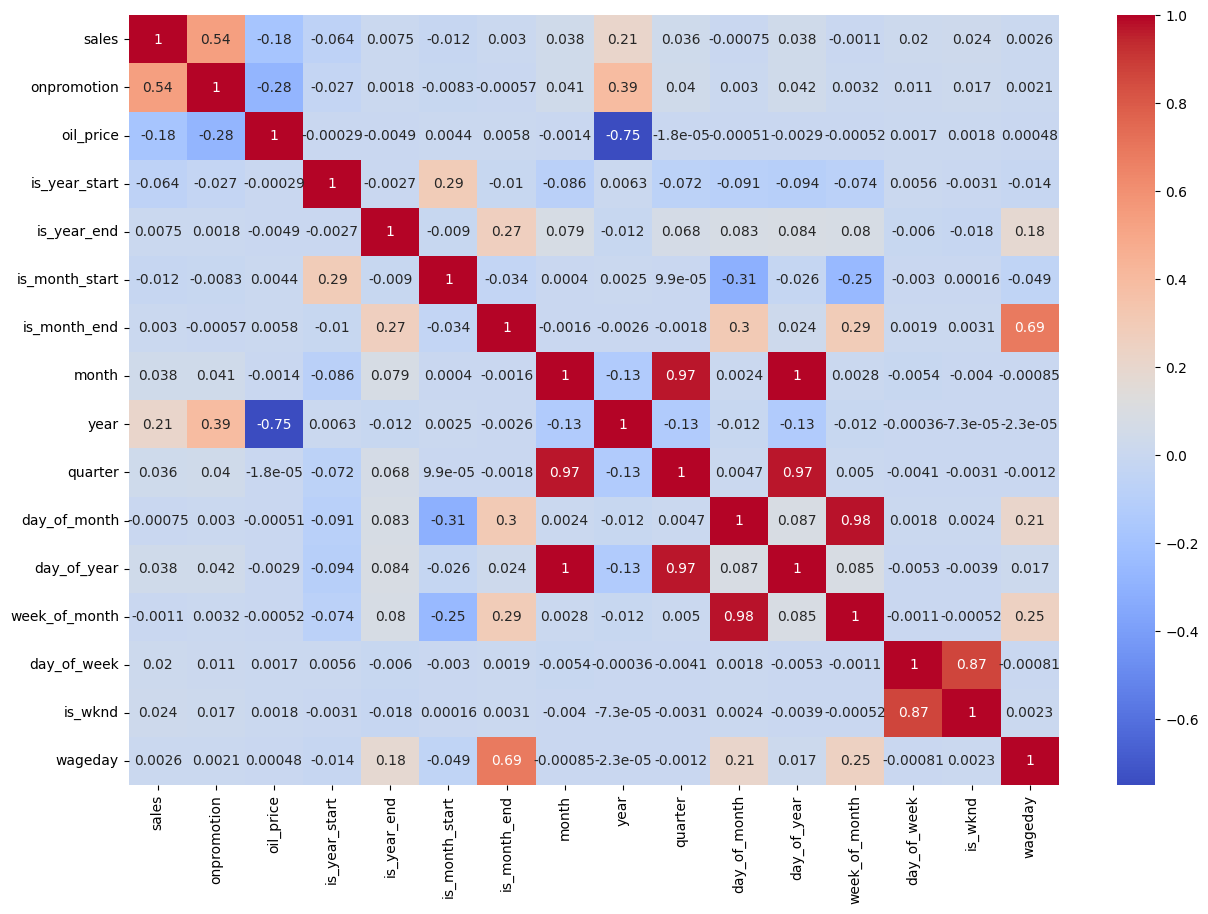

In [62]:
corr = train_engineered[['sales','onpromotion','oil_price', 
    'is_year_start','is_year_end',
    'is_month_start','is_month_end',
    'month','year', 'quarter',
    'day_of_month','day_of_year',
    'week_of_month','day_of_week','is_wknd',
    'wageday']].corr(method = 'spearman')

fig, ax = pyplot.subplots(figsize=(15,10))
sns.heatmap(corr, annot = True, cmap='coolwarm');

<Axes: >

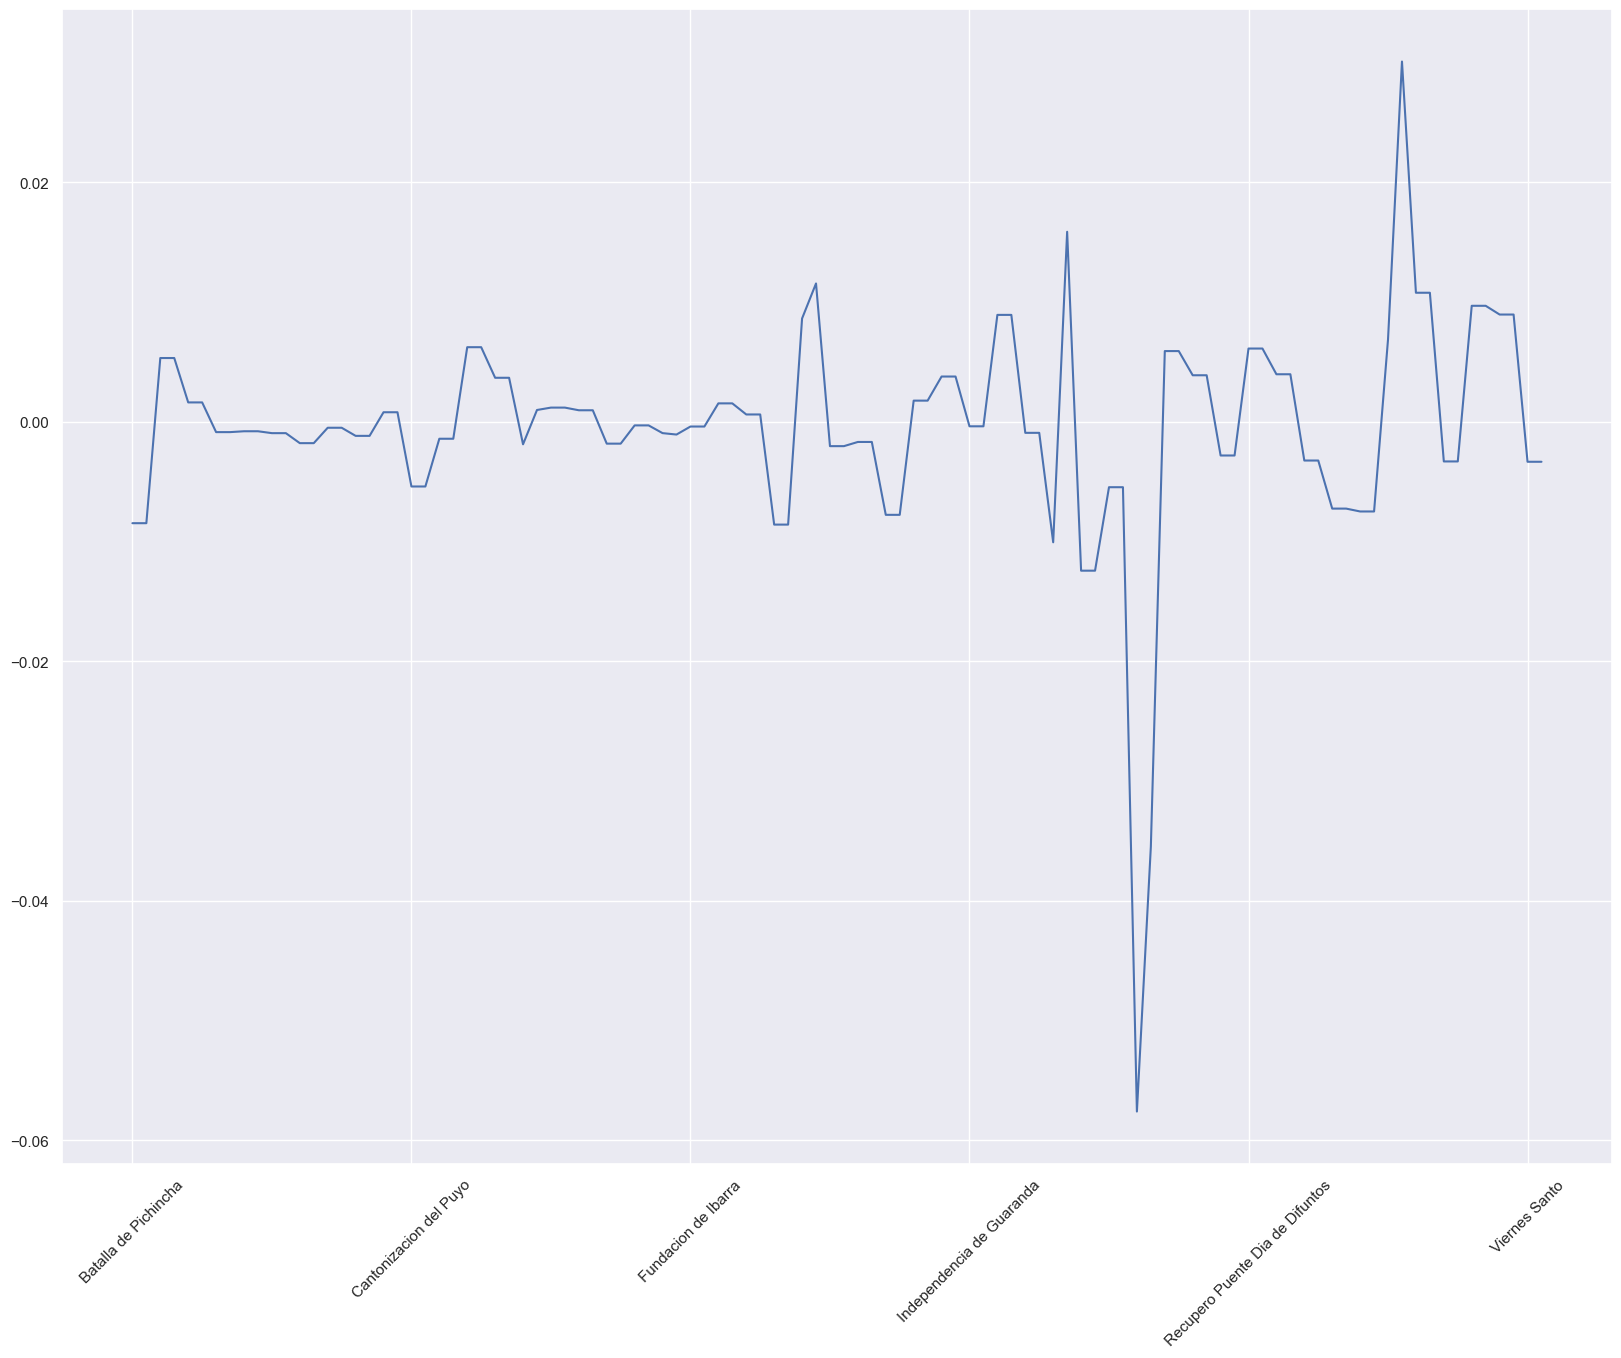

In [111]:
# tmp = pd.DataFrame()
# tmp['+'] = train_engineered['description'].str.split('+')
# tmp['res1'] = tmp['+'].apply(lambda x:x[0])

# tmp['-'] = tmp['res1'].str.split('-')
# tmp['res2'] = tmp['-'].apply(lambda x:x[0])

# tmp[':'] = tmp['res2'].str.split(':')
# tmp['res3'] = tmp[':'].apply(lambda x:x[0])

# description_dummy_df = pd.get_dummies(tmp['res3'])
# description_dummy_lst = description_dummy_df.columns.tolist()   # save for later


cols = ['sales']
cols.extend(description_dummy_lst)

# calculate correlation
corr = train_engineered[cols].corrwith(train_engineered['sales'], method = 'spearman')

# plot
sns.set_theme()
corr[1:].plot(figsize=(20,15), rot=45)


In [98]:

# fig, ax = pyplot.subplots(figsize=(15,10))
# sns.heatmap(corr, annot = True, cmap='coolwarm');

# Understanding the Time Series

### A little more data engineering

In [176]:
tmp = train_engineered.reset_index()
tmp = tmp[['sales','family','store_nbr']].groupby(['family', 'store_nbr']).sum().reset_index()
tmp = tmp.sort_values(by='sales', ascending=False)

fam_lst = tmp[:2]['family'].tolist()
fam_lst.extend(tmp[-2:]['family'].tolist())
store_lst = tmp[:2]['store_nbr'].astype(str).tolist()
store_lst.extend(tmp[-2:]['store_nbr'].astype(str).tolist())

# create a list for the top 10 store num + family combo
i = 0
lst = []
while i < 4:
    uid = fam_lst[i] + '_' + store_lst[i]
    lst.append(uid)
    i += 1

# lst    

train_engineered = train_engineered.reset_index()
train_engineered['uid'] = train_engineered['family'].astype(str)+'_'+train_engineered['store_nbr'].astype(str)

In [178]:
national_dummy_df = pd.get_dummies(train_engineered['national_holidays'])
natioanl_dummy_lst = national_dummy_df.columns.tolist()   # save for later

regional_dummy_df = pd.get_dummies(train_engineered['regional_local_holidays'])
regional_dummy_lst = regional_dummy_df.columns.tolist()   # save for later

# put national & regional/local together
# description_dummy_df = pd.concat([national_dummy_df, regional_dummy_df], axis=1)
description_dummy_lst = natioanl_dummy_lst.copy()
description_dummy_lst.extend(regional_dummy_lst)


features_to_use = [
    'date','sales','onpromotion','oil_price', 'out_of_region',
    'is_year_start','is_year_end',  
    'day_of_year',
    'is_wknd','wageday'
]
features_to_use.extend(description_dummy_lst)

exog_vars = [item for item in features_to_use if item not in ['date','sales']]

In [180]:
df = train_engineered[train_engineered['uid']=='GROCERY I_44']

df = df[features_to_use]
df = df.set_index('date')

# set index freq
df = df.asfreq('d')
# print(test.index.freq)

# drop the nas for now
# df = df[~df.isna().any(axis=1)]

df[df.isna()] = 0 


# train test split
train = df.iloc[:round(len(df) * .8)+1]
test = df.iloc[round(len(df) * .8)+1:]


tmp = df
tmp = tmp.asfreq('D')

# extrapolate NAs
tmp[['sales','onpromotion','oil_price']]= tmp[['sales','onpromotion','oil_price']].interpolate(method='linear')

# exclude a col
# tmp = tmp.drop(columns=['if_holiday'], axis=1)

tmp.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=1688, freq='D')

### Non-Seasonal Components

#### Stationarity

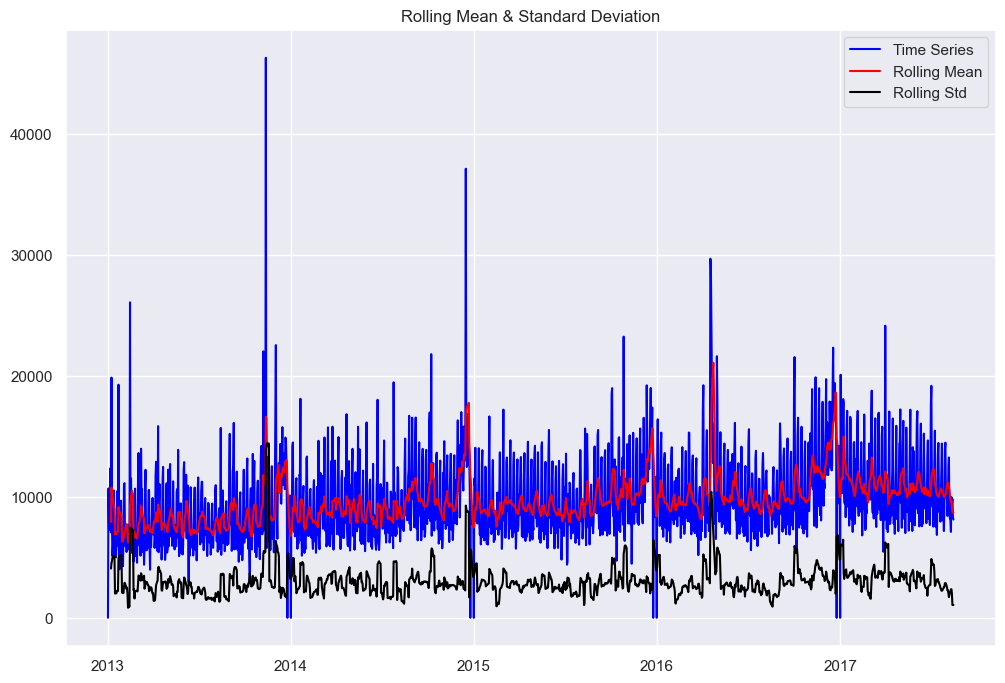

Results of Dickey-Fuller Test:
Stationary


In [181]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    # rolstd = pd.rolling_std(timeseries, window=7)

    #Plot rolling statistics:
    fig = pyplot.figure(figsize=(12, 8))
    orig = pyplot.plot(timeseries, color='blue',label='Time Series')
    mean = pyplot.plot(rolmean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolstd, color='black', label = 'Rolling Std')
    sns.set_theme()
    pyplot.legend(loc='best')
    pyplot.title('Rolling Mean & Standard Deviation')
    pyplot.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])


    result = adfuller(timeseries.values)
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        res = 'Stationary'
        print("\u001b[32mStationary\u001b[0m")
    else:
        res = 'Non-stationary'
        print("\x1b[31mNon-stationary\x1b[0m")


test_stationarity(tmp['sales'])

passes `adfuller` test - meaning that we don't have to difference this time series for its trend (i.e. `d=0`).

#### `seasonal_decompose`

- The additive model is useful when the seasonal variation is relatively constant over time. 
- The multiplicative model is useful when the seasonal variation increases over time. 
- [reference](https://online.stat.psu.edu/stat510/lesson/5/5.1#:~:text=How%20to%20Choose%20Between%20Additive,seasonal%20variation%20increases%20over%20time.)

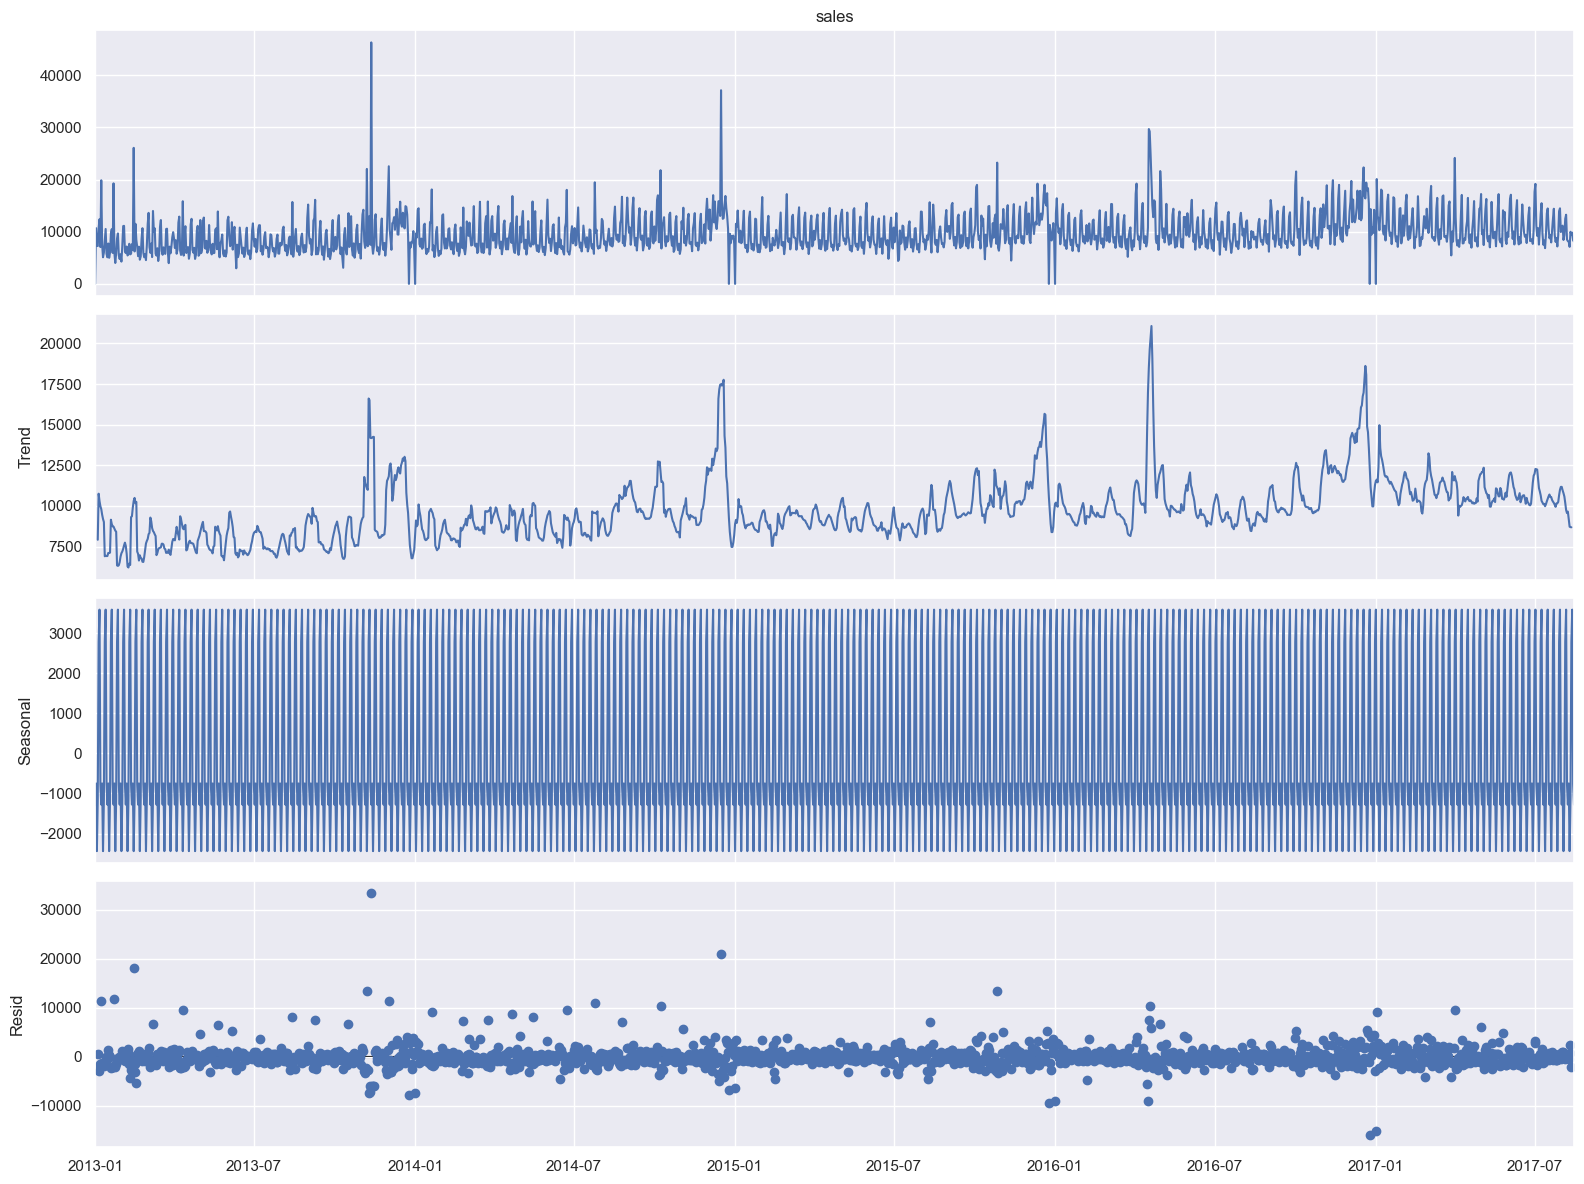

In [182]:
result = seasonal_decompose(tmp['sales'], model='additive', period=7)

sns.set_theme()
sns.set(rc={'figure.figsize':(16,12)})
fig = result.plot()
# fig.set_size_inches((16,15))
# fig.xticks(rotation=90)

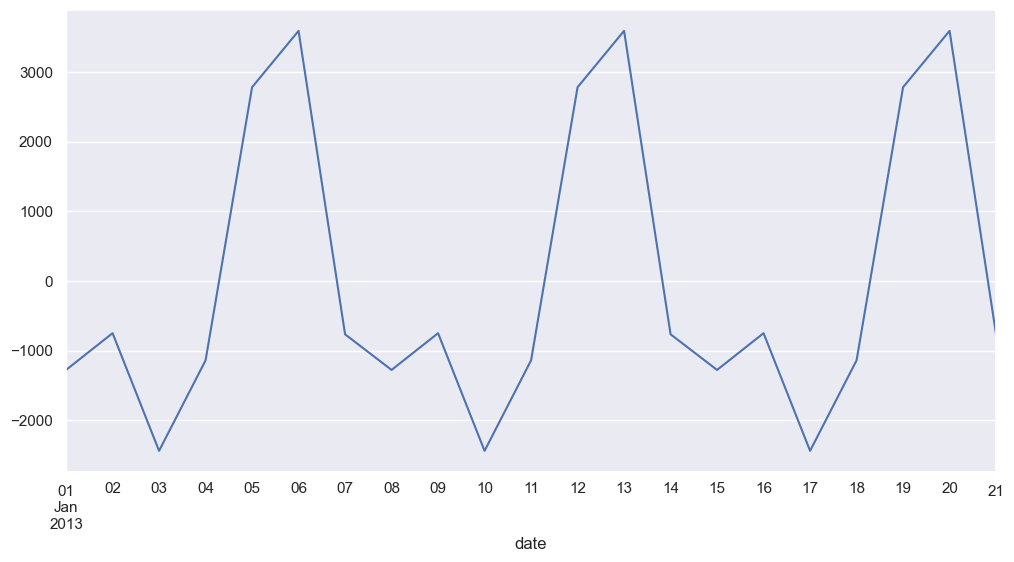

In [183]:
sns.set_theme()
sns.set(rc={'figure.figsize':(12,6)})

result = seasonal_decompose(tmp['sales'], model='additive', period=7)
result.seasonal[:21].plot();

#### Initial ACF & PACF

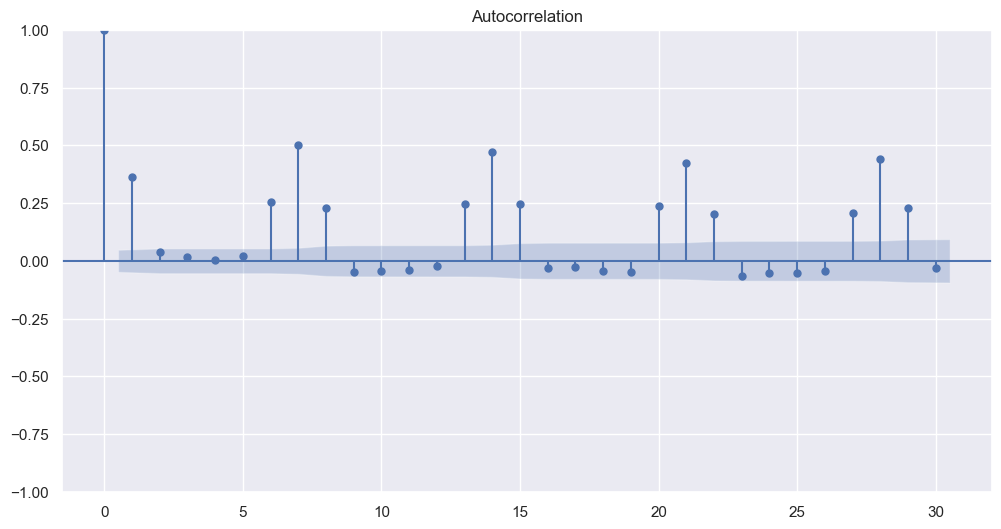

In [184]:
sns.set_theme()
sns.set(rc={'figure.figsize':(12,6)})

plot_acf(tmp['sales'], lags=30);

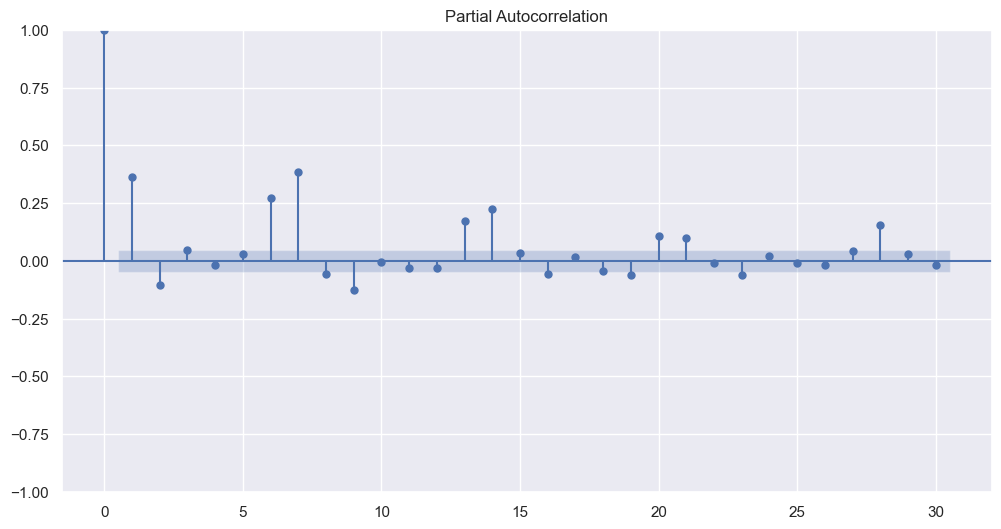

In [185]:
sns.set_theme()
sns.set(rc={'figure.figsize':(12,6)})

plot_pacf(tmp['sales'], lags=30);

#### Seasonal Differencing

try differencing at 7 [(reference)](https://people.duke.edu/~rnau/411sdif.htm)

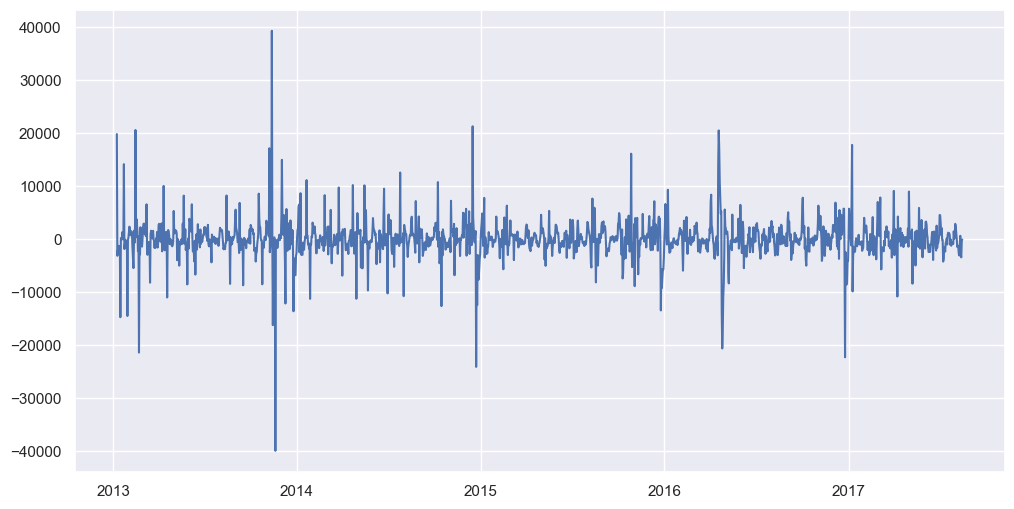

In [201]:
tmp['sales_diff1'] = tmp['sales'] - tmp['sales'].shift(7)

sns.set_theme()
sns.set(rc={'figure.figsize':(12,6)})

pyplot.plot(tmp['sales_diff1']);

[reference](https://medium.com/@ooemma83/how-to-interpret-acf-and-pacf-plots-for-identifying-ar-ma-arma-or-arima-models-498717e815b6#:~:text=The%20basic%20guideline%20for%20interpreting,q%20for%20MA(q).)

q=2

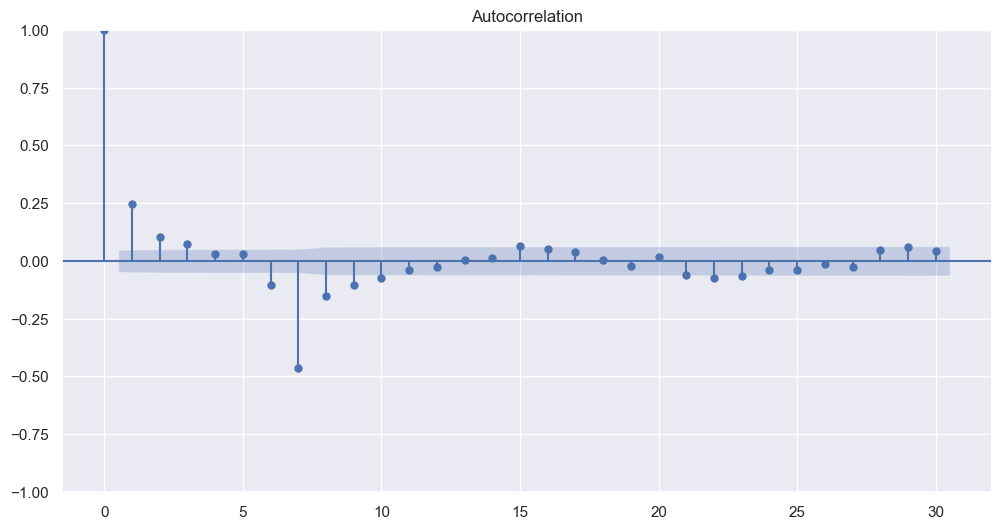

In [202]:
tmp['sales_diff1'] = tmp['sales'] - tmp['sales'].shift(7)

sns.set_theme()
sns.set(rc={'figure.figsize':(12,6)})

plot_acf(tmp['sales_diff1'].dropna(),lags=30);

tail off at PACF --> q=0

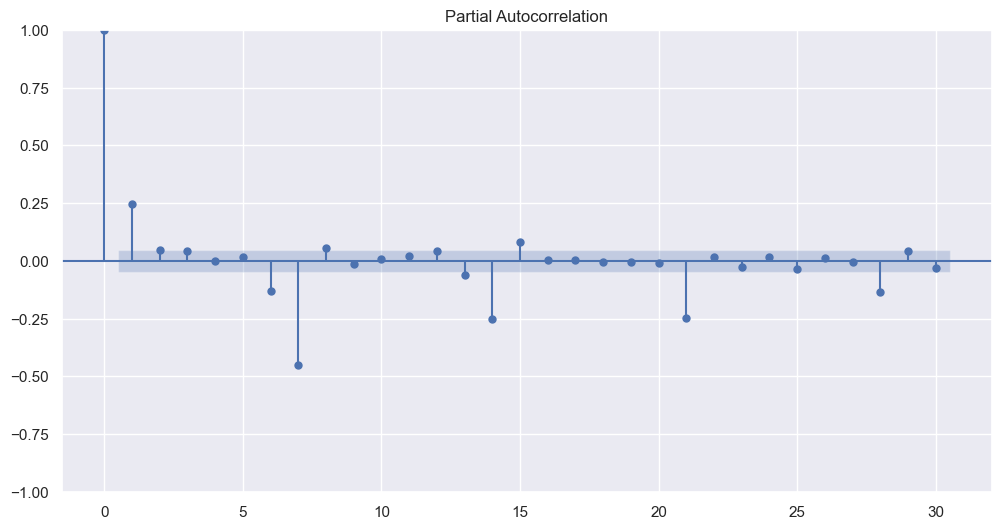

In [203]:
tmp['sales_diff1'] = tmp['sales'] - tmp['sales'].shift(7)

sns.set_theme()
sns.set(rc={'figure.figsize':(12,6)})

plot_pacf(tmp['sales_diff1'].dropna(),lags=30);

### Exploring seasonal component

[reference](https://towardsdatascience.com/understanding-the-seasonal-order-of-the-sarima-model-ebef613e40fa)

#### Stationarity (`D`)

In [206]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    # rolstd = pd.rolling_std(timeseries, window=7)

    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])


    result = adfuller(timeseries.values)
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        res = 'Stationary'
        print("\u001b[32mStationary\u001b[0m")
    else:
        res = 'Non-stationary'
        print("\x1b[31mNon-stationary\x1b[0m")


result = seasonal_decompose(tmp['sales'], model='additive', period=7)
seasonal = result.seasonal


test_stationarity(seasonal)

Results of Dickey-Fuller Test:
Stationary


D = 0

#### P

p=1

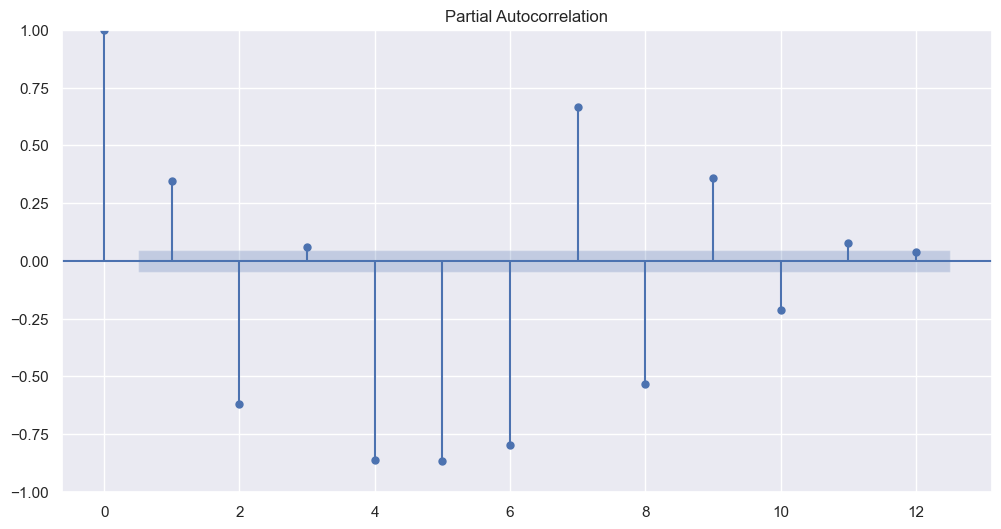

In [208]:
plot_pacf(seasonal, lags =12);

#### Q

q=1 as well

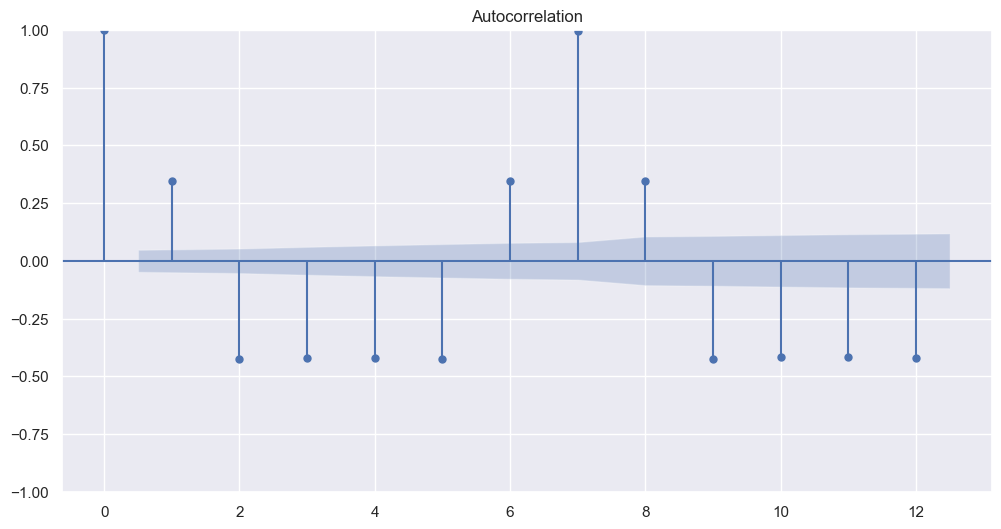

In [210]:
plot_acf(seasonal, lags =12);


# Modeling

[resource: Multiple TS forecasting with ARIMA](https://forecastegy.com/posts/multiple-time-series-forecasting-with-arima-in-python/)

test on 5 best- and worst- selling families-store combo

In [5]:
tmp = train_engineered.reset_index()
tmp = tmp[['sales','family','store_nbr']].groupby(['family', 'store_nbr']).sum().reset_index()
tmp = tmp.sort_values(by='sales', ascending=False)

fam_lst = tmp[:2]['family'].tolist()
fam_lst.extend(tmp[-2:]['family'].tolist())
store_lst = tmp[:2]['store_nbr'].astype(str).tolist()
store_lst.extend(tmp[-2:]['store_nbr'].astype(str).tolist())

# create a list for the top 10 store num + family combo
i = 0
lst = []
while i < 4:
    uid = fam_lst[i] + '_' + store_lst[i]
    lst.append(uid)
    i += 1

# lst    



In [6]:
train_engineered = train_engineered.reset_index()
train_engineered['uid'] = train_engineered['family'].astype(str)+'_'+train_engineered['store_nbr'].astype(str)

## EMWA

<Axes: xlabel='date'>

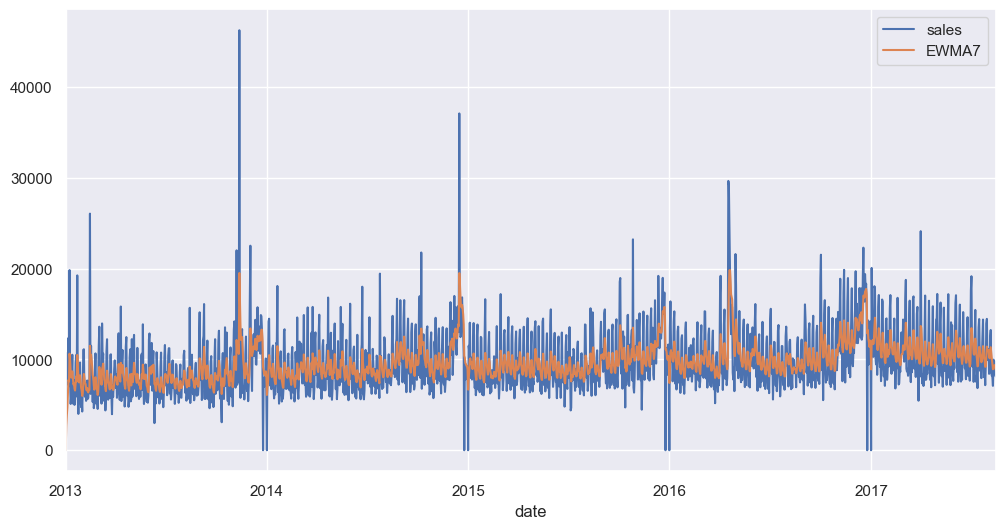

In [140]:
# use a span of 12 months
span = 7           # n-period EW moving average
alpha = 2/(span+1)

tmp['EWMA7'] = tmp['sales'].ewm(alpha=alpha, adjust=False).mean()

# rms = mean_squared_error(tmp['sales'], tmp['EWMA7'])
# print(rms)

tmp[['sales','EWMA7']].plot()

## ARIMA

### Train & Plot

#### Use all data together

In [7]:
df = train_engineered[train_engineered['uid'].isin(lst)]
df = df[['date','store_nbr', 'family', 'sales']].reset_index().set_index(['date','store_nbr','family'])

print(f"{len(df)} rows in df")
print(f"we use {round(len(df) * .8)} rows as training set")

train = df.iloc[:round(len(df) * .8)+1]
test = df.iloc[round(len(df) * .8)+1:]

6736 rows in df
we use 5389 rows as training set


In [8]:
model = auto_arima(train['sales'], seasonal=True, trace=False)
params = model.get_params()
order_aa = params.get('order')
seasonal_order_aa = params.get('seasonal_order')

# print('order:', order_aa)
# print('seasonal_order:', seasonal_order_aa)
# print('order DTYPE:', type(order_aa))
# print('seasonal_order DTYPE:', type(seasonal_order_aa))

p,d,q = order_aa[0], order_aa[1], order_aa[2] 

train on what's in the test set

In [ ]:
# fit model
model = ARIMA(train['sales'], order=(p,d,q))
results = model.fit()
# results.summary


# predict
start = len(train)
end = len(train) + len(test) - 1
preds = results.predict(start, end, type='levels').rename(f'ARIMA({p,d,q}) Preds') # type='levels' showing original data (as opposed to the differenced TS)


# concat result df
test2 = test.reset_index()
test2['id'] = test2['family'].astype(str) + '_' + test2['store_nbr'].astype(str)

p_df = pd.DataFrame()
p_df = pd.concat(
    [
        preds.reset_index(drop=True, name='pred'), 
        test2[['date','id','family', 'sales']]
    ], 
    axis=1)

##### Plot

Not so great for individual product-store groups. Specifically, it's overestimating the worse-selling categoreis.

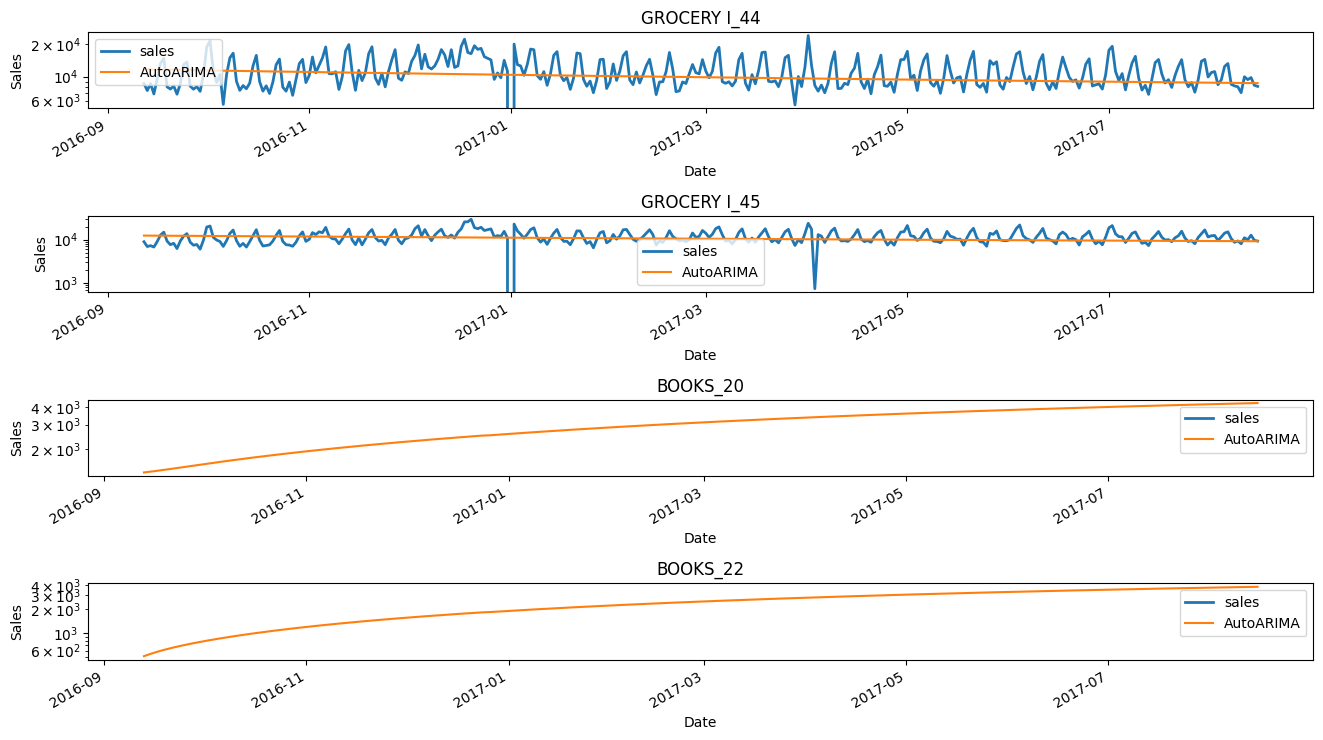

In [ ]:
fig,ax = pyplot.subplots(len(p_df.id.unique().tolist()),1, figsize=(1280/96, 720/96))

for ax_, uid in enumerate(p_df.id.unique()):
    p_df.loc[p_df['id'] == uid].plot(x='date', y='sales', ax=ax[ax_], label='sales', title=uid, linewidth=2)
    p_df.loc[p_df['id'] == uid].plot(x='date', y=f'ARIMA({p,d,q}) Preds', ax=ax[ax_], label='AutoARIMA')
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Sales')
    ax[ax_].set_yscale('log')
    ax[ax_].legend()
    
fig.tight_layout()

#### Train separately

train a different model for each family-store combo

In [ ]:
dct = {
    item: []
    for item in lst
}

# train_subset = pd.DataFrame()

for k,v in dct.items():
    startTime = time.time()

    item = k
    tmp = pd.DataFrame()

    tmp = train_engineered[train_engineered['uid']==k]
    df = tmp[['date','store_nbr', 'family', 'sales']].reset_index().set_index(['date'])

    # split
    train = df.iloc[:round(len(df) * .8)+1]
    test = df.iloc[round(len(df) * .8)+1:]

    # train
    model = auto_arima(train['sales'], seasonal=True, m=7, d=1)

    # get parameters
    params = model.get_params()
    order_aa = params.get('order')
    seasonal_order_aa = params.get('seasonal_order')

    p,d,q = order_aa[0], order_aa[1], order_aa[2] 

    # append results to list
    v.append(train)
    v.append(test)
    v.append(p)
    v.append(d)
    v.append(q)
    v.append(seasonal_order_aa)
    # v.append(tmp)

    # time
    runtime = (time.time() - startTime)/60
    print(f"{k} took {round(runtime,2)} mins")

GROCERY I_44 took 1.31 mins
GROCERY I_45 took 3.07 mins
BOOKS_20 took 0.0 mins
BOOKS_22 took 0.0 mins


a little better, but still not picking up seasonalities

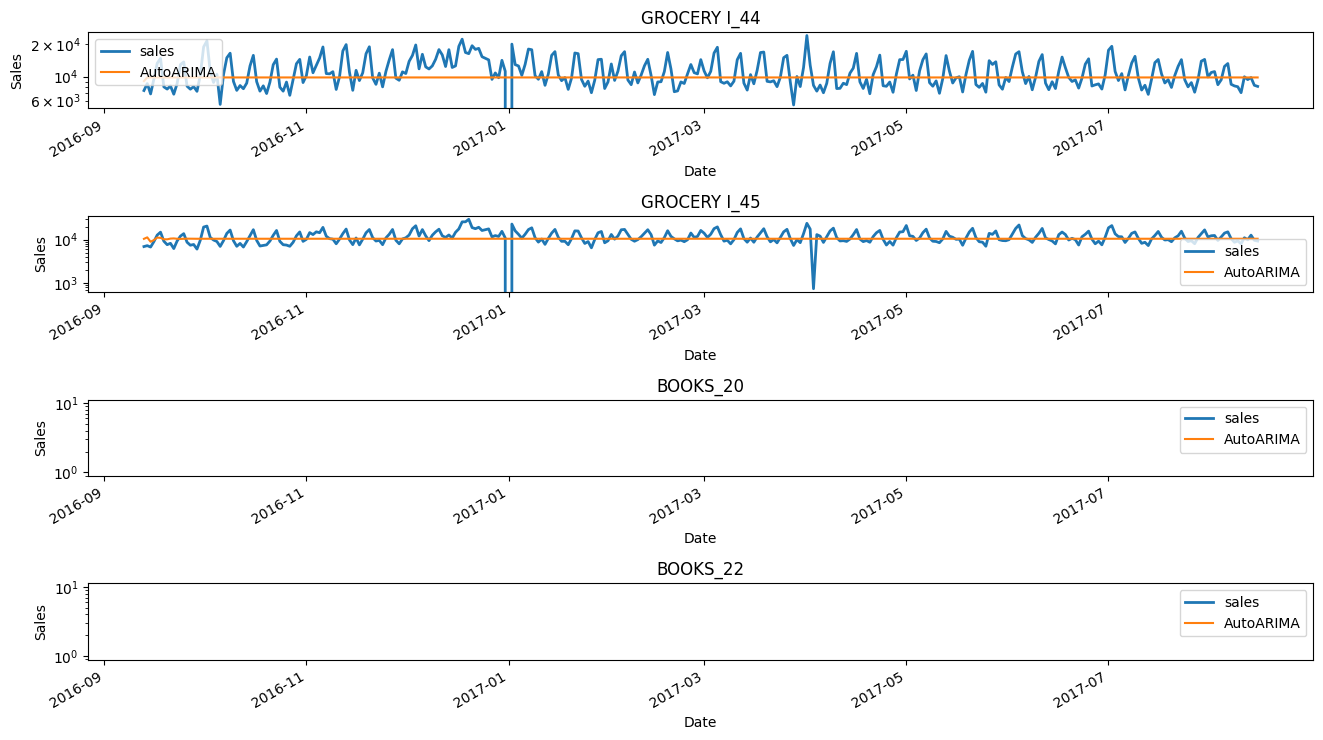

In [ ]:
fig,ax = pyplot.subplots(len(p_df.id.unique()),1, figsize=(1280/96, 720/96))

for ax_, uid in enumerate(p_df.id.unique()):
    p_df.loc[p_df['id'] == uid].plot(x='date', y='sales', ax=ax[ax_], label='sales', title=uid, linewidth=2)
    p_df.loc[p_df['id'] == uid].plot(x='date', y='ARIMA Preds', ax=ax[ax_], label='AutoARIMA')
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Sales')
    ax[ax_].set_yscale('log')
    ax[ax_].legend()
fig.tight_layout()

## SARIMA

In [222]:
p_df = pd.DataFrame()

# for k,v in dct.items():
for k in lst:
    startTime = time.time()

    item = k
    tmp = pd.DataFrame()

    tmp = train_engineered[train_engineered['uid']==k]
    df = tmp[['date','store_nbr', 'family', 'sales']].reset_index().set_index(['date'])

    # split
    train = df.iloc[:round(len(df) * .8)+1]
    test = df.iloc[round(len(df) * .8)+1:]

    # train w auto_arima
    model = auto_arima(train['sales'], seasonal=True, start_p=3, max_p=10, m=7)

    # get parameters
    params = model.get_params()
    order_aa = params.get('order')
    
    p,d,q = order_aa[0], order_aa[1], order_aa[2] 
    seasonal_order_aa = params.get('seasonal_order')

    # train model
    model = SARIMAX(
        train['sales'],
        order=(order_aa[0], order_aa[1], order_aa[2]), 
        seasonal_order =(seasonal_order_aa[0], seasonal_order_aa[1], seasonal_order_aa[2], seasonal_order_aa[3])
    )
    results = model.fit()

    # predict
    start = len(train)
    end = len(train) + len(test) - 1
    preds = results.predict(start, end, type='levels').rename(f'SARIMA Preds') # type='levels' showing original data (as opposed to the differenced TS)


    # concat result df
    test2 = test.reset_index()
    test2['id'] = test2['family'].astype(str) + '_' + test2['store_nbr'].astype(str)

    tmp_df = pd.DataFrame()
    tmp_df = pd.concat(
        [
            preds.reset_index(drop=True, name='pred'), 
            test2[['date','id','family', 'sales']]
        ], 
        axis=1)

    p_df = pd.concat([tmp_df, p_df],axis=0)

    # time
    runtime = (time.time() - startTime)/60
    print(f"{k} took {round(runtime,2)} mins")

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43652D+00    |proj g|=  1.12768D-01

At iterate    5    f=  9.40245D+00    |proj g|=  5.77471D-02

At iterate   10    f=  9.37593D+00    |proj g|=  1.59499D-02

At iterate   15    f=  9.37287D+00    |proj g|=  5.85179D-04

At iterate   20    f=  9.37267D+00    |proj g|=  1.28906D-03

At iterate   25    f=  9.37250D+00    |proj g|=  1.54884D-04

At iterate   30    f=  9.37250D+00    |proj g|=  1.22912D-03

At iterate   35    f=  9.37206D+00    |proj g|=  1.49510D-02

At iterate   40    f=  9.35855D+00    |proj g|=  6.05513D-02

At iterate   45    f=  9.35163D+00    |proj g|=  7.74593D-04

At iterate   50    f=  9.35111D+00    |proj g|=  9.27719D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.43313D+00    |proj g|=  3.79015D-02

At iterate   10    f=  9.40057D+00    |proj g|=  3.22706D-02

At iterate   15    f=  9.39240D+00    |proj g|=  1.38391D-02

At iterate   20    f=  9.39169D+00    |proj g|=  7.02728D-03

At iterate   25    f=  9.38488D+00    |proj g|=  2.50425D-02

At iterate   30    f=  9.38287D+00    |proj g|=  3.35042D-03

At iterate   35    f=  9.38281D+00    |proj g|=  1.84250D-03

At iterate   40    f=  9.38273D+00    |proj g|=  4.56191D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     44     49      1     0     0   1.030D-04   9.383D+00
  F =   9.38270760081

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


starting to pick up more seasonality

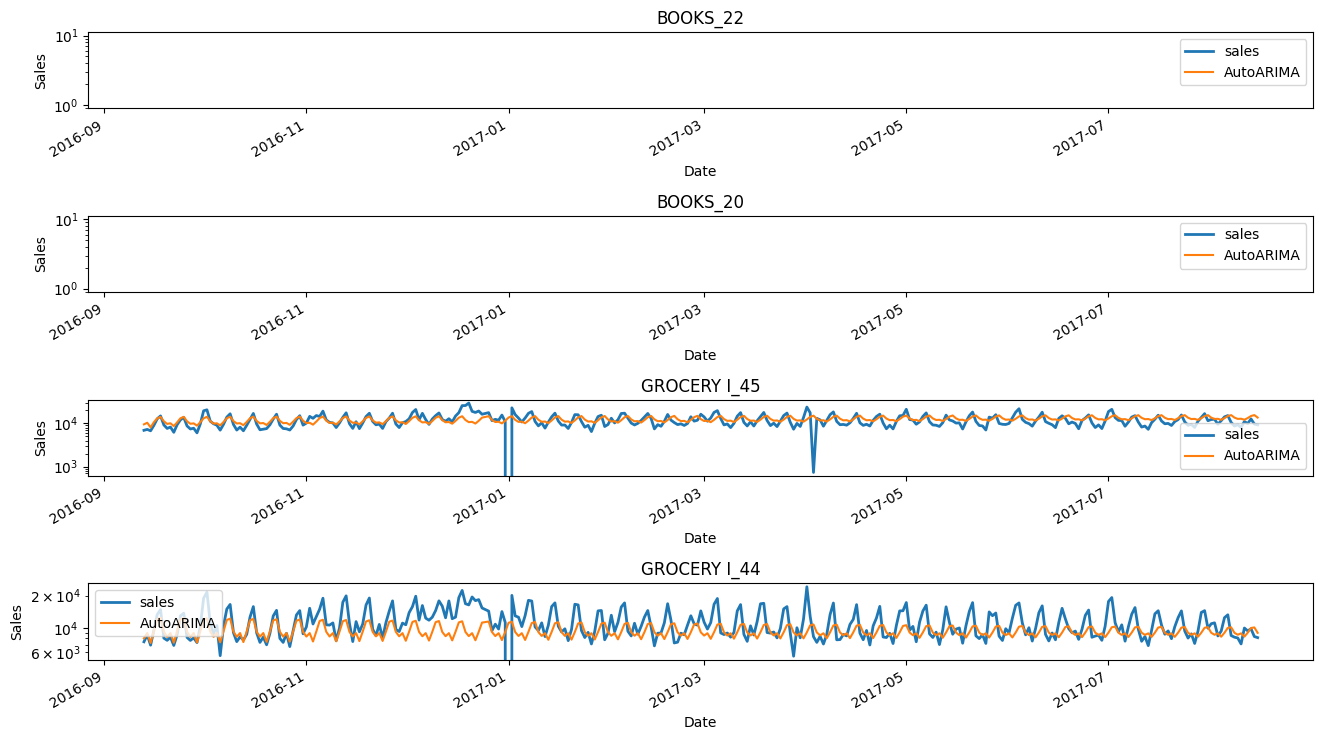

In [ ]:
fig,ax = pyplot.subplots(len(p_df.id.unique()),1, figsize=(1280/96, 720/96))

for ax_, uid in enumerate(p_df.id.unique()):
    p_df.loc[p_df['id'] == uid].plot(x='date', y='sales', ax=ax[ax_], label='sales', title=uid, linewidth=2)
    p_df.loc[p_df['id'] == uid].plot(x='date', y=f'SARIMA Preds', ax=ax[ax_], label='AutoARIMA')
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Sales')
    ax[ax_].set_yscale('log')
    ax[ax_].legend()
fig.tight_layout()

In [224]:
p_df

SARIMA Preds       date            id     family   sales
0        0.000000 2016-09-13      BOOKS_22      BOOKS     0.0
1        0.000000 2016-09-14      BOOKS_22      BOOKS     0.0
2        0.000000 2016-09-15      BOOKS_22      BOOKS     0.0
3        0.000000 2016-09-16      BOOKS_22      BOOKS     0.0
4        0.000000 2016-09-17      BOOKS_22      BOOKS     0.0
..            ...        ...           ...        ...     ...
331   8298.744979 2017-08-11  GROCERY I_44  GROCERY I  9979.0
332   9024.669382 2017-08-12  GROCERY I_44  GROCERY I  9391.0
333   9985.213974 2017-08-13  GROCERY I_44  GROCERY I  9811.0
334  10109.833301 2017-08-14  GROCERY I_44  GROCERY I  8318.0
335   9004.845746 2017-08-15  GROCERY I_44  GROCERY I  8123.0

[1344 rows x 5 columns]

In [225]:
test = p_df[p_df['id']=='GROCERY I_44']
test

SARIMA Preds       date            id     family    sales
0     7994.579074 2016-09-13  GROCERY I_44  GROCERY I   7432.0
1     8970.089020 2016-09-14  GROCERY I_44  GROCERY I   8632.0
2     7244.747197 2016-09-15  GROCERY I_44  GROCERY I   6912.0
3     9322.832778 2016-09-16  GROCERY I_44  GROCERY I   9515.0
4    12072.559685 2016-09-17  GROCERY I_44  GROCERY I  13314.0
..            ...        ...           ...        ...      ...
331   8298.744979 2017-08-11  GROCERY I_44  GROCERY I   9979.0
332   9024.669382 2017-08-12  GROCERY I_44  GROCERY I   9391.0
333   9985.213974 2017-08-13  GROCERY I_44  GROCERY I   9811.0
334  10109.833301 2017-08-14  GROCERY I_44  GROCERY I   8318.0
335   9004.845746 2017-08-15  GROCERY I_44  GROCERY I   8123.0

[336 rows x 5 columns]

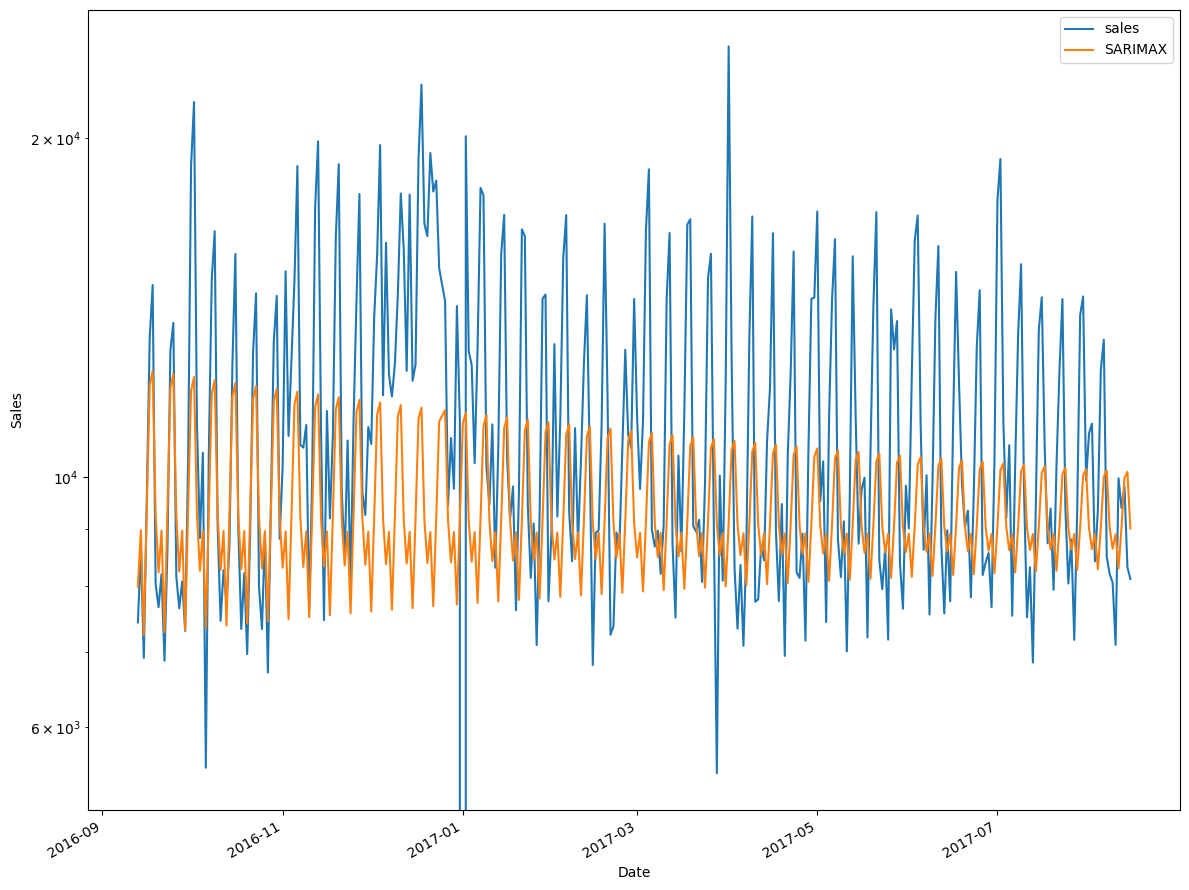

In [227]:
# fig,ax = pyplot.subplots(len(p_df.id.unique()),1, figsize=(1280/96, 720/96))

# for ax_, uid in enumerate(p_df.id.unique()):
# p_df.loc[p_df['id'] == uid].plot(x='date', y='sales', ax=ax[ax_], label='sales', title=uid, linewidth=2)
# p_df.loc[p_df['id'] == uid].plot(x='date', y=f'SARIMA Preds', ax=ax[ax_], label='AutoARIMA')
# ax = pyplot.plot()


fig, ax = pyplot.subplots(1,1,figsize=(12,9))
test.plot(x='date', y='sales', ax=ax, label='sales')
test.plot(x='date', y=f'SARIMA Preds', ax=ax, label='SARIMAX')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()

## SARIMAX

### Data Preprocessing

In [10]:
national_dummy_df = pd.get_dummies(train_engineered['national_holidays'])
natioanl_dummy_lst = national_dummy_df.columns.tolist()   # save for later

regional_dummy_df = pd.get_dummies(train_engineered['regional_local_holidays'])
regional_dummy_lst = regional_dummy_df.columns.tolist()   # save for later

# put national & regional/local together
# description_dummy_df = pd.concat([national_dummy_df, regional_dummy_df], axis=1)
description_dummy_lst = natioanl_dummy_lst.copy()
description_dummy_lst.extend(regional_dummy_lst)


features_to_use = [
    'date','sales','onpromotion','oil_price', 'out_of_region',
    'is_year_start','is_year_end',  
    'day_of_year',
    'is_wknd','wageday'
]
features_to_use.extend(description_dummy_lst)

exog_vars = [item for item in features_to_use if item not in ['date','sales']]

In [11]:
df = train_engineered[train_engineered['uid']=='GROCERY I_44']

df = df[features_to_use]
df = df.set_index('date')

# set index freq
df = df.asfreq('d')
# print(test.index.freq)

# drop the nas for now
# df = df[~df.isna().any(axis=1)]

df[df.isna()] = 0 


# train test split
train = df.iloc[:round(len(df) * .8)+1]
test = df.iloc[round(len(df) * .8)+1:]

In [16]:
tmp = df
tmp = tmp.asfreq('D')

# extrapolate NAs
tmp[['sales','onpromotion','oil_price']]= tmp[['sales','onpromotion','oil_price']].interpolate(method='linear')

# exclude a col
# tmp = tmp.drop(columns=['if_holiday'], axis=1)

tmp.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=1688, freq='D')

most important columns to sales
- `is_wknd`, `day_ofweek`, `year`
- `oil_price`, `onpromotion`

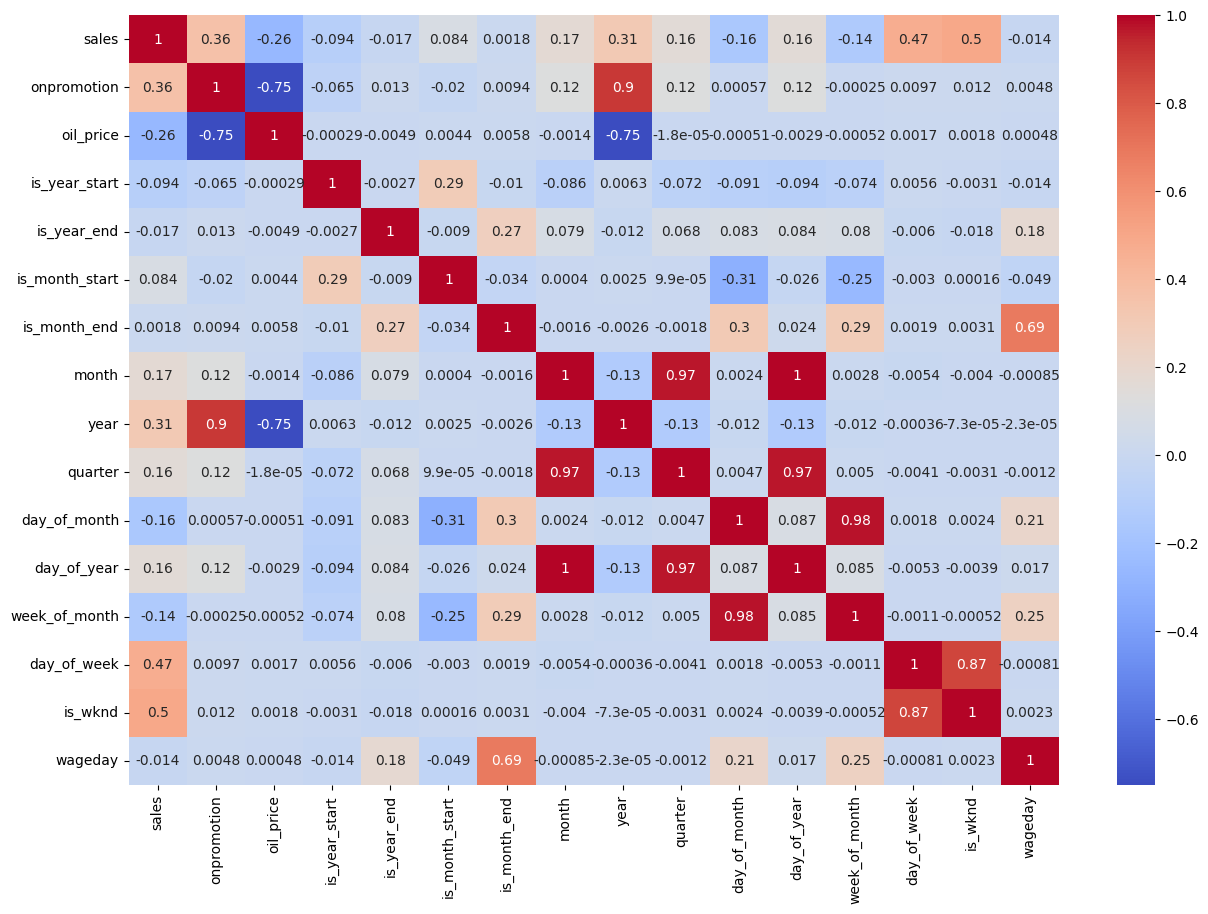

### `Auto_arima`

#### `onpromotion` & `oil_price`

[Stack Overflow: AutoArima - Selecting correct value for m](https://stackoverflow.com/questions/68395727/autoarima-selecting-correct-value-for-m)
- If your data is daily and the pattern repeats every 365 days (meaning every year) then yes (you need to remember that every fourth year has 366 days though).



In [195]:
# train w auto_arima
model = auto_arima(train['sales'], seasonal=True, start_p=1, max_p=10, m=14, trace=True)

# get parameters
params = model.get_params()
order_aa = params.get('order')

p,d,q = order_aa[0], order_aa[1], order_aa[2] 
seasonal_order_aa = params.get('seasonal_order')

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(1,0,1)[14] intercept   : AIC=inf, Time=4.20 sec
 ARIMA(0,1,0)(0,0,0)[14] intercept   : AIC=26179.551, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[14] intercept   : AIC=25865.205, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[14] intercept   : AIC=25587.783, Time=1.84 sec
 ARIMA(0,1,0)(0,0,0)[14]             : AIC=26177.554, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[14] intercept   : AIC=25718.798, Time=0.23 sec
 ARIMA(0,1,1)(1,0,1)[14] intercept   : AIC=25311.202, Time=2.76 sec
 ARIMA(0,1,1)(1,0,0)[14] intercept   : AIC=25521.465, Time=2.16 sec
 ARIMA(0,1,1)(2,0,1)[14] intercept   : AIC=25399.526, Time=6.79 sec
 ARIMA(0,1,1)(1,0,2)[14] intercept   : AIC=25318.829, Time=7.71 sec
 ARIMA(0,1,1)(0,0,2)[14] intercept   : AIC=25525.977, Time=7.16 sec
 ARIMA(0,1,1)(2,0,0)[14] intercept   : AIC=25431.494, Time=5.49 sec
 ARIMA(0,1,1)(2,0,2)[14] intercept   : AIC=inf, Time=7.92 sec
 ARIMA(0,1,0)(1,0,1)[14] intercept   : AIC=25852.027, Time=2.04 sec
 ARIMA(1,1,1)(1,0

In [196]:

# train model
model = SARIMAX(
    train['sales'],
    exog=train[['onpromotion', 'oil_price']],
    order=(order_aa[0], order_aa[1], order_aa[2]), 
    seasonal_order =(seasonal_order_aa[0], seasonal_order_aa[1], seasonal_order_aa[2], seasonal_order_aa[3])
)
results = model.fit()
# results.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47320D+00    |proj g|=  2.02878D-01


 This problem is unconstrained.



At iterate    5    f=  9.42484D+00    |proj g|=  6.64768D-02

At iterate   10    f=  9.40764D+00    |proj g|=  5.66313D-03

At iterate   15    f=  9.40690D+00    |proj g|=  4.90911D-04

At iterate   20    f=  9.40683D+00    |proj g|=  1.49266D-03

At iterate   25    f=  9.40218D+00    |proj g|=  1.52164D-02

At iterate   30    f=  9.39515D+00    |proj g|=  1.30439D-03

At iterate   35    f=  9.39509D+00    |proj g|=  2.33001D-04

At iterate   40    f=  9.39494D+00    |proj g|=  4.92755D-03

At iterate   45    f=  9.38863D+00    |proj g|=  2.54580D-02

At iterate   50    f=  9.38126D+00    |proj g|=  1.90173D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [197]:
# predict
start = len(train)
end = len(train) + len(test) - 1
preds = results.predict(start, end, exog=test[['onpromotion','oil_price']], type='levels').rename(f'SARIMAX Preds') # type='levels' showing original data (as opposed to the differenced TS)
# pred_SARIMAX = results.get_forecast(steps=len(test), exog=test[['onpromotion', 'oil_price']])


In [204]:
p_df = pd.DataFrame()

# concat result df
test2 = test.reset_index()
# test2['id'] = test2['family'].astype(str) + '_' + test2['store_nbr'].astype(str)

tmp_df = pd.DataFrame()
tmp_df = pd.concat(
    [
        preds.reset_index(drop=True),
        # pred_SARIMAX.predicted_mean.reset_index(drop=True),
        test2[['date','sales','onpromotion', 'oil_price']]

    ], 
    axis=1
)

p_df = pd.concat([tmp_df, p_df],axis=1)

# # time
# runtime = (time.time() - startTime)/60
# print(f"{k} took {round(runtime,2)} mins")

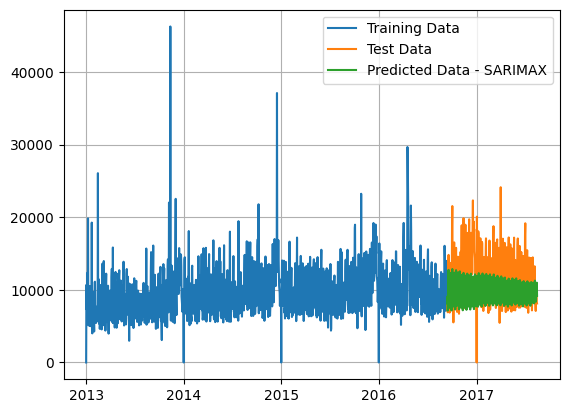

In [198]:
pyplot.plot(train['sales'], label='Training Data')
pyplot.plot(test['sales'], label='Test Data')

pyplot.plot(test.index,preds,label='Predicted Data - SARIMAX')
# pyplot.plot(test.index,pred_SARIMAX.predicted_mean,label='Predicted Data - SARIMAX_interst rate')
# pyplot.plot(test.index,pred_SARIMAX_unemployment.predicted_mean,label='Predicted Data - SARIMAX_unemploymnet rate')
pyplot.legend(loc='best')
pyplot.grid();

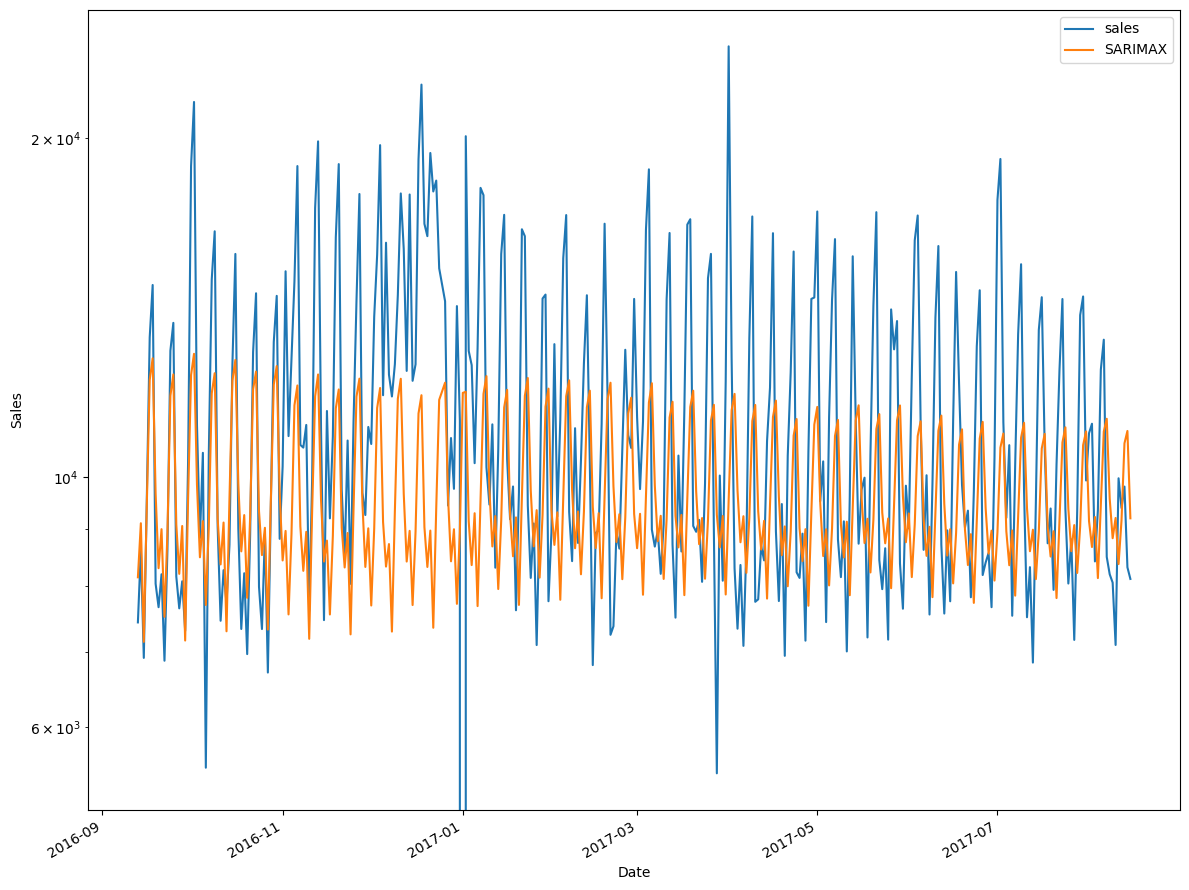

In [219]:
# fig,ax = pyplot.subplots(len(p_df.id.unique()),1, figsize=(1280/96, 720/96))

# for ax_, uid in enumerate(p_df.id.unique()):
# p_df.loc[p_df['id'] == uid].plot(x='date', y='sales', ax=ax[ax_], label='sales', title=uid, linewidth=2)
# p_df.loc[p_df['id'] == uid].plot(x='date', y=f'SARIMA Preds', ax=ax[ax_], label='AutoARIMA')
# ax = pyplot.plot()

fig, ax = pyplot.subplots(1,1,figsize=(12,9))
p_df.plot(x='date', y='sales', ax=ax, label='sales')
p_df.plot(x='date', y=f'SARIMAX Preds', ax=ax, label='SARIMAX')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()

#### Holiday & Time Features

##### Best model

In [813]:
train.shape

(1351, 104)

In [814]:
# national_dummy_df = pd.get_dummies(train_engineered['national_holidays'])
natioanl_dummy_lst = national_dummy_df.columns.tolist()   # save for later

# regional_dummy_df = pd.get_dummies(train_engineered['regional_local_holidays'])
regional_dummy_lst = regional_dummy_df.columns.tolist()   # save for later

# put national & regional/local together
# description_dummy_df = pd.concat([national_dummy_df, regional_dummy_df], axis=1)
description_dummy_lst = natioanl_dummy_lst.copy()
description_dummy_lst.extend(regional_dummy_lst)

features_to_use = [
    'date','sales', 'out_of_region',
    'onpromotion','oil_price', 
    'is_year_start','is_year_end', 
    'is_wknd','wageday'
]
features_to_use.extend(description_dummy_lst)


# train w auto_arima
# model = auto_arima(train['sales'], seasonal=True, start_p=0, start_q=7, max_q=15, m=7, trace=True)

# # get parameters
# params = model.get_params()
# order_aa = params.get('order')

# p,d,q = order_aa[0], order_aa[1], order_aa[2] 
# seasonal_order_aa = params.get('seasonal_order')


exog_vars = [item for item in features_to_use if item not in ['date','sales']]

# train model
model = SARIMAX(
    train['sales'],
    exog=train[exog_vars],
    # order=(order_aa[0], order_aa[1], order_aa[2]), 
    order=(0,1,2),
    # seasonal_order =(seasonal_order_aa[0], seasonal_order_aa[1], seasonal_order_aa[2], seasonal_order_aa[3])
    seasonal_order=(1,0,1,7)
)
results = model.fit()
# results.summary()


# predict
start = len(train)
end = len(train) + len(test) - 1
preds = results.predict(
    start, end, 
    exog=test[exog_vars], 
    type='levels'
).rename(f'SARIMAX Preds') # type='levels' showing original data (as opposed to the differenced TS)
# pred_SARIMAX = results.get_forecast(steps=len(test), exog=test[['onpromotion', 'oil_price']])


p_df = pd.DataFrame()

# concat result df
test2 = test.reset_index()
# test2['id'] = test2['family'].astype(str) + '_' + test2['store_nbr'].astype(str)

tmp_df = pd.DataFrame()
tmp_df = pd.concat(
    [
        preds.reset_index(drop=True),
        # pred_SARIMAX.predicted_mean.reset_index(drop=True),
        test2[features_to_use]

    ], 
    axis=1
)

p_df = pd.concat([tmp_df, p_df],axis=1)

# # time
# runtime = (time.time() - startTime)/60
# print(f"{k} took {round(runtime,2)} mins")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          107     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33689D+00    |proj g|=  7.44744D-02


 This problem is unconstrained.



At iterate    5    f=  9.31767D+00    |proj g|=  7.19997D-02

At iterate   10    f=  9.28576D+00    |proj g|=  2.88133D-02

At iterate   15    f=  9.27541D+00    |proj g|=  2.14861D-03

At iterate   20    f=  9.26419D+00    |proj g|=  5.71583D-02

At iterate   25    f=  9.26170D+00    |proj g|=  6.05175D-04

At iterate   30    f=  9.26058D+00    |proj g|=  1.00402D-03

At iterate   35    f=  9.25959D+00    |proj g|=  3.14560D-04

At iterate   40    f=  9.25953D+00    |proj g|=  5.13386D-04

At iterate   45    f=  9.25953D+00    |proj g|=  1.14032D-03

At iterate   50    f=  9.25951D+00    |proj g|=  1.73167D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

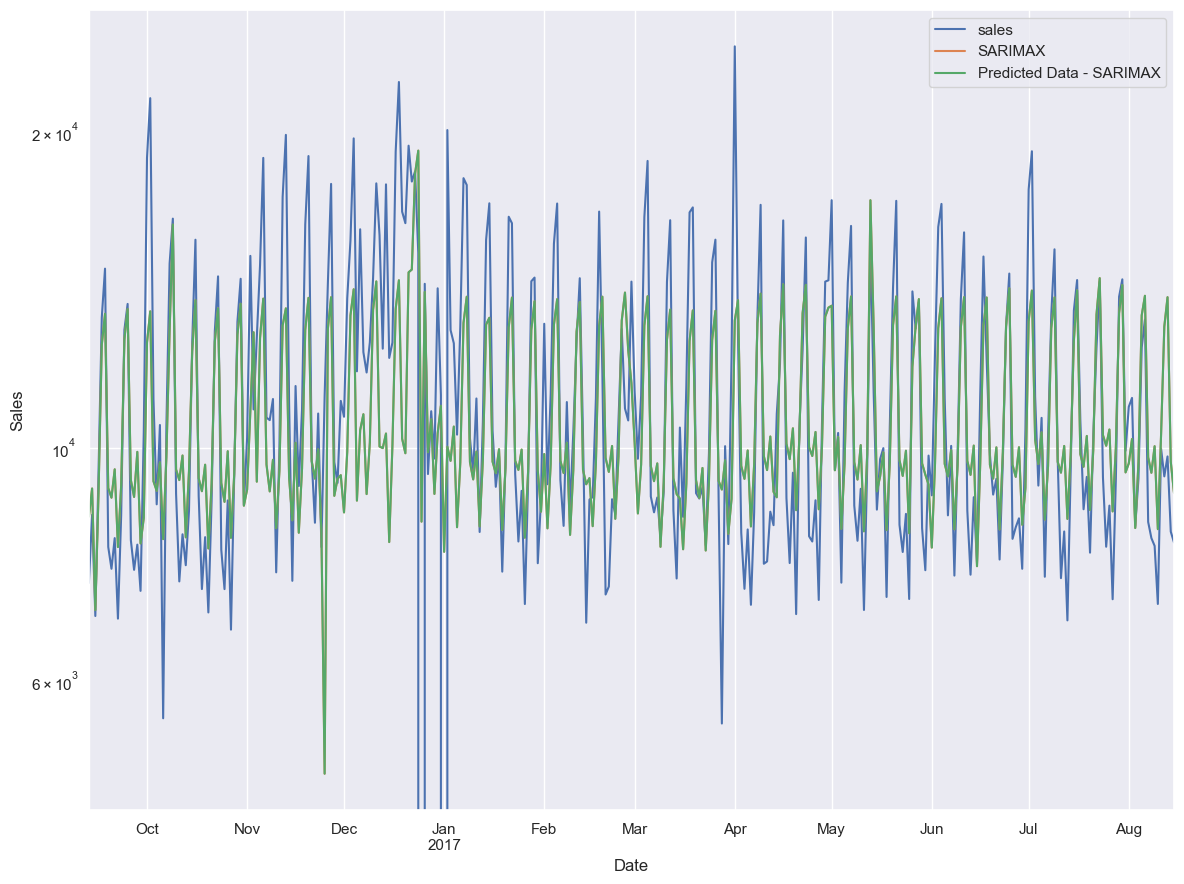

In [815]:
df = pd.concat([test.reset_index()[['date','sales']], preds.reset_index()],axis=1)
df.reset_index(inplace=True)


fig, ax = pyplot.subplots(1,1,figsize=(12,9))
df.plot(x='date', y='sales', ax=ax, label='sales')
df.plot(x='date', y='SARIMAX Preds', ax=ax, label='SARIMAX')

pyplot.plot(test.index,preds,label='Predicted Data - SARIMAX')

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()


In [816]:
error=rmse(df['SARIMAX Preds'], df['sales'])
error

2381.5475510571036

##### Debugging

In [ ]:
df = pd.concat([test.reset_index()[['date','sales']], preds.reset_index()],axis=1)
df.reset_index(inplace=True)

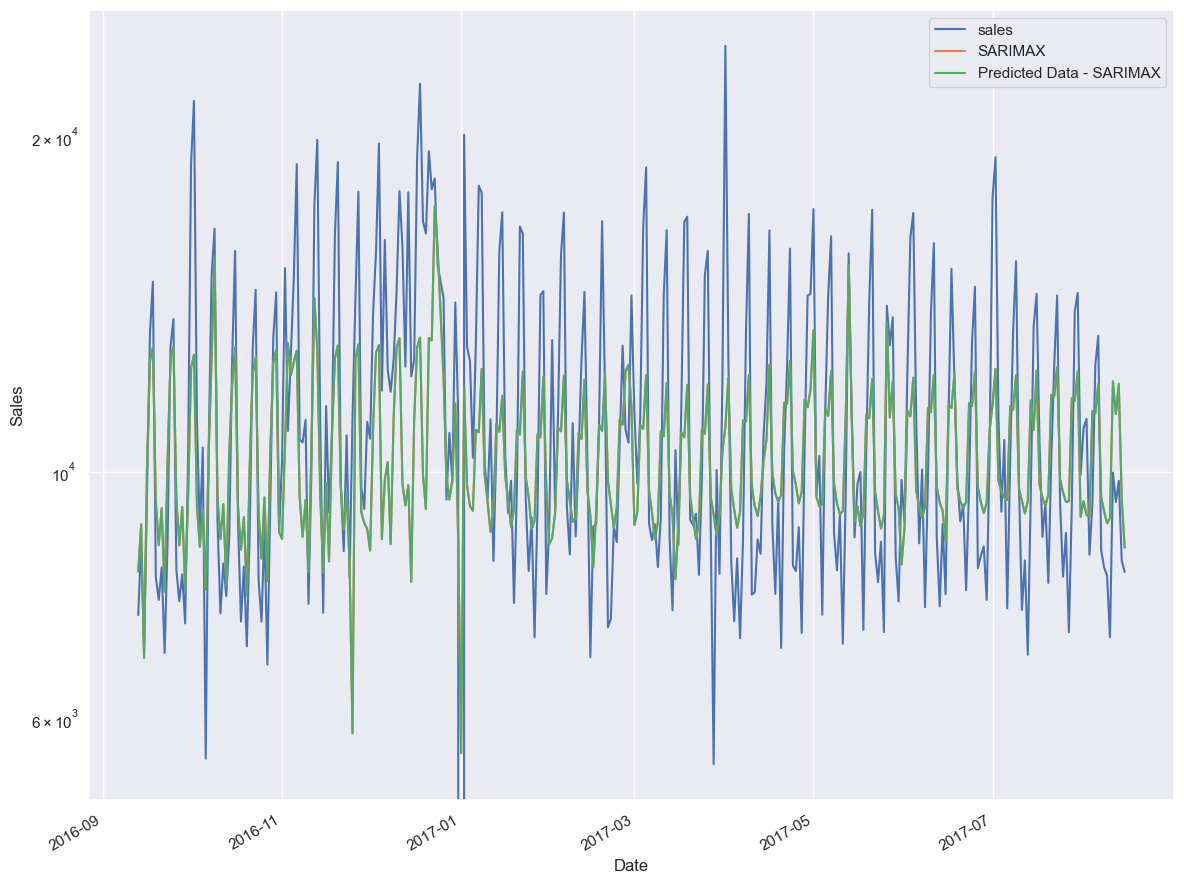

In [241]:


fig, ax = pyplot.subplots(1,1,figsize=(12,9))
df.plot(x='date', y='sales', ax=ax, label='sales')
df.plot(x='date', y='SARIMAX Preds', ax=ax, label='SARIMAX')

pyplot.plot(test.index,preds,label='Predicted Data - SARIMAX')

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()

In [242]:
error=rmse(df['SARIMAX Preds'], df['sales'])
error

2740.422631351884

a little more debugging
- seems like there're errors with `holidays_events` joining

In [91]:
tmp = df[['date','sales', 'SARIMAX Preds']].copy()
tmp['diff'] = abs(df['sales'] - df['SARIMAX Preds'])
tmp['diff'] = round(tmp['diff'],2)
tmp = tmp.sort_values(by=['diff'], ascending=False).reset_index(drop=True)
date_lst = tmp['date']

In [92]:
tmp

date    sales  SARIMAX Preds      diff
0   2017-04-01  24134.0   10969.548831  13164.45
1   2016-12-18  22318.0   13195.749730   9122.25
2   2016-10-02  21540.0   12736.899623   8803.10
3   2017-01-02  20083.0   11925.185169   8157.81
4   2016-12-14  17827.0    9723.708842   8103.29
..         ...      ...            ...       ...
331 2017-05-02   9523.0    9492.835646     30.16
332 2017-02-22   8931.0    8901.544436     29.46
333 2017-05-14  11297.0   11325.333078     28.33
334 2017-05-10   9138.0    9153.228156     15.23
335 2016-10-31   8817.0    8821.533123      4.53

[336 rows x 4 columns]

In [86]:
holidays_events[holidays_events.index=='2016-12-18']

Empty DataFrame
Columns: [type, holiday_locale, holiday_locale_name, description, transferred]
Index: []

In [93]:
holidays_events[holidays_events.index.isin(tmp['date'][:30])]

type holiday_locale             holiday_locale_name  \
date                                                                    
2016-11-06     Holiday       Regional  Santo Domingo de los Tsachilas   
2016-11-25       Event       National                         Ecuador   
2016-12-06     Holiday          Local                           Quito   
2016-12-21  Additional       National                         Ecuador   
2017-01-01     Holiday       National                         Ecuador   
2017-01-02    Transfer       National                         Ecuador   
2017-04-01     Holiday       Regional                        Cotopaxi   

                                   description  transferred  
date                                                         
2016-11-06  Provincializacion de Santo Domingo        False  
2016-11-25                        Black Friday        False  
2016-12-06                  Fundacion de Quito        False  
2016-12-21                           Navidad-4        False  
2017-01-01                  Primer dia del ano         True  
2017-01-02         Traslado Primer dia del ano        False  
2017-04-01       Provincializacion de Cotopaxi        False

In [59]:
train_engineered[train_engineered.date.isin(date_lst[:10])]\
    [['description','is_wknd', 'wageday', ]]

description  is_wknd  wageday
2435994  Not Holiday        1        0
2435995  Not Holiday        1        0
2435996  Not Holiday        1        0
2435997  Not Holiday        1        0
2435998  Not Holiday        1        0
...              ...      ...      ...
2922475  Not Holiday        1        0
2922476  Not Holiday        1        0
2922477  Not Holiday        1        0
2922478  Not Holiday        1        0
2922479  Not Holiday        1        0

[17820 rows x 3 columns]

In [55]:
train_engineered.columns[15:30]

Index(['transferred', 'if_holiday', 'month', 'day_of_month', 'day_of_year',
       'week_of_month', 'day_of_week', 'year', 'is_wknd', 'quarter',
       'is_month_start', 'is_month_end', 'is_year_start', 'is_year_end',
       'wageday'],
      dtype='object')

In [237]:
# tmp = pd.DataFrame()
# tmp['+'] = train_engineered['description'].str.split('+')
# tmp['res1'] = tmp['+'].apply(lambda x:x[0])

# tmp['-'] = tmp['res1'].str.split('-')
# tmp['res2'] = tmp['-'].apply(lambda x:x[0])

# tmp[':'] = tmp['res2'].str.split(':')
# tmp['res3'] = tmp[':'].apply(lambda x:x[0])

# description_dummy_df = pd.get_dummies(tmp['res3'])
# description_dummy_lst = description_dummy_df.columns.tolist()   # save for later

features_to_use = [
    'date','sales','onpromotion','oil_price', 
    'is_year_start','is_year_end',
    # 'is_month_start','is_month_end',
    # 'month','year', 'quarter',
    # 'day_of_month','week_of_month', 'day_of_week',
    # 'day_of_year',
    # 'is_wknd','wageday'
]
features_to_use.extend(description_dummy_lst)

exog_vars = [item for item in features_to_use if item not in ['date','sales']]


# train w auto_arima
# model = auto_arima(train['sales'], seasonal=True, start_p=0, start_q=7, max_q=15, m=7, trace=True)

# # get parameters
# params = model.get_params()
# order_aa = params.get('order')

# p,d,q = order_aa[0], order_aa[1], order_aa[2] 
# seasonal_order_aa = params.get('seasonal_order')


exog_vars = [item for item in features_to_use if item not in ['date','sales']]

# train model
model = SARIMAX(
    train['sales'],
    exog=train[exog_vars],
    # order=(order_aa[0], order_aa[1], order_aa[2]), 
    order=(0,1,2),
    # seasonal_order =(seasonal_order_aa[0], seasonal_order_aa[1], seasonal_order_aa[2], seasonal_order_aa[3])
    seasonal_order=(1,0,1,7)
)
results = model.fit()
# results.summary()


# predict
start = len(train)
end = len(train) + len(test) - 1
preds = results.predict(start, end, exog=test[exog_vars], type='levels').rename(f'SARIMAX Preds') # type='levels' showing original data (as opposed to the differenced TS)
# pred_SARIMAX = results.get_forecast(steps=len(test), exog=test[['onpromotion', 'oil_price']])


p_df = pd.DataFrame()

# concat result df
test2 = test.reset_index()
# test2['id'] = test2['family'].astype(str) + '_' + test2['store_nbr'].astype(str)

tmp_df = pd.DataFrame()
tmp_df = pd.concat(
    [
        preds.reset_index(drop=True),
        # pred_SARIMAX.predicted_mean.reset_index(drop=True),
        test2[features_to_use]

    ], 
    axis=1
)

p_df = pd.concat([tmp_df, p_df],axis=1)

# # time
# runtime = (time.time() - startTime)/60
# print(f"{k} took {round(runtime,2)} mins")

Performing stepwise search to minimize aic
 ARIMA(0,1,6)(1,0,1)[7] intercept   : AIC=inf, Time=4.91 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=26179.551, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=25867.211, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=25594.729, Time=2.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=26177.554, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=25718.798, Time=0.25 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=25263.574, Time=2.08 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=25334.956, Time=3.15 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=25297.571, Time=4.41 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=25522.024, Time=3.29 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=4.13 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=25802.838, Time=1.97 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=i

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          103     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38259D+00    |proj g|=  1.35191D-01

At iterate    5    f=  9.34678D+00    |proj g|=  6.16318D-02

At iterate   10    f=  9.32166D+00    |proj g|=  1.29270D-02

At iterate   15    f=  9.31937D+00    |proj g|=  5.17995D-03

At iterate   20    f=  9.31891D+00    |proj g|=  2.95512D-03

At iterate   25    f=  9.31873D+00    |proj g|=  2.78426D-03

At iterate   30    f=  9.31314D+00    |proj g|=  2.22454D-02

At iterate   35    f=  9.31085D+00    |proj g|=  1.60488D-02

At iterate   40    f=  9.30965D+00    |proj g|=  7.93395D-04

At iterate   45    f=  9.30959D+00    |proj g|=  6.25274D-04

At iterate   50    f=  9.30778D+00    |proj g|=  3.97178D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

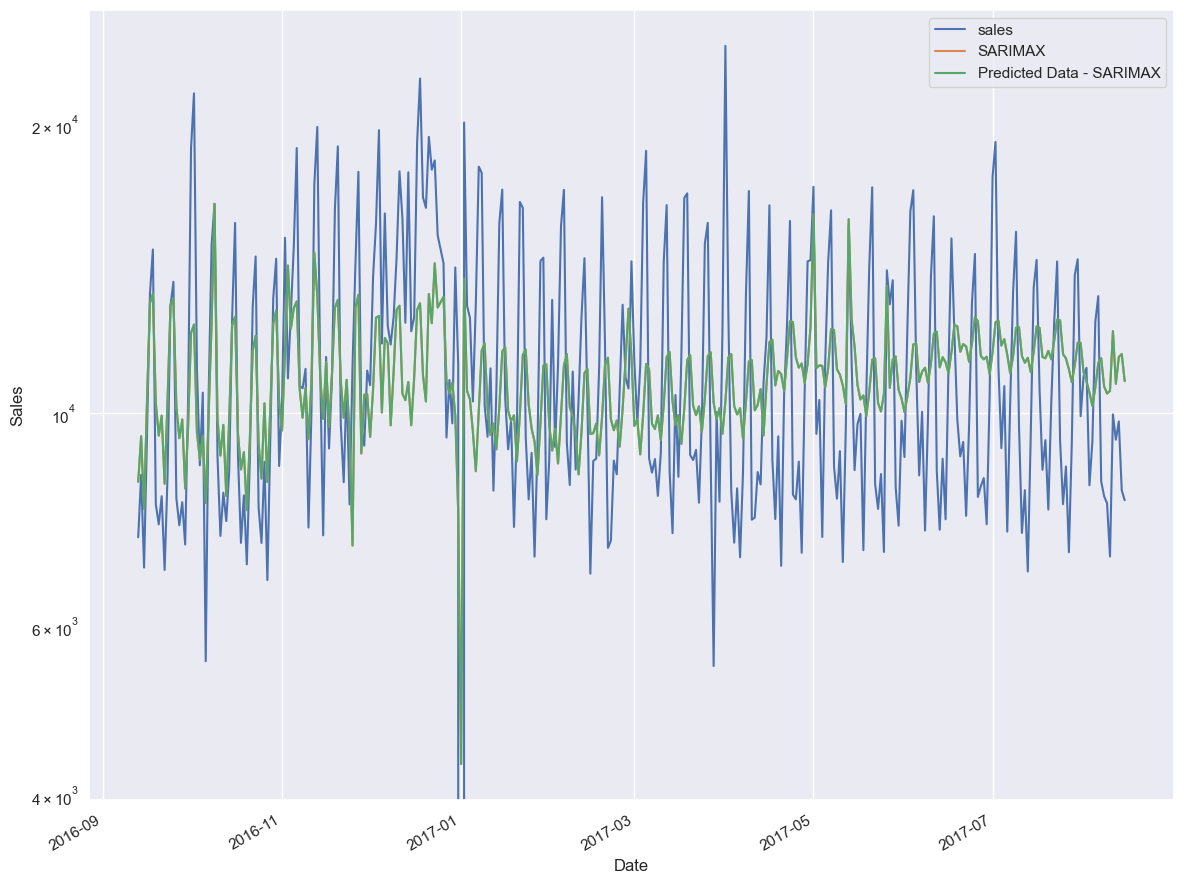

In [238]:
df = pd.concat([test.reset_index()[['date','sales']], preds.reset_index()],axis=1)
df.reset_index(inplace=True)

fig, ax = pyplot.subplots(1,1,figsize=(12,9))
df.plot(x='date', y='sales', ax=ax, label='sales')
df.plot(x='date', y='SARIMAX Preds', ax=ax, label='SARIMAX')

pyplot.plot(test.index,preds,label='Predicted Data - SARIMAX')

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()

In [239]:
error=rmse(df['SARIMAX Preds'], df['sales'])
error


3092.9418413160533

##### m=7

In [226]:
# train w auto_arima
model = auto_arima(train['sales'], seasonal=True, start_p=0, start_q=7, max_q=15, m=7, trace=True)

# get parameters
params = model.get_params()
order_aa = params.get('order')

p,d,q = order_aa[0], order_aa[1], order_aa[2] 
seasonal_order_aa = params.get('seasonal_order')

Performing stepwise search to minimize aic
 ARIMA(0,1,6)(1,0,1)[7] intercept   : AIC=inf, Time=6.70 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=26179.551, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=25867.211, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=25594.729, Time=1.84 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=26177.554, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=25718.798, Time=0.24 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=25263.574, Time=1.70 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=25334.956, Time=3.55 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=25297.571, Time=3.36 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=25522.024, Time=3.14 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=3.89 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=25802.838, Time=2.11 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=i

In [227]:
exog_vars = [item for item in features_to_use if item not in ['date','sales']]

# train model
model = SARIMAX(
    train['sales'],
    exog=train[exog_vars],
    order=(order_aa[0], order_aa[1], order_aa[2]), 
    seasonal_order =(seasonal_order_aa[0], seasonal_order_aa[1], seasonal_order_aa[2], seasonal_order_aa[3])
)
results = model.fit()
# results.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          106     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33231D+00    |proj g|=  8.67908D-02


 This problem is unconstrained.



At iterate    5    f=  9.31837D+00    |proj g|=  6.47293D-02

At iterate   10    f=  9.29168D+00    |proj g|=  1.29605D-02

At iterate   15    f=  9.28809D+00    |proj g|=  4.91877D-03

At iterate   20    f=  9.28756D+00    |proj g|=  5.29413D-04

At iterate   25    f=  9.28618D+00    |proj g|=  8.12493D-03

At iterate   30    f=  9.28506D+00    |proj g|=  5.14401D-04

At iterate   35    f=  9.28477D+00    |proj g|=  2.94169D-03

At iterate   40    f=  9.27929D+00    |proj g|=  3.65288D-03

At iterate   45    f=  9.27880D+00    |proj g|=  1.01525D-03

At iterate   50    f=  9.27862D+00    |proj g|=  1.79094D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [232]:
# predict
start = len(train)
end = len(train) + len(test) - 1
preds = results.predict(start, end, exog=test[exog_vars], type='levels').rename(f'SARIMAX Preds') # type='levels' showing original data (as opposed to the differenced TS)
# pred_SARIMAX = results.get_forecast(steps=len(test), exog=test[['onpromotion', 'oil_price']])


In [233]:
p_df = pd.DataFrame()

# concat result df
test2 = test.reset_index()
# test2['id'] = test2['family'].astype(str) + '_' + test2['store_nbr'].astype(str)

tmp_df = pd.DataFrame()
tmp_df = pd.concat(
    [
        preds.reset_index(drop=True),
        # pred_SARIMAX.predicted_mean.reset_index(drop=True),
        test2[features_to_use]

    ], 
    axis=1
)

p_df = pd.concat([tmp_df, p_df],axis=1)

# # time
# runtime = (time.time() - startTime)/60
# print(f"{k} took {round(runtime,2)} mins")

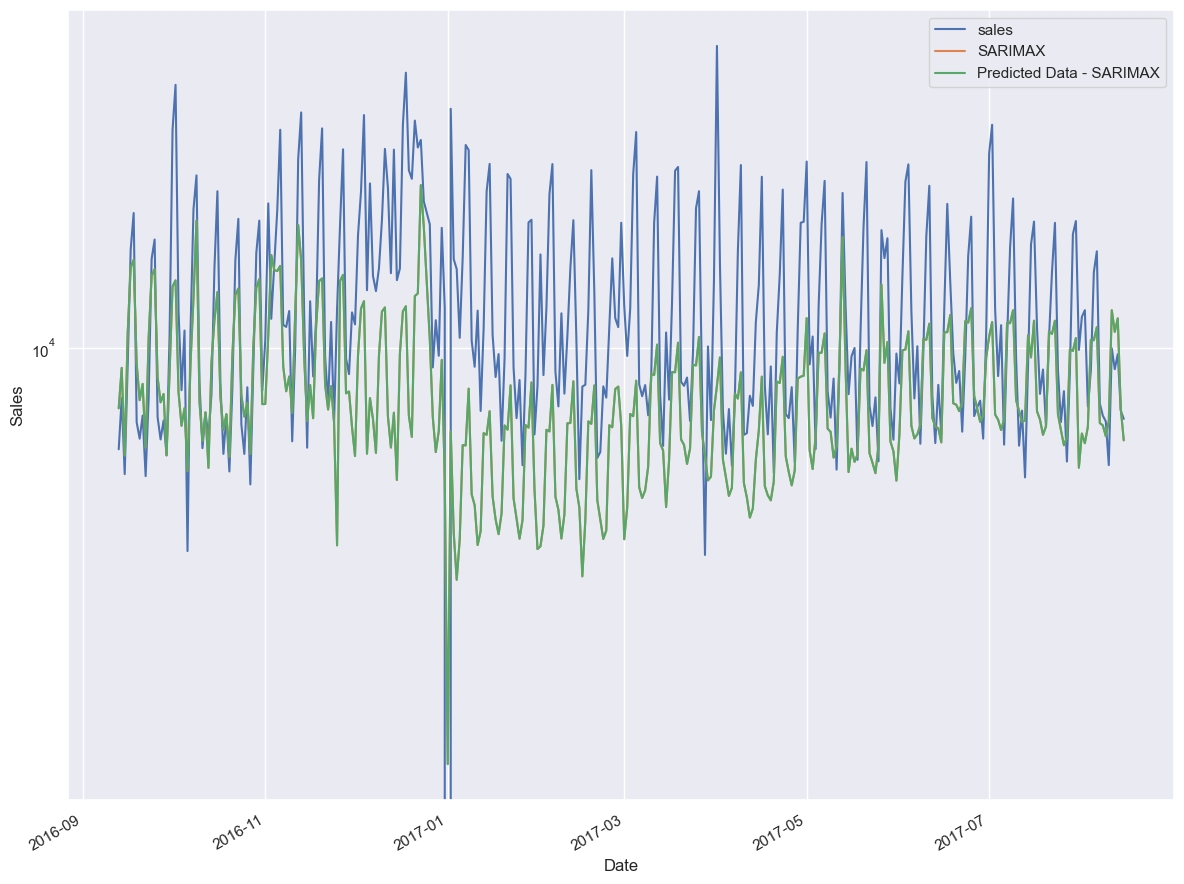

In [234]:
df = pd.concat([test.reset_index()[['date','sales']], preds.reset_index()],axis=1)
df.reset_index(inplace=True)

fig, ax = pyplot.subplots(1,1,figsize=(12,9))
df.plot(x='date', y='sales', ax=ax, label='sales')
df.plot(x='date', y='SARIMAX Preds', ax=ax, label='SARIMAX')

pyplot.plot(test.index,preds,label='Predicted Data - SARIMAX')

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()

In [235]:
error=rmse(df['SARIMAX Preds'], df['sales'])
error


3838.9129121902038

##### m=14

`m`=14 gives WORSE results than `m`=7

In [20]:
# train w auto_arima
model = auto_arima(train['sales'], seasonal=True, start_p=0, start_q=7, max_q=15, m=14, trace=True)

# get parameters
params = model.get_params()
order_aa = params.get('order')

p,d,q = order_aa[0], order_aa[1], order_aa[2] 
seasonal_order_aa = params.get('seasonal_order')

Performing stepwise search to minimize aic
 ARIMA(0,1,7)(1,0,1)[14] intercept   : AIC=inf, Time=8.61 sec
 ARIMA(0,1,0)(0,0,0)[14] intercept   : AIC=26179.551, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[14] intercept   : AIC=25865.205, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[14] intercept   : AIC=25587.783, Time=2.08 sec
 ARIMA(0,1,0)(0,0,0)[14]             : AIC=26177.554, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[14] intercept   : AIC=25718.798, Time=0.34 sec
 ARIMA(0,1,1)(1,0,1)[14] intercept   : AIC=25311.202, Time=2.90 sec
 ARIMA(0,1,1)(1,0,0)[14] intercept   : AIC=25521.465, Time=2.39 sec
 ARIMA(0,1,1)(2,0,1)[14] intercept   : AIC=25399.526, Time=8.21 sec
 ARIMA(0,1,1)(1,0,2)[14] intercept   : AIC=25318.829, Time=9.09 sec
 ARIMA(0,1,1)(0,0,2)[14] intercept   : AIC=25525.977, Time=7.70 sec
 ARIMA(0,1,1)(2,0,0)[14] intercept   : AIC=25431.494, Time=6.04 sec
 ARIMA(0,1,1)(2,0,2)[14] intercept   : AIC=inf, Time=9.51 sec
 ARIMA(0,1,0)(1,0,1)[14] intercept   : AIC=25852.027, Time=2.20 sec
 ARIMA(1,1,1)(1,0

In [25]:
exog_vars = [item for item in features_to_use if item not in ['date','sales']]

# train model
model = SARIMAX(
    train['sales'],
    exog=train[exog_vars],
    order=(order_aa[0], order_aa[1], order_aa[2]), 
    # order = (0,0,2),    # p,d,q
    seasonal_order =(seasonal_order_aa[0], seasonal_order_aa[1], seasonal_order_aa[2], seasonal_order_aa[3])
)
results = model.fit()
# results.summary()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          197     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39950D+00    |proj g|=  1.84546D-01

At iterate    5    f=  9.35430D+00    |proj g|=  6.33253D-02

At iterate   10    f=  9.33611D+00    |proj g|=  6.54017D-03

At iterate   15    f=  9.33554D+00    |proj g|=  7.31101D-04

At iterate   20    f=  9.33550D+00    |proj g|=  3.04569D-03

At iterate   25    f=  9.33411D+00    |proj g|=  3.55464D-02

At iterate   30    f=  9.32678D+00    |proj g|=  2.68824D-03

At iterate   35    f=  9.32642D+00    |proj g|=  3.32936D-04

At iterate   40    f=  9.32640D+00    |proj g|=  2.39253D-03

At iterate   45    f=  9.32541D+00    |proj g|=  1.94998D-02

At iterate   50    f=  9.31475D+00    |proj g|=  8.71931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [26]:
# predict
start = len(train)
end = len(train) + len(test) - 1
preds = results.predict(start, end, exog=test[exog_vars], type='levels').rename(f'SARIMAX Preds') # type='levels' showing original data (as opposed to the differenced TS)
# pred_SARIMAX = results.get_forecast(steps=len(test), exog=test[['onpromotion', 'oil_price']])


In [27]:
p_df = pd.DataFrame()

# concat result df
test2 = test.reset_index()
# test2['id'] = test2['family'].astype(str) + '_' + test2['store_nbr'].astype(str)

tmp_df = pd.DataFrame()
tmp_df = pd.concat(
    [
        preds.reset_index(drop=True),
        # pred_SARIMAX.predicted_mean.reset_index(drop=True),
        test2[features_to_use]

    ], 
    axis=1
)

p_df = pd.concat([tmp_df, p_df],axis=1)

# # time
# runtime = (time.time() - startTime)/60
# print(f"{k} took {round(runtime,2)} mins")

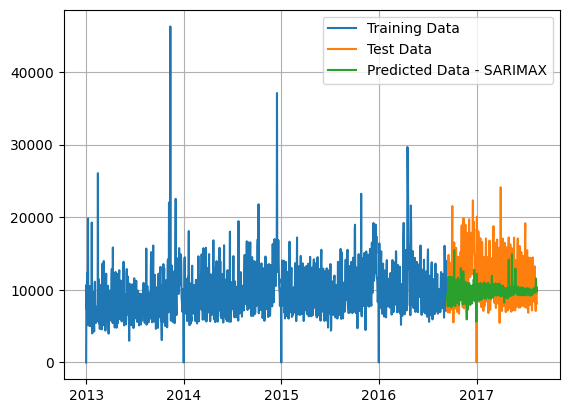

In [28]:
pyplot.plot(train['sales'], label='Training Data')
pyplot.plot(test['sales'], label='Test Data')

pyplot.plot(test.index,preds,label='Predicted Data - SARIMAX')
# pyplot.plot(test.index,pred_SARIMAX.predicted_mean,label='Predicted Data - SARIMAX_interst rate')
# pyplot.plot(test.index,pred_SARIMAX_unemployment.predicted_mean,label='Predicted Data - SARIMAX_unemploymnet rate')
pyplot.legend(loc='best')
pyplot.grid();

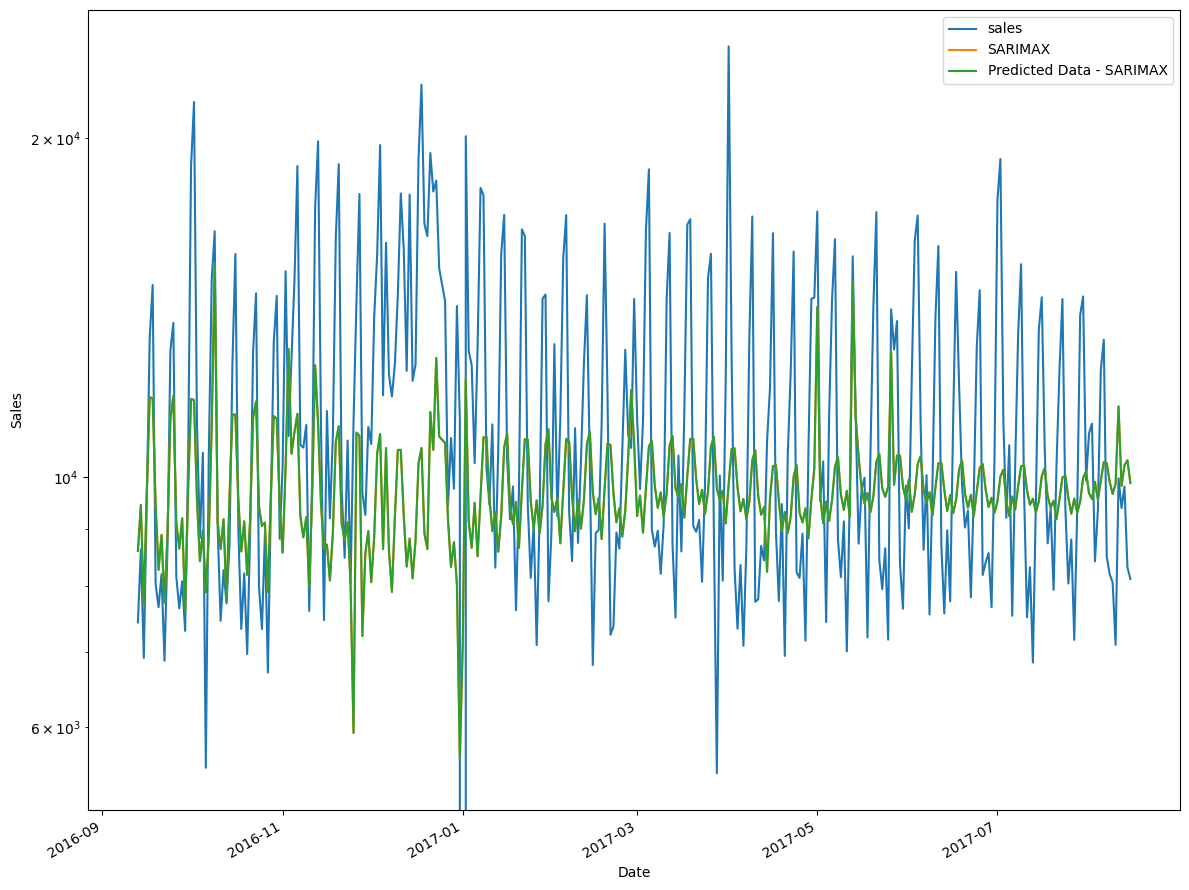

In [29]:
df = pd.concat([test.reset_index()[['date','sales']], preds.reset_index()],axis=1)
df.reset_index(inplace=True)

fig, ax = pyplot.subplots(1,1,figsize=(12,9))
df.plot(x='date', y='sales', ax=ax, label='sales')
df.plot(x='date', y='SARIMAX Preds', ax=ax, label='SARIMAX')

pyplot.plot(test.index,preds,label='Predicted Data - SARIMAX')

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_yscale('log')
ax.legend()
fig.tight_layout()

In [30]:
error=rmse(df['SARIMAX Preds'], df['sales'])
error

3540.482198812094

In [14]:
train_prophet = train_engineered[['date','sales']].rename(columns={'date':'ds', 'sales':'y'})
train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])

In [8]:
p_df = pd.DataFrame()

# for k,v in dct.items():
for k in lst:
    startTime = time.time()

    item = k
    tmp = pd.DataFrame()

    tmp = train_prophet[train_prophet['uid']==k]
    df = tmp[['date','store_nbr', 'family', 'sales']].reset_index().set_index(['date'])

    # split
    train = df.iloc[:round(len(df) * .8)+1]
    test = df.iloc[round(len(df) * .8)+1:]

    # # train
    # model = auto_arima(train['sales'], seasonal=True, start_p=3, max_p=10, m=7)

    # # get parameters
    # params = model.get_params()
    # order_aa = params.get('order')
    
    # p,d,q = order_aa[0], order_aa[1], order_aa[2] 
    # seasonal_order_aa = params.get('seasonal_order')

    # train model
    # model = SARIMAX(
    #     train['sales'],
    #     order=(order_aa[0], order_aa[1], order_aa[2]), 
    #     seasonal_order =(seasonal_order_aa[0], seasonal_order_aa[1], seasonal_order_aa[2], seasonal_order_aa[3])
    # )
    model = prophet()
    results = model.fit(train)

    # predict
    start = len(train)
    end = len(train) + len(test) - 1
    preds = results.predict(start, end, type='levels').rename(f'Prophet Preds') # type='levels' showing original data (as opposed to the differenced TS)


    # concat result df
    test2 = test.reset_index()
    test2['id'] = test2['family'].astype(str) + '_' + test2['store_nbr'].astype(str)

    tmp_df = pd.DataFrame()
    tmp_df = pd.concat(
        [
            preds.reset_index(drop=True, name='pred'), 
            test2[['date','id','family', 'sales']]
        ], 
        axis=1)

    p_df = pd.concat([tmp_df, p_df],axis=0)

    # time
    runtime = (time.time() - startTime)/60
    print(f"{k} took {round(runtime,2)} mins")

# Resources

- [Kaggle: Following TS Tutorial](https://www.kaggle.com/code/howoojang/first-kaggle-notebook-following-ts-tutorial#Time-Series-as-Features)
- [Kaggle: TS Forecast Viz](https://www.kaggle.com/code/maricinnamon/store-sales-time-series-forecast-visualization/comments)
- [Kaggle: Moving Avg](https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide/notebook#11.-Exponential-Moving-Average)

- [Github Jupyternotebook: Housing Price Forecasting (with SARIMAX & PROPHET)
](https://gist.github.com/yassmin1/76f6ccea754417be25fd61948ebf5ffc#file-house_price_forecasting-ipynb)